## Goals of Project

1. Automate the process of writing notes in a natural language format of each tract in a BLM Oil and Gas Lease Sale

2.  Create visualizaitons tract by tract for CEO depicting permitting, new production, and leasing activity within a given radius

3.  Create a predictive model to estimate the purchase price based on historical activity, production, permits, and commodity prices

## Goals of Notebook
1.  Read in Cleaned Data for sale note generation 
2.  Create functions:
    * Retrieve data from dataframe for tract in evaluation
    * Write permit, recent production, old production, and leases activity summary
    * Create visualization/charts for permits, recent production, old production, and leases data around tract
3.  Save summaries and visualizations into Excel and Pdf

### Pending Tasks

* Add functionality to create concatenated dataframes for lease tracts with multiple polygons - This will create separate filters for each polygons individual centroid and compile the data as 1 dataframe for visualization and analysis

* fix bug in note generation where leases with high variabliity in bonus price skews the summary (remove outliars)


In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import shapely
import math
import datetime as dt
import pdb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
#had to add GDAL_DATA variable to system variables and set value to the folder of gdal in C:\Users\mishaun\AppData\Local\Continuum\anaconda3\Library\share\gdal on my work computer
'GDAL_DATA' in os.environ

False

In [2]:
#Running GlobalFunc_Vars script to get functions and global variables
%run GlobalFuncts_n_Vars.py

In [3]:
%store -r tractshp

# Section for creating summary functions and testing logic

In [4]:
# # 5-10-20 VOID LINE OF CODE - new method of getting test tract by looking at dataframes read from file
# tPerm, tProd, tLea, tOld = prepareTractFilter(37)

In [5]:
#reading dataframes from excel file
fullFilteredLeases = pd.read_excel("Output Data/Sale Tracts Activity Data/Leases Around Sale Tracts.xlsx")
fullFilteredPermits = pd.read_excel("Output Data/Sale Tracts Activity Data/Permits Around Sale Tracts.xlsx")
fullFilteredProd = pd.read_excel("Output Data/Sale Tracts Activity Data/Prod Around Sale Tracts.xlsx")
fullFilteredOldProd = pd.read_excel("Output Data/Sale Tracts Activity Data/OldProd Around Sale Tracts.xlsx")

In [6]:
#old production must be converted back into geodata frame because the write old prod summary... ->
#uses geospatial filtering to find wells within tract boundaries of tract
# *** Init CRS should be initial CRS of shapefile from import because we are creating the geometries based on the lat and longs
# *** Trying to import as a geodataframe using directly the geometry column was troublesome - geopandas did not recongize the column data type as point
fullFilteredOldProd= gp.GeoDataFrame(fullFilteredOldProd,  crs = {'init': 'epsg:4326'}, geometry=gp.points_from_xy(fullFilteredOldProd["Longitude"], fullFilteredOldProd["Latitude"]))

#converting oldprod geodataframe crs
convertCRS(fullFilteredOldProd)


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}




In [7]:
#writing fuction to get data from pandas dataframe that was accessed from file
def getActivityData(tractNum):
    
    '''
    This function will filter fullFiltered global variable dataframes to tract specific data
    '''
    
    tractLeases = fullFilteredLeases.loc[fullFilteredLeases["tract_id"] == tractNum]
    tractPermits = fullFilteredPermits.loc[fullFilteredPermits["tract_id"] == tractNum]
    tractProd = fullFilteredProd.loc[fullFilteredProd["tract_id"] == tractNum]
    tractOldProd = fullFilteredOldProd.loc[fullFilteredOldProd["tract_id"] == tractNum]
    
    return tractPermits, tractProd, tractLeases, tractOldProd

In [8]:
#test tract and retrieve data around tract
tPerm, tProd, tLea, tOld = getActivityData(40)

### Function to write permits around tract summary

In [9]:
#testing out data 

tPerm.groupby("OpAlias").count().head(3)["API10UWI"]

Series([], Name: API10UWI, dtype: int64)

In [10]:
def writePermitSummary(geoDF):
    
    #getting overall count of permits within in the spatial filter
    count = int(geoDF["API10UWI"].count())
    
    if count == 0 or type(geoDF) == type(None):
        summaryText = "There are no permits within a 3 mile radius"
        return summaryText
    
    #stating how many permits were found based on mile radius
    a = "In a {} mile radius there are {} active permits".format(miradius, count)
    
    #getting summary of stats for numerical columns grouped by well orientation
    byWellType = geoDF.groupby("DrillType").describe()
    
    
    #creating a list comprehension to count 
    b = [("{:.0f} permits are {} wells ".format(byWellType["PermDepth"]["count"].loc[i], i)) for i in byWellType.index]
    
    #if there were multiple types of permits, join the list with ";", otherwise take 1st index and ocnvert to string
    if len(byWellType)>1:
        b = "; ".join(b)
    else: 
        b = b[0]
    
    #only talking about lateral length for horz wells
    if 'H' in b:
        #rounding off to the nearest thousand (-3 in the second argument of the function round
        avgHlength = round(byWellType["horzLength"]["mean"].loc["H"],-3)
        avgTVD = round(byWellType["TVD"]["mean"]["H"], -2)
        
        b += "\nThe average lateral length among these permits is {:.0f} ft.".format(avgHlength)
        b += " \n- The TVD for these well(s) are ~{:.0f}ft".format(avgTVD)
    else:
        #consider adding a standard deviation conditional analysis whether to show avg depth for V permits or min max mean type summary
        b += "The average TVD for the vertical permits are {:.0f}".format(round(byWellType["TVD"].loc["V"]["mean"], -2))
    
    #getting top 3 operators with permits
    topOperators = geoDF.groupby("OpAlias").count().head(3)
    
    #list comprehension to build list with strings having operator and their permit count in 3 mi radius
    c = ["{} has {} permits".format(i.title(), topOperators["API10UWI"].loc[i]) for i in topOperators.index]
    c = ", ".join(c)
    
    summaryText = "\n".join([a,b,c])
    
    return summaryText
    

In [11]:
print(writePermitSummary(tPerm))

There are no permits within a 3 mile radius


### Function to write leaes around tract summary

In [12]:
tLea

,Unnamed: 0,State/Province,Effective Date,Record Date,Expiration of Primary Term,Term (Months),Grantor,Grantee Alias,Royalty,Bonus,...,Latitude (WGS84),DI Play,Majority Legal Assignee Interest,Longitude (WGS84),Majority Assignment Vol/Page,geometry,distance,direction,RecordYr,tract_id


In [13]:
unique = tLea.drop_duplicates(subset=["Record Number", "Area (Acres)", "Bonus"])
unique

,Unnamed: 0,State/Province,Effective Date,Record Date,Expiration of Primary Term,Term (Months),Grantor,Grantee Alias,Royalty,Bonus,...,Latitude (WGS84),DI Play,Majority Legal Assignee Interest,Longitude (WGS84),Majority Assignment Vol/Page,geometry,distance,direction,RecordYr,tract_id


In [14]:
def writeLeaseSummary(geoDF):
    
    #getting overall count of leases within in the spatial filter
    count = geoDF["Grantee Alias"].count()
    
    if count == 0:
        return "There are no recorded leases within a 3 mile radius"
    
    #getting leases only with bonuses and dropping duplicates where lease is repeated within same section
    leaseBonuses = geoDF[geoDF["Bonus"]>0]
    leaseBonuses = leaseBonuses.drop_duplicates(subset = ['geometry', "Record Number"])
    #rounding distances to nearest tength
    leaseBonuses["distance"] = leaseBonuses["distance"].apply(lambda x: round(x,1))
    
    #stating how many leases were found based on mile radius and most recent 
    latestYr = leaseBonuses["RecordYr"].max()
    a = "In a {} mile radius, the latest leases with bonus information were taken in {}.".format(miradius, latestYr)
    
    #getting summary of leases taken in most recent year, grouped by grantee
    byGrantee = leaseBonuses[leaseBonuses["RecordYr"]==latestYr]
    byGrantee = byGrantee.groupby("Grantee Alias").describe()
    
    #gtting 2 most active lessees
    mostGrantees = byGrantee["Bonus"].sort_values("count", ascending = False).head(2)
    
    b = ""
    #looping thorugh the 2 lessee's to get their average price paid
    for i in mostGrantees.index:
        #if the std deviation is 0 or is not available, then there is an exact price paid
        if mostGrantees["std"].loc[i] == 0 or np.isnan(mostGrantees["std"].loc[i]):
            b += "{} paid ${:.0f}/acre.  ".format(i.title(), mostGrantees["mean"].loc[i])
        #if there is a standard deviation, then we will give the range and average
        else:
            b += "{} paid between ${:.0f}/acre and ${:.0f}/acre.  ".format(i.title(), mostGrantees["min"].loc[i], mostGrantees["max"].loc[i])
    
    #if there was 2 or more lessee's for the given latest year, then report average bonus price for the data
    if leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].count() > 2:
        
        #calculating weighted average by dropping duplicate leases by record number, bonus, and acreage
        unique = leaseBonuses[leaseBonuses["RecordYr"]==latestYr].drop_duplicates(subset=["Record Number", "Area (Acres)", "Bonus"])
        weightedAvg = sum(unique["Bonus"] * unique["Area (Acres)"]) / sum(unique["Area (Acres)"])
        
        b+= "The weighted average price in {} overall within the {} radius was ${:.0f}/acre.  ".format(latestYr,miradius,weightedAvg)
        
        #checking to see if highest price paid differes from the mean, if so, comment about the highest price
        if leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].mean() != leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].max():
            b += "The highest price paid in {:.0f} was ${:.0f}/acre".format(latestYr, leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].max())
    
    #generating list for previous years of latest lease taken by 4 years back
    previousYears = list(range(latestYr-1, latestYr-4, -1))
    
    c = ""
    for yr in previousYears:
        #saving dataframe filtered to year of interest
        curYr = leaseBonuses[leaseBonuses["Record Date"].apply(lambda x: x.year) == yr]
        
        #checking to see if the dataframe has values with bonuses
        if len(curYr)>0:
            
            c += "In {}, ".format(yr)
            
            #grouping the filtered dataframe by year by grantee
            grouped = curYr.groupby("Grantee Alias").describe()["Bonus"]
            
            #limiting summary to top 2 most active grantees
            grouped = grouped.sort_values("count", ascending = False).head(2)
            
            #looping through top 2 grantees to get their bonus range paid
            for grantee in grouped.index:
                
                #if the grantee has a std of 0, then there is no variance and the average can be mentioned
                if grouped.loc[grantee]["std"] == 0 or np.isnan(grouped.loc[grantee]["std"]):
                    c += "{} paid ${:.0f}/acre. \n".format(grantee.title(), grouped.loc[grantee]["mean"])
                #if there is a std, then give the range the grantee paid
                else:
                    c += "{} paid between ${:.0f}/acre and ${:.0f}/acre. \n".format(grantee.title(), grouped.loc[grantee]["min"],grouped.loc[grantee]["max"]) 
    
    summaryText = "\n".join([a,b,c])
    
    return summaryText
    

In [15]:
writeLeaseSummary(tLea)

'There are no recorded leases within a 3 mile radius'

### Last 4 years of production summary function

In [16]:
pd.set_option('max_columns', 30)
tProd
tProd.columns

,Unnamed: 0,APIUWI,OpAlias,OpCompany,OpReported,OpTicker,LeaseName,WellNo,EntityType,County,DIBasin,DIPlay,DISubplay,Reservoir,ProdType,...,Survey,OCS_Area,PGC_Area,Latitude,Longitude,Last12Liq,Last12Gas,Last12Wtr,EntityId,OtherNo,OpAliasID,geometry,distance,direction,tract_id


Index(['Unnamed: 0', 'APIUWI', 'OpAlias', 'OpCompany', 'OpReported',
       'OpTicker', 'LeaseName', 'WellNo', 'EntityType', 'County', 'DIBasin',
       'DIPlay', 'DISubplay', 'Reservoir', 'ProdType', 'ProdStatus',
       'DrillType', 'FstPrdDate', 'LstPrdDate', 'CumGas', 'CumLiq', 'CumBOE',
       'CumMMCFGE', 'CumBCFGE', 'DailyGas', 'DailyLiq', '1moLiq', '1moGas',
       '1moWater', '6moLiq', '6moGas', '6moBOE', '6moWater', '12moLiq',
       '12moGas', '12moBOE', '12MMCFGE', '12moWater', '24moLiq', '24moGas',
       '24moBOE', '24moMMCFGE', '24moWater', '60moLiq', '60moGas', '60moBOE',
       '60moMMCFGE', '60moWater', 'PracIP_Liq', 'PracIP_Gas', 'PrcIPCFGED',
       'PracIP_BOE', 'LatestLiq', 'LatestGas', 'WellCount', 'MaxActvWel',
       'MoProd', 'SpudDate', 'TD', 'TVD', 'PerfLength', 'Field', 'State',
       'District', 'GeoProvin', 'Country', 'Section', 'Township', 'Range',
       'Abstract', 'Block', 'Survey', 'OCS_Area', 'PGC_Area', 'Latitude',
       'Longitude', 'Last12Liq',

In [17]:
def writeProdSummary(geoDF):
    
    #getting overall count of leases within in the spatial filter
    overallcount = geoDF["APIUWI"].count()
    
    if overallcount == 0:
        return "There are no new wells in the last 4 years within a 3 mile radius"
 
    a = "There are {:.0f} wells within 3 mile radius that have started producing within last 4 years".format(overallcount)
    
    if overallcount <=3:
        b = ""
        
        for i in geoDF.index:
            welldata = geoDF.loc[i]
            dist, direct, op = welldata["distance"], welldata["direction"], welldata["OpAlias"]
            Dtype, depth = welldata["DrillType"], welldata["TD"]
            totOil, totGas, monthprod = welldata["CumLiq"]/1000, welldata["CumGas"]/1000, welldata["MoProd"]
            
            
            
            b += "\n{:.2f} mi {}, {} has a {} well at {:.0f} that has made {:.0f} mbbl and {:.0f} mmcf after {:.0f} months of producing".format(dist,direct,op.title(),Dtype,depth,totOil,totGas,monthprod)
        
        summaryText = '\n'.join([a,b])
        
        return summaryText
        
    else:
    

        wellTypes = geoDF["DrillType"].value_counts()  
        b = ["{} are {} wells".format(wellTypes.loc[i],i) for i in wellTypes.index]
        b = "; ".join(b)


        #creating bins for production months in order to describe stats (cum oil, cum gas, latest vols, etc) for wells within prod interval

        bins = pd.IntervalIndex.from_tuples([(0,1), (2,3), (4,5), (6,8), (9,10), (11,12), (12,18), (19,24), (25,36), (37,48)])

        geoDF["binsbyprodmonth"] = pd.cut(geoDF["MoProd"], bins, precision = 0)


        #grouping the wells by their binned months producing and generating full summary
        byBinMonth = geoDF.groupby("binsbyprodmonth").describe()

        #initializing empty string to build upon
        s=""

        #looping through each index and generating text summary
        for i in byBinMonth.index:

            count = byBinMonth.loc[i]["MoProd"]["count"]

            #if there are more than 1 well in the bin, then get a range of production along with current production
            if  count > 1:
                s += "{:.0f} wells have produced for {:.0f} to {:.0f} months".format(count, i.left, i.right)

                # getting statistics for wells in bin
                minGas = byBinMonth.loc[i]["CumGas"]["min"] / 1000
                maxGas = byBinMonth.loc[i]["CumGas"]["max"] / 1000
                minOil = byBinMonth.loc[i]["CumLiq"]["min"] / 1000
                maxOil = byBinMonth.loc[i]["CumLiq"]["max"] / 1000

                latestOil = byBinMonth.loc[i]["LatestLiq"]["mean"] / 30
                latestGas = byBinMonth.loc[i]["LatestGas"]["mean"] / 30

                #building string 
                s += " and have made between {:.0f} to {:.0f} mbbls with {:.0f} to {:.0f} mmcf of gas.  ".format(minOil, maxOil, minGas, maxGas)
                s += "These wells are currently averaging {:.0f} bpd and {:.0f} mcfd.  ".format(latestOil, latestGas)

            #if there is just 1 well in the bin, then just report the cumulative vols and current prod
            elif count > 0:
                oilProd = byBinMonth.loc[i]["CumLiq"]["mean"] / 1000
                gasProd = byBinMonth.loc[i]["CumGas"]["mean"] / 1000
                moProd = byBinMonth.loc[i]["MoProd"]["mean"]
                latestOil = byBinMonth.loc[i]["LatestLiq"]["mean"] / 30
                latestGas = byBinMonth.loc[i]["LatestGas"]["mean"] / 30

                s += "{:.0f} well has made {:.0f} mbbl and {:.0f} mmcfd in {:.0f} months and is currently making {:.0f} bpd and {:.0f} mcfd.  ".format(count, oilProd, gasProd, moProd, latestOil, latestGas)

            
    summaryText = "\n".join([a,b,s])
    
    return summaryText
    

In [18]:
writeProdSummary(tProd)

'There are no new wells in the last 4 years within a 3 mile radius'

### Function and Log to write Old Production Summary

In [19]:
def writeOldProdSummary(geoDF, tractNum):
    
    
    #cleans up production dataframe in case import had such data values when imported from drillinginfo
    geoDF = geoDF.loc[geoDF["ProdStatus"].apply(lambda x: "PERMIT" not in x)]
    
    summaryText = ''
    
    if len(geoDF) == 0:
        return "No old wells within tract or in 3 mile radius of tract."
    
    #this line regrabs the tract geometry that has been evaluated in order to perform a more specific query of wells on the tract
    tractBoundaries = tractshp[tractshp["tract_id"] == tractNum]["geometry"].iloc[0]
    
    wellsWithinTract = geoDF.loc[geoDF.within(tractBoundaries)]
    
    if wellsWithinTract["APIUWI"].count() > 0:
        a = "There are {} wells within the tract.\n".format(len(wellsWithinTract))
        
        wellTypes = wellsWithinTract["ProdType"]
        
        #running text search to return list in order to prevent missing dry holes that may be labeled "dry holes" instead of just "dry" in DI
        if "DRY" in wellTypes.value_counts():
            
            dryholes = list(filter(lambda x: 'DRY' in x.upper(), wellTypes.value_counts().index))
            
            tot = 0
            for i in dryholes:
                tot += wellTypes.value_counts()[i]
                
            
            b = "{} dry holes in tract.\n".format(tot)
        #This will assign 0 to total if there are no dry holes
        else:
            tot = 0
            b = ''
        

        
        wellsNoInfo = wellsWithinTract[(wellsWithinTract["CumGas"].isnull()) & wellsWithinTract["CumLiq"].isnull()]["APIUWI"].count() - tot
        
        if wellsNoInfo>0:
            c = '{} wells did not report production'.format(wellsNoInfo)   
        else:
            c = ''
    
        #getting dataframe with wells that reported production within tract; how = 'all' fixes error of dropping all rows b/c only 1 column of the 2 is null.
        #how = 'all' ensures both columns are null to be dropped
        wellsInTractProd = wellsWithinTract.dropna(subset = ["CumGas", "CumLiq"], how = "all")
        
        d= ""
        #checking how many wells reported production, ~ symbol is to get not null values
        if wellsInTractProd["APIUWI"].count()>0:
            d += "{} wells reported production.  They produced: ".format(wellsInTractProd["APIUWI"].count())
            
            for well in wellsInTractProd.index:
                
                oil = wellsInTractProd.loc[well]["CumLiq"] / 1000
                gas = wellsInTractProd.loc[well]["CumGas"] / 1000
                yearsProd = str(wellsInTractProd.loc[well]["FstPrdDate"].year) + "-" + str(wellsInTractProd.loc[well]["LstPrdDate"].year)
                md = wellsInTractProd.loc[well]["TD"]
                
                #checks if oil or gas has a null value, if so, it will make it 0 instead of nan
                if np.isnan(oil):
                    oil = 0
                if np.isnan(gas):
                    gas = 0
            
                d += "{:.0f} mbbl and {:.0f} mmcf at {:.0f} ft from years {}, ".format(oil, gas, md, yearsProd)
        
        summaryText = a + b + c + d
    else:
        summaryText = "There are no wells within tract boundaries \n"
    
    #getting wells outside the tract for another analysis - the '~' character works as the "not within" condition        
    wellsOutside = geoDF.loc[~geoDF.within(tractBoundaries)]
    
    if wellsOutside["APIUWI"].count()>0:
        summaryText += "\nThere are ~{} wells outside the tract within a 3 mile radius.\n".format(wellsOutside["APIUWI"].count())
        
        wellsNoInfo = wellsOutside[(wellsOutside["CumGas"].isnull()) & wellsOutside["CumLiq"].isnull()]["APIUWI"].count()
        
        if wellsNoInfo>0:
            
            dryholes = wellsOutside[wellsOutside["ProdType"] == "DRY"].iloc[:,0].count()
            
            summaryText += "Out of these, {} were dry.\n".format(dryholes)
        
            if wellsNoInfo-dryholes != 0:
                summaryText += "{} do not have reported production. \n".format(wellsNoInfo - dryholes)
            
        topWells = wellsOutside.sort_values("CumBOE", ascending = False).dropna(subset=["CumGas", "CumLiq"])

        if topWells["APIUWI"].count() > 0:

            summaryText += "The top wells that produced made: "

            for well in topWells.head().index:
                
                oil = topWells.loc[well]["CumLiq"] / 1000
                gas = topWells.loc[well]["CumGas"] / 1000
                td = topWells.loc[well]["TD"]
                moprod = topWells.loc[well]["MoProd"]
                yearsProdInterval = str(topWells.loc[well]["FstPrdDate"].year) + "-" + str(topWells.loc[well]["LstPrdDate"].year)

                summaryText += "{:.0f} mbbl and {:.0f} mmcf at {:.0f} ft in {:.0f} months from {}; ".format(oil, gas, td, moprod, yearsProdInterval)
        
    return summaryText
    
   

In [20]:
writeOldProdSummary(tOld, 37)

'No old wells within tract or in 3 mile radius of tract.'

# Section for creating statistical plots for permit, leases, and production data & mapping for parcels

### Activity Plots and Dashboards

In [21]:
import matplotlib.ticker as ticker

In [22]:
def createPermitDash(per, tractNum):
    '''This function will create a dashboard describing the permits (per dataframe) around a sale parcel with tractNum'''
    
    if len(per)>0:

        #creating matplotlib figure
        dashPermits, permitAxes = plt.subplots(2,2, figsize = (12,8))

        #inserting barplot showing count of permits by their well status
        sns.countplot(per["WellStatus"], palette = "rainbow", ax=permitAxes[0,0])
        permitAxes[0,0].set_title("Permits by Well Status")

        #inserting subplot onto figure showing permits taken by operator
        sns.countplot(per["OpAlias"], ax = permitAxes[0,1])
        permitAxes[0,1].set_title("Permits by Operator")

        #inserting subplot of permits by drill type
        sns.countplot(per["DrillType"], ax = permitAxes[1,0])
        permitAxes[1,0].set_title("Permits by Well Type (H,D,V)")

        #This will prevent the plot from creating when there is not horzLength column due to the permits not being horizontal
        try:
            sns.distplot(per["horzLength"],bins = 5, ax = permitAxes[1,1], kde = False)
            permitAxes[1,1].set_xlim([0,15000])
            permitAxes[1,1].set_title("Permit Horizontal Lengths - Binned")
        except:
            pass

        dashPermits.suptitle('Permit Summary for Tract {}\n Total permits: {}'.format(tractNum, len(per)), y = 1.05, fontsize = 20, fontweight = 15)


        dashPermits.tight_layout()

        return dashPermits

In [23]:
def createLeasesDash(lea, tractNum):
    
    '''
    This function will take in a dataframe of lease information, lea
    and create a dashboard of lease stats around the tract tractNum
    '''
    
    if len(lea)>0:
    
        #getting leases only with bonuses and dropping duplicates where lease is repeated within same section
        lea = lea[lea["Bonus"]>0]
        lea = lea.drop_duplicates(subset = ['geometry', "Record Number"])

        dashLease, leaseAx = plt.subplots(3,1, figsize = (16,20))

        #creating format for y tickers
        formatter = ticker.FormatStrFormatter('$%1.0f')

        #inserting a swarmplot showing bonus by record year colored by grantee
        sns.swarmplot(lea["RecordYr"], lea["Bonus"], size = 10, hue = lea["Grantee Alias"], ax = leaseAx[0])
        leaseAx[0].set_title("Lease Bonus by Year - Swarmplot")

        #inserting scatter plot showing bonuses away from centroid of tract
        sns.scatterplot(lea["distance"], lea["Bonus"], style = lea["direction"], alpha=.7, hue = lea["RecordYr"], palette="gist_rainbow", s = 150, ax = leaseAx[1])
        leaseAx[1].set_title("Lease Price by Distance of Sale Parcel")

        #barplot of grantee, bonus, and year
        sns.barplot(lea["RecordYr"], lea["Bonus"], hue = lea["Grantee Alias"], ax = leaseAx[2])
        leaseAx[2].set_title("Lease Price by Grantee")

        #top level title statas
        latestYr = lea["RecordYr"].max()
        avgPriceLatestYr = lea[lea["RecordYr"] == latestYr]["Bonus"].mean()

        #setting all axes on figure to dollar sign format
        for ax in leaseAx:
            ax.yaxis.set_major_formatter(formatter)

        #y = 1.03 will move up the subplot title above the first plot's title so they don't overlap
        dashLease.suptitle("Lease Summary for tract {} \n Total Number of Leases: {} \n Average Price ${:.0f}/acre in {}".format(tractNum, len(lea), avgPriceLatestYr, latestYr), y = 1.05, fontsize = 20, fontweight = 15)

        dashLease.tight_layout()

        return dashLease

In [24]:
def createProdDash(pro, tractNum):
    '''This function will take in a geopandas data frame -pro- and create the following plots below onto 1 figure'''
    
    #will only create figure if there is production in the dataframe, otherwise it will not return anything
    if len(pro)>0:
    
        dashProd, prodAx = plt.subplots(3,1, figsize=(16,20))

        sns.scatterplot(pro["CumGas"], pro["CumLiq"], s = 150, hue = pro["MoProd"], ax = prodAx[0])
        prodAx[0].set_title("Scatter Plot - Cumulative Gas vs Cumalative Oil - Colored by Months Produced")

        sns.scatterplot(pro["MoProd"], pro["CumLiq"], s = 150, hue = pro["OpAlias"], ax = prodAx[1])
        prodAx[1].set_title("Cumaltive Oil vs. Months Produced - Colored by Operator")

        sns.scatterplot(pro["MoProd"], pro["CumGas"], s = 150, hue = pro["OpAlias"], ax = prodAx[2])
        prodAx[2].set_title("Cumalative Gas vs. Months Produced - Colored by Operator")
        
        dashProd.tight_layout()
        dashProd.suptitle("Production Dashboard for tract {}".format(tractNum), y = 1.03, fontsize = 20, fontweight = 15)

        return dashProd

In [25]:
def createOldProdDash(OldProd, tractNum):
    
    if len(OldProd)>0:
        
        #retrieving boundary of tract to look at wells wtihin and outside of tract
        #tractshp must be a global variable in the script
        tractBoundary = tractshp.loc[tractshp["tract_id"]==tractNum]["geometry"].iloc[0]

        outsideTract = OldProd.loc[~OldProd.within(tractBoundary)]
        insideTract = OldProd.loc[OldProd.within(tractBoundary)]

        #Creating plots for wells outside of tract
        fig1, ax1 = plt.subplots(4,1, figsize = (16,20))

        sns.scatterplot(outsideTract["MoProd"], outsideTract["CumLiq"], s = 150, palette = "rainbow", hue = outsideTract["TD"], ax = ax1[0])
        ax1[0].set_title("Cumulative Oil vs. Months Produced")

        sns.scatterplot(outsideTract["MoProd"], outsideTract["CumGas"], s = 150, palette = "rainbow", hue = outsideTract["TD"], ax = ax1[1])
        ax1[1].set_title("Cumulative Gas vs. Months Produced")
        ax1[1].grid()

        keyProdTypes = ["OIL", "GAS", "DRY", "DRY HOLE", "CBM"]
        sns.countplot(outsideTract["ProdType"].loc[outsideTract["ProdType"].isin(keyProdTypes)], ax = ax1[2])
        ax1[2].set_title("Production Types Around Tract")

        keyProdStatus = "ACTIVE, INACTIVE, SHUT-IN, SHUT IN, P&A, P & A, PLUGGED".split(', ')
        sns.countplot(outsideTract["ProdStatus"].loc[outsideTract["ProdStatus"].isin(keyProdStatus)], ax=ax1[3])
        ax1[3].set(title = "Status of Wells")

        fig1.suptitle("Old Production Outside of Tract {} - 3 Mi Radius".format(tractNum), y = 1.03, fontsize = 20, fontweight = 15)

        fig1.tight_layout()
        
        #Creating plots for wells within tract, if there are any

        if len(insideTract) > 0:

            fig2, ax2 = plt.subplots(3,1, figsize = (16,20))

            keyProdTypes = ["OIL", "GAS", "DRY", "DRY HOLE", "CBM"]
            sns.countplot(insideTract["ProdType"].loc[insideTract["ProdType"].isin(keyProdTypes)], ax = ax2[0])
            ax2[0].set_title("Production Types Around Tract")

            sns.scatterplot(insideTract["MoProd"], insideTract["CumLiq"], s = 150, palette = "rainbow", hue = insideTract["TD"], ax = ax2[1])
            ax2[1].set_title("Cumulative Oil vs. Months Produced")

            sns.scatterplot(insideTract["MoProd"], insideTract["CumGas"], s = 150, palette = "rainbow", hue = insideTract["TD"], ax = ax2[2])
            ax2[2].set_title("Cumulative Gas vs. Months Produced")
            ax2[2].grid()

            fig2.suptitle("Old Production Inside of Tract {} - 3 Mi Radius".format(tractNum), y = 1.03, fontsize = 20, fontweight = 15)
            fig2.tight_layout()

            return fig1, fig2

        return fig1

In [26]:
# #test loop

# perdashboard = []
# proddashboard = []
# leasedashboard = []

# for i in range(15,17):
    
#     tract = tractshp["tract_id"].iloc[i]
    
#     a, b, c, d = prepareTractFilter(tract)
    
#     perdashboard.append(createPermitDash(a,tract))
#     proddashboard.append(createProdDash(b, tract))
#     leasedashboard.append(createLeasesDash(c, tract))
    
    


## Running summary functions in loop to get summaries for all tracts

error occured in visualizaiton
error occured in visualizaiton
error occured in visualizaiton
error occured in visualizaiton
error occured in visualizaiton
error occured in visualizaiton
error occured in visualizaiton


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

error occured in visualizaiton
error occured in visualizaiton


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


error occured in visualizaiton
error occured in visualizaiton


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

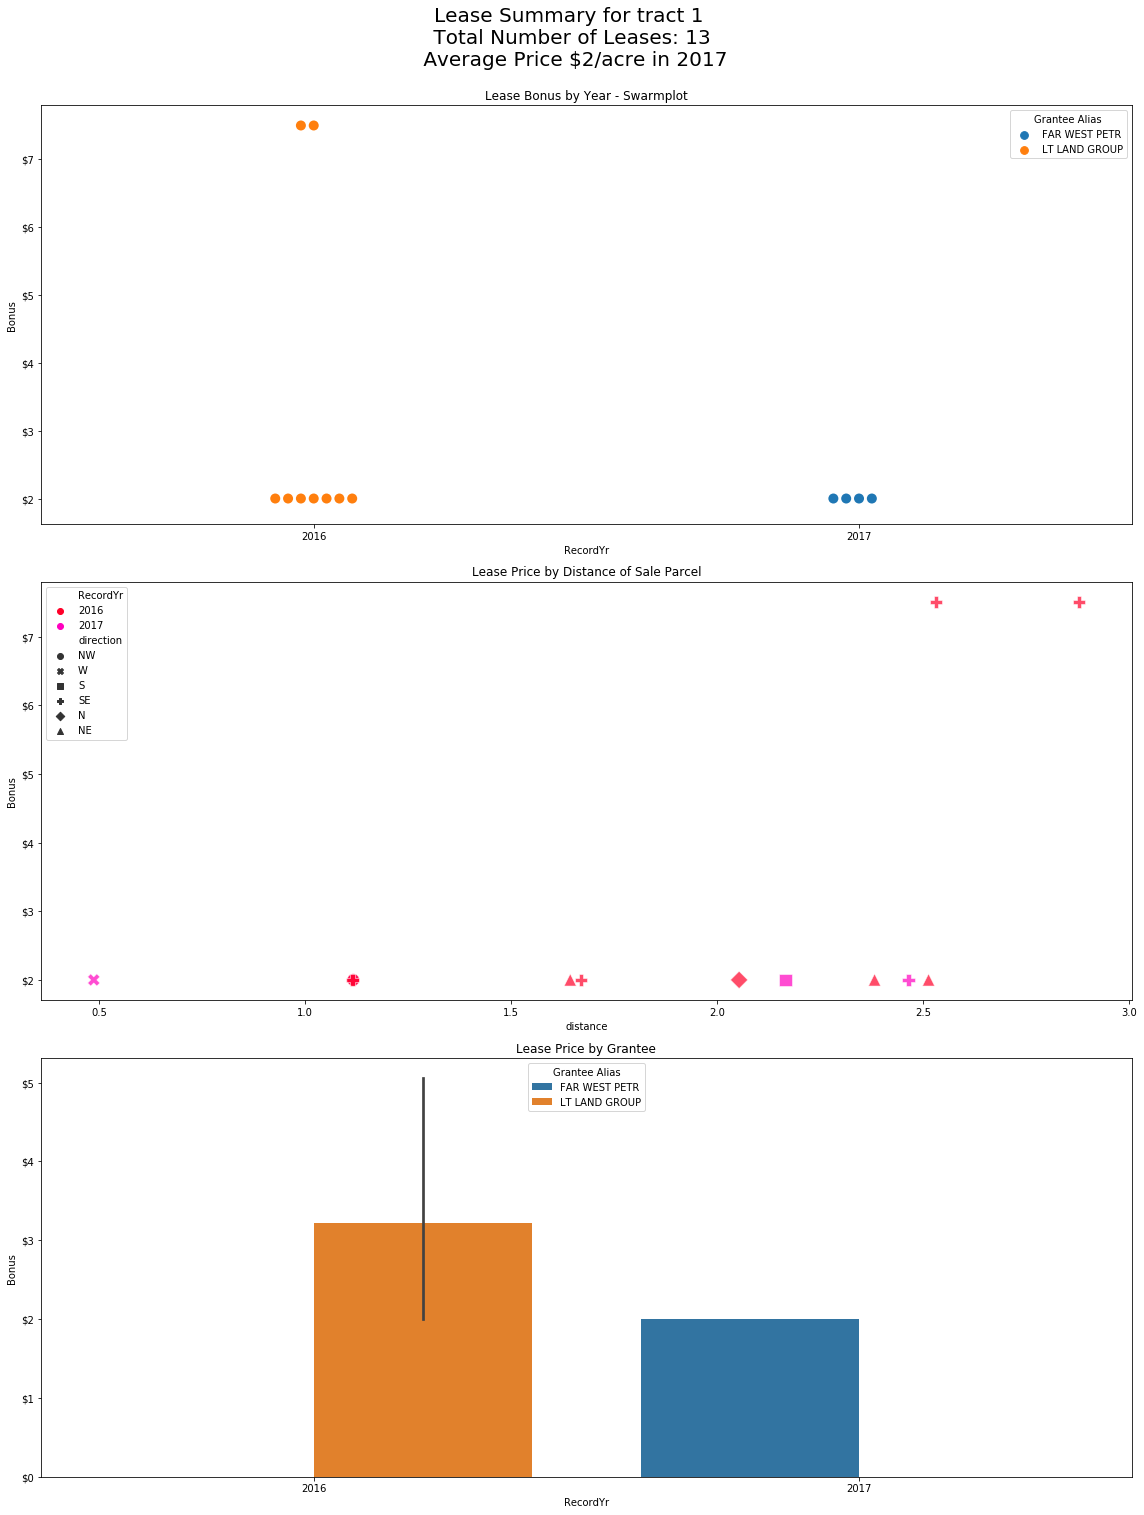

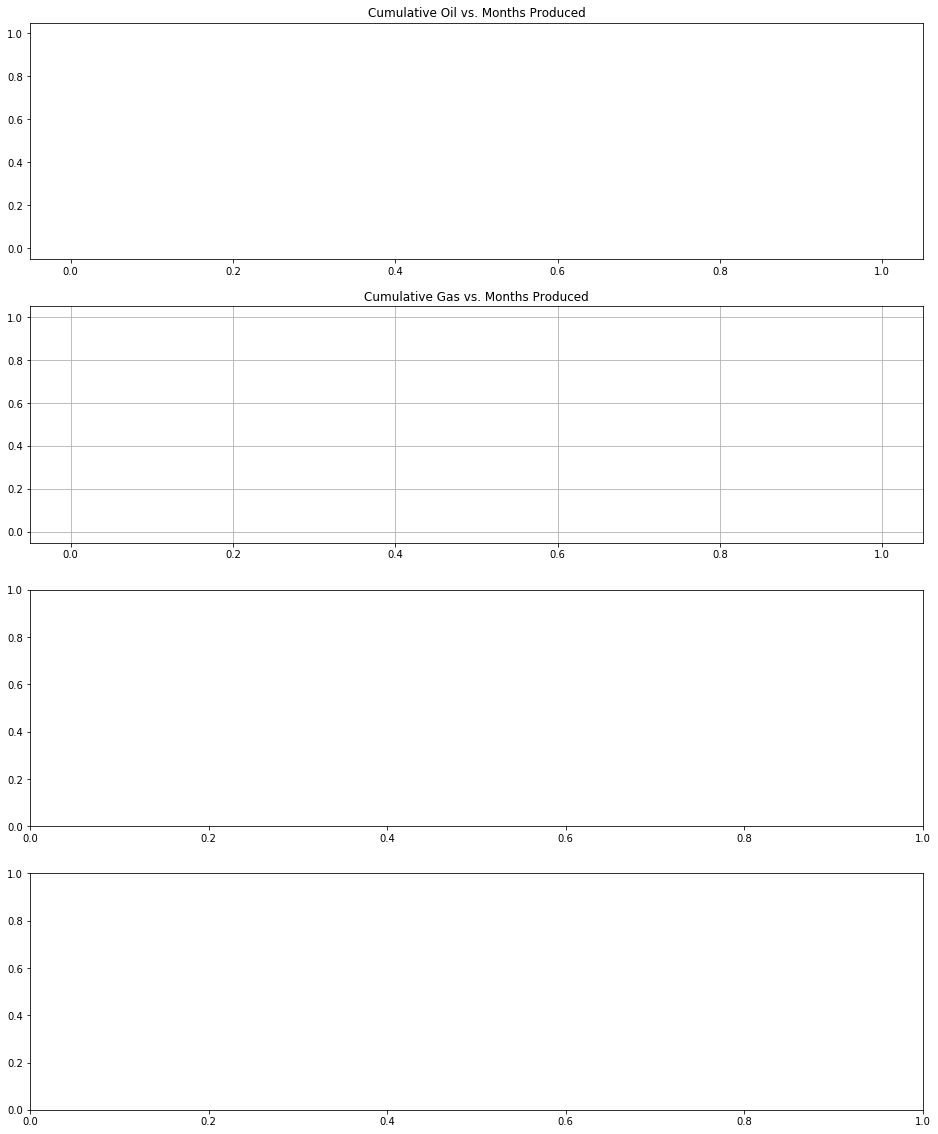

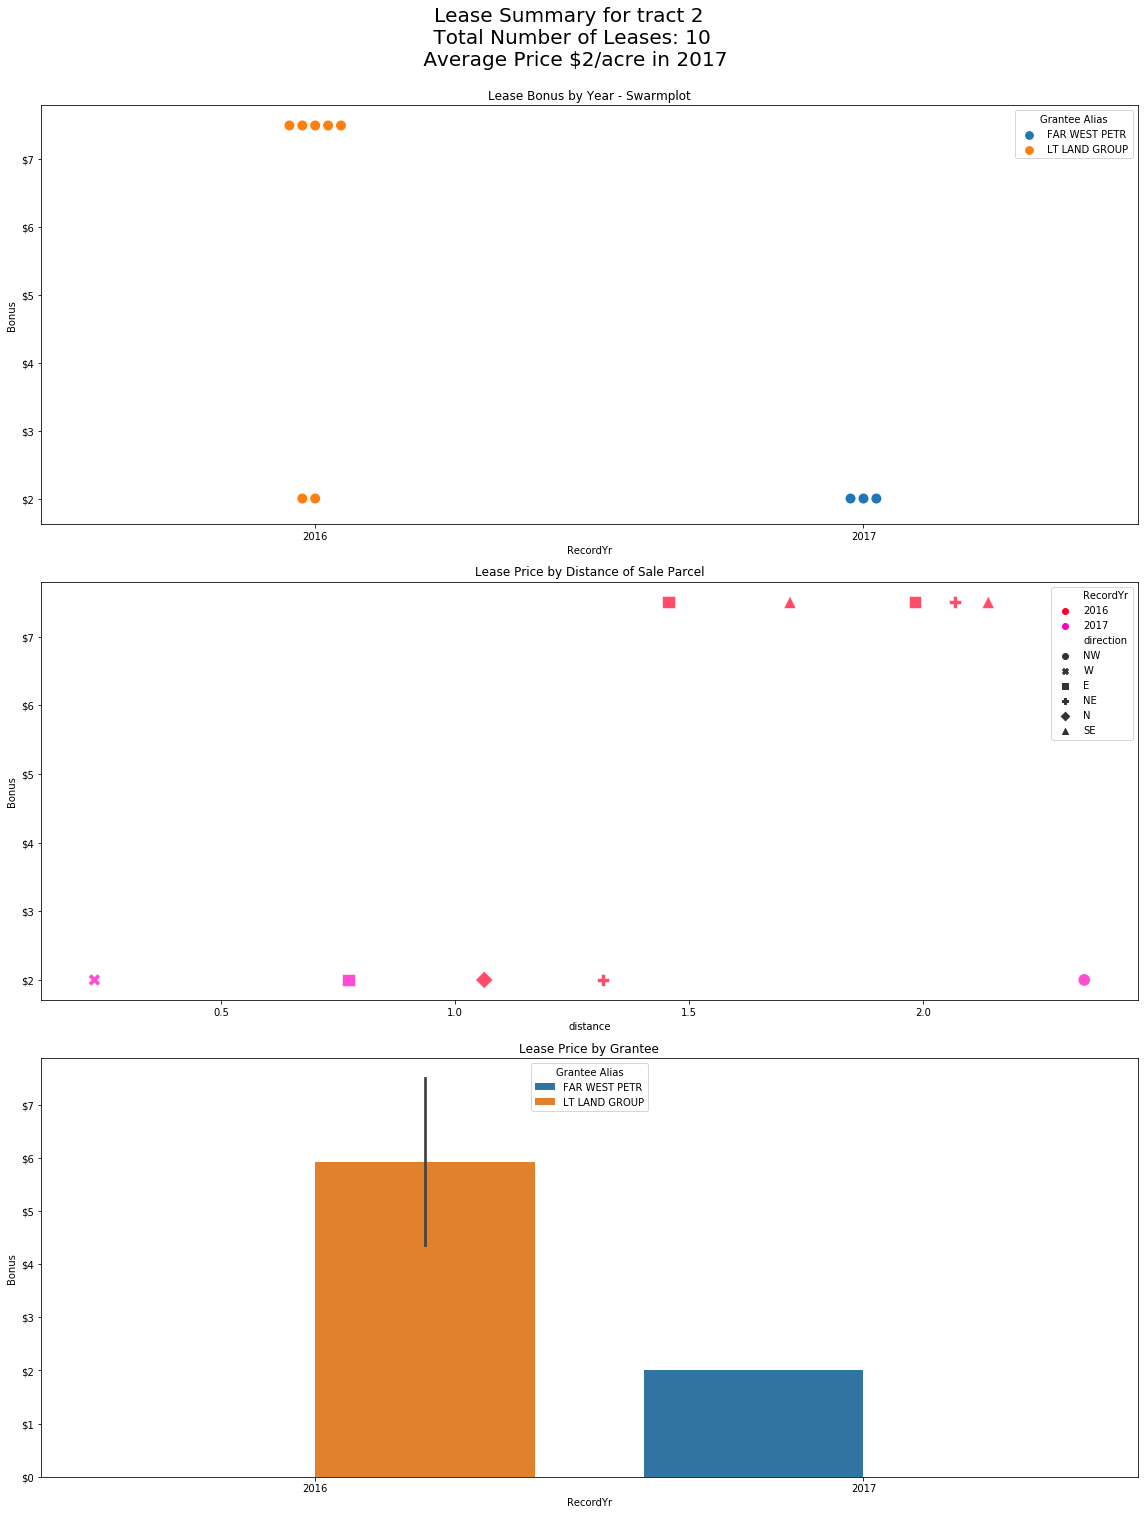

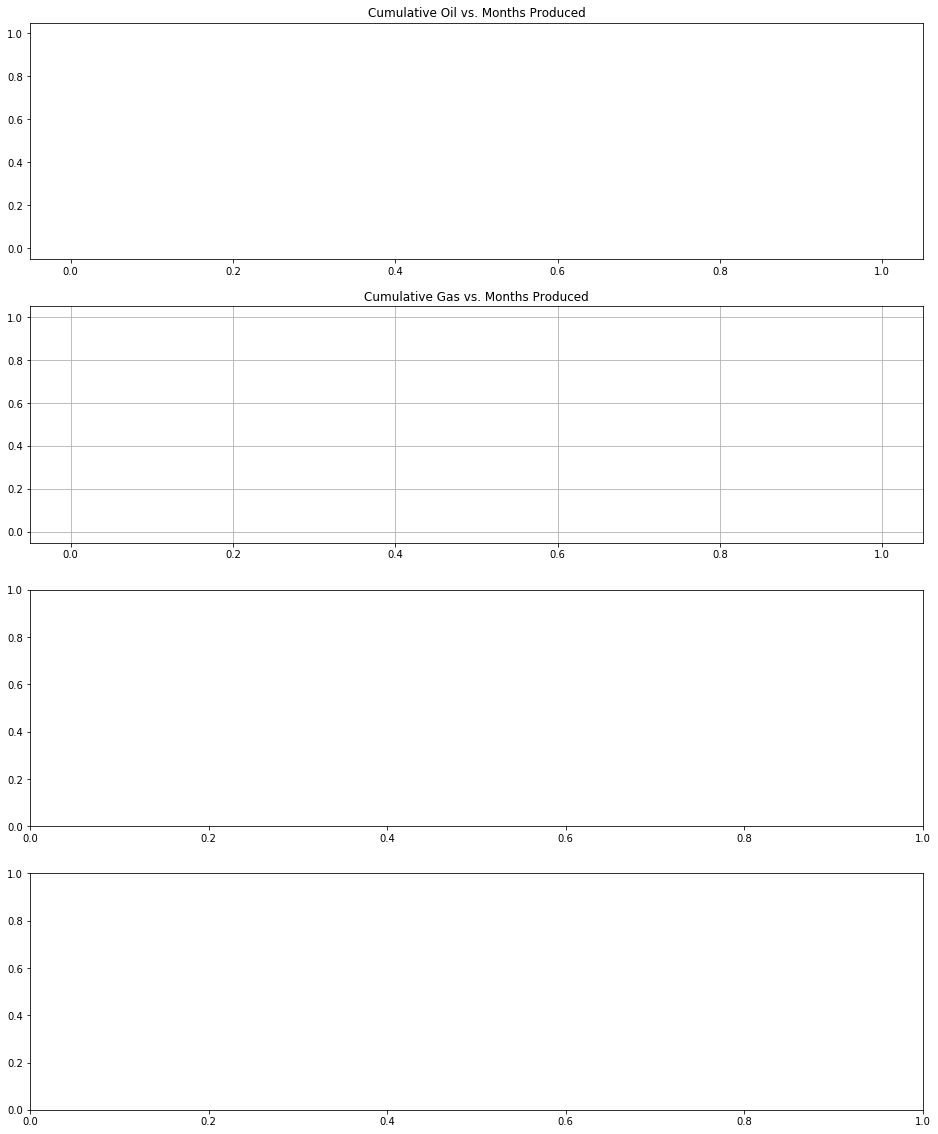

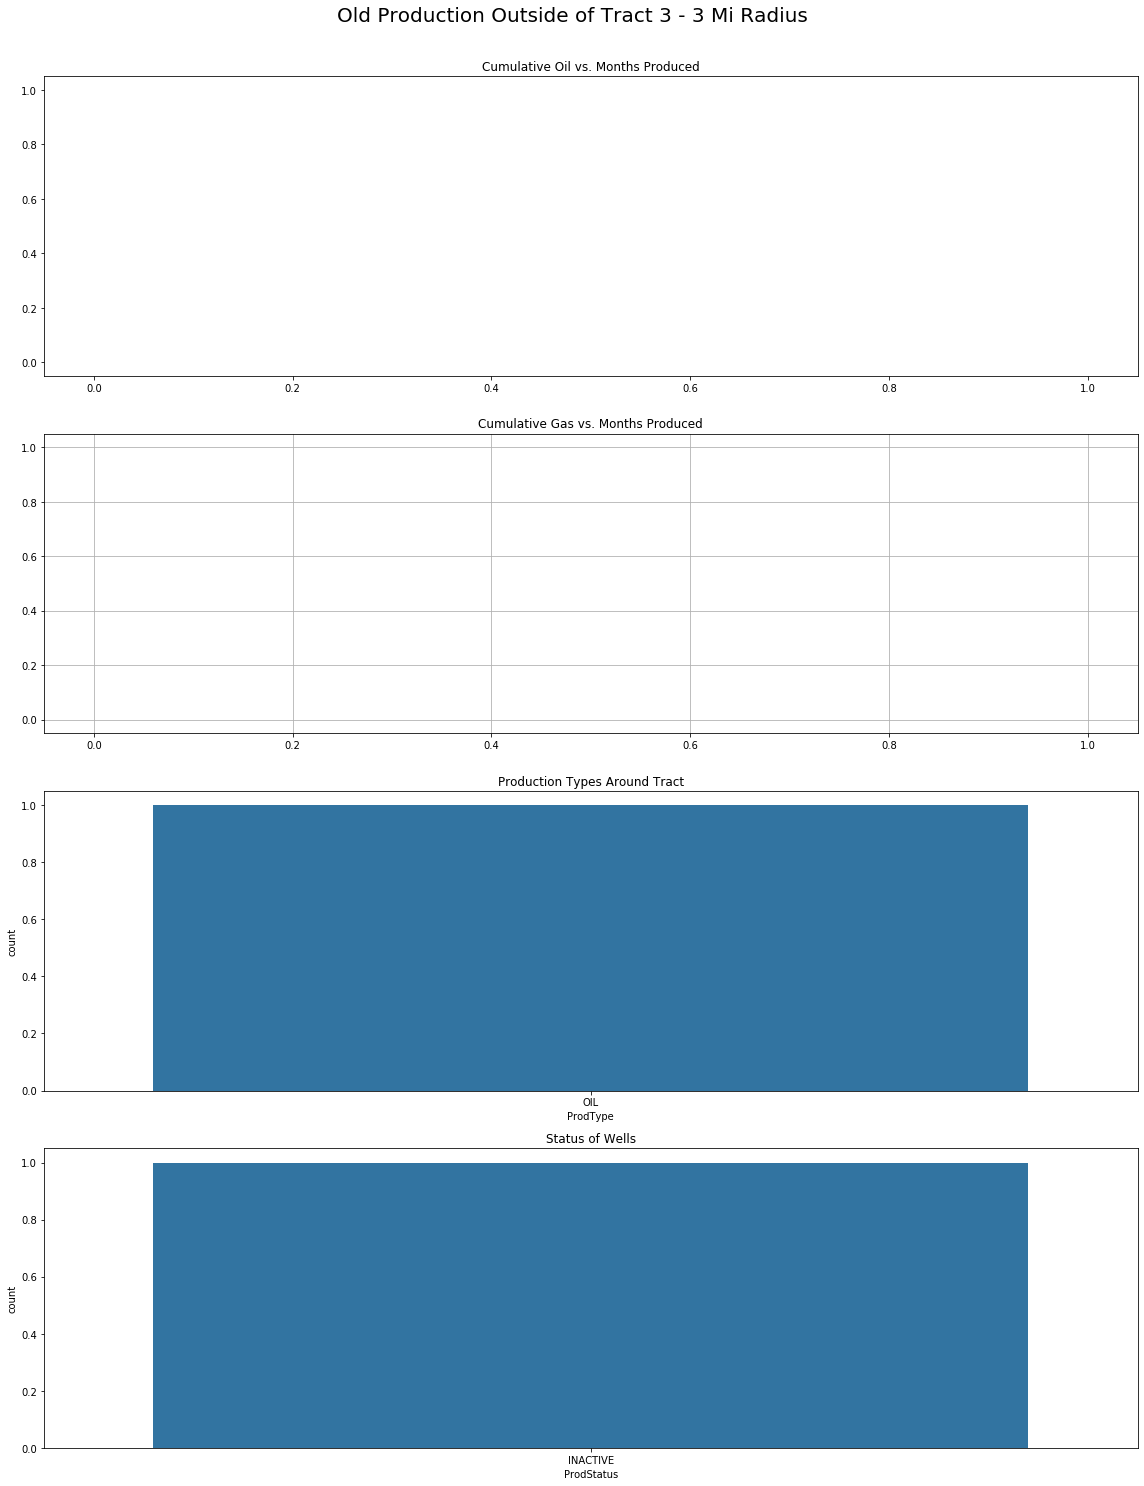

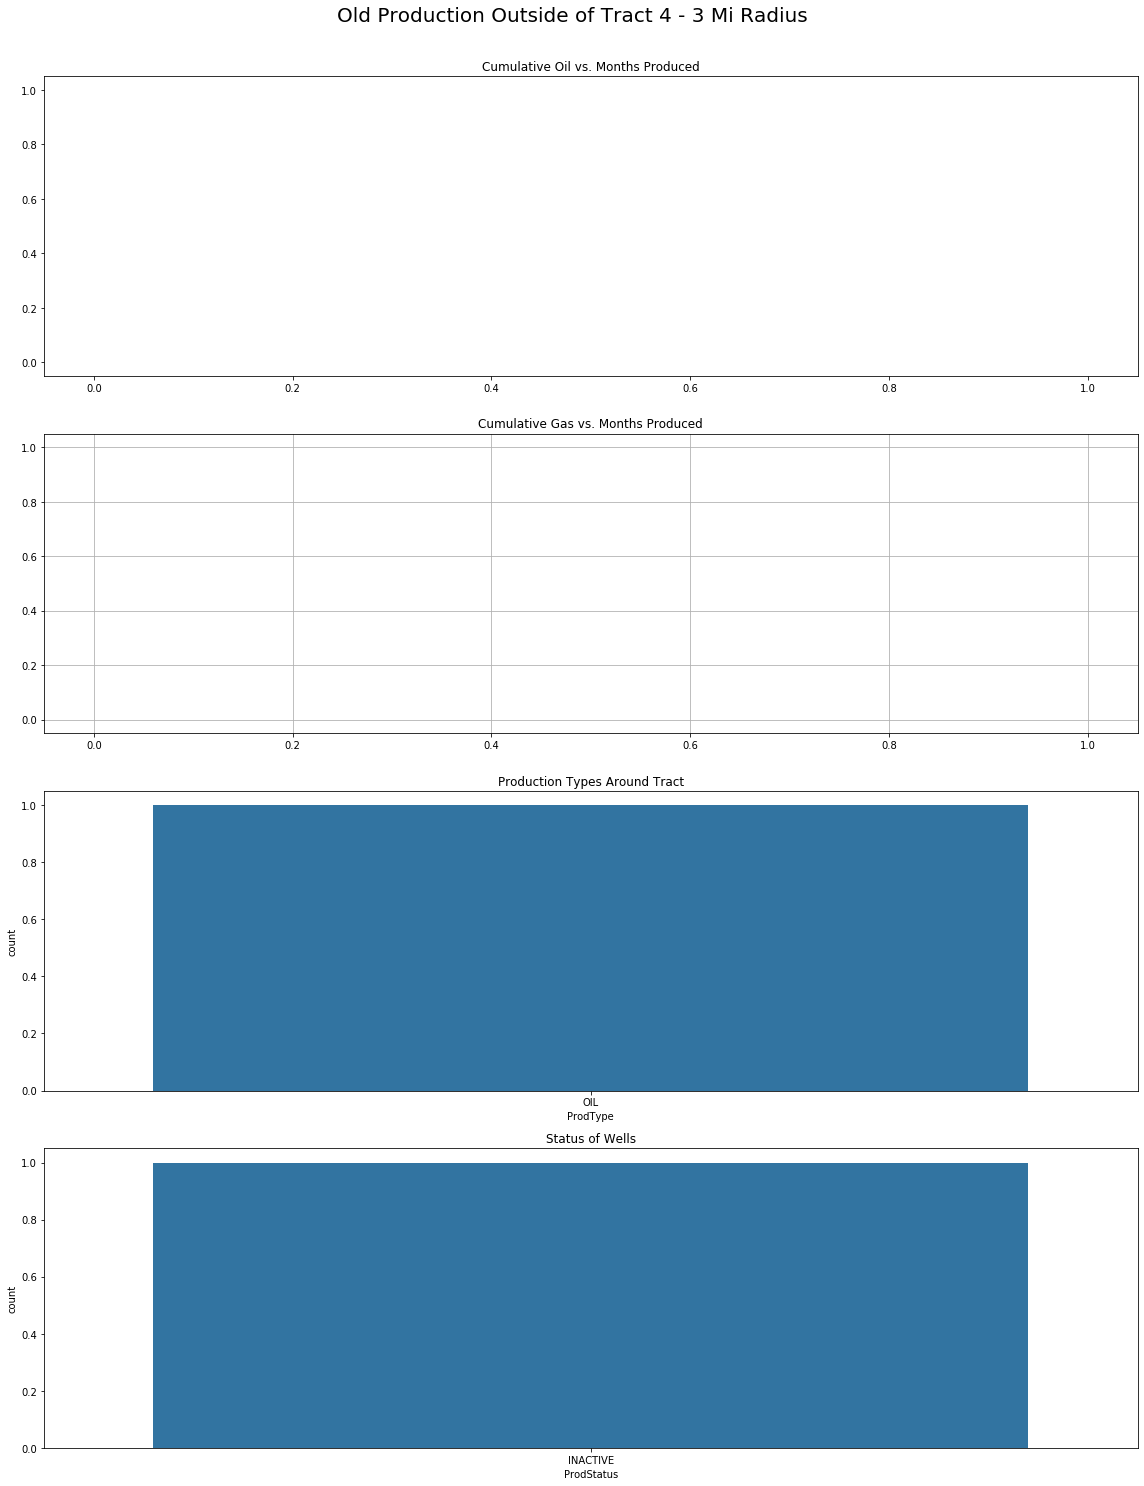

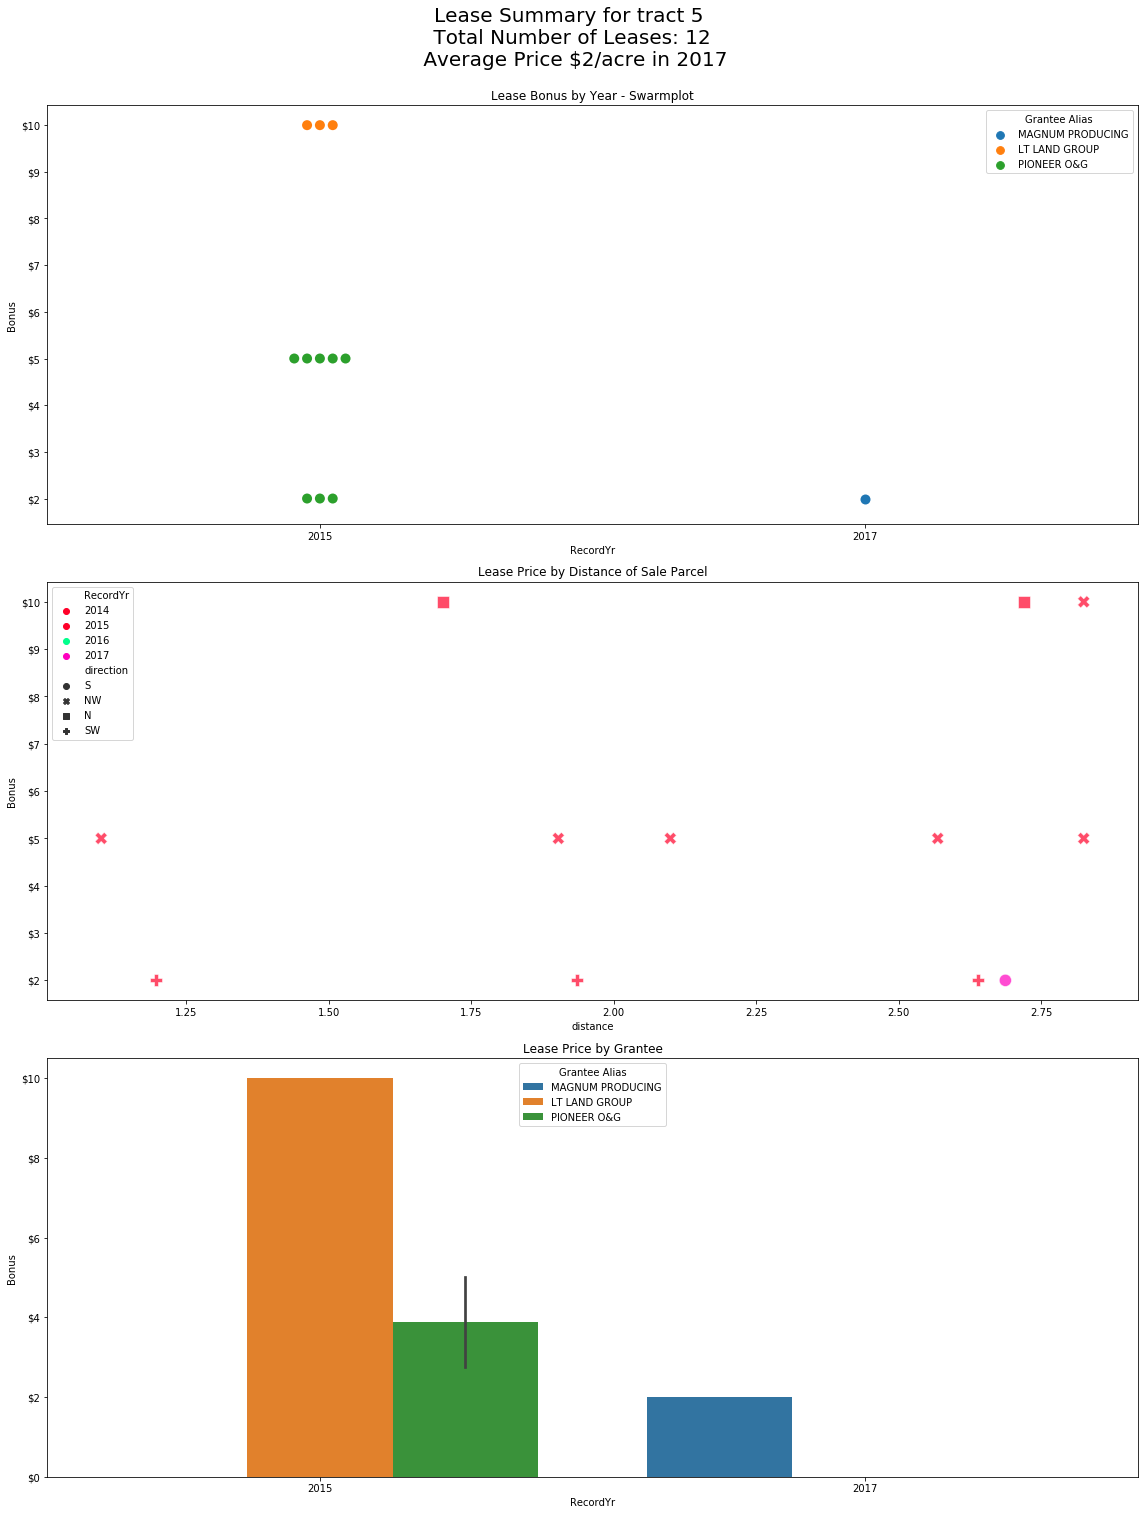

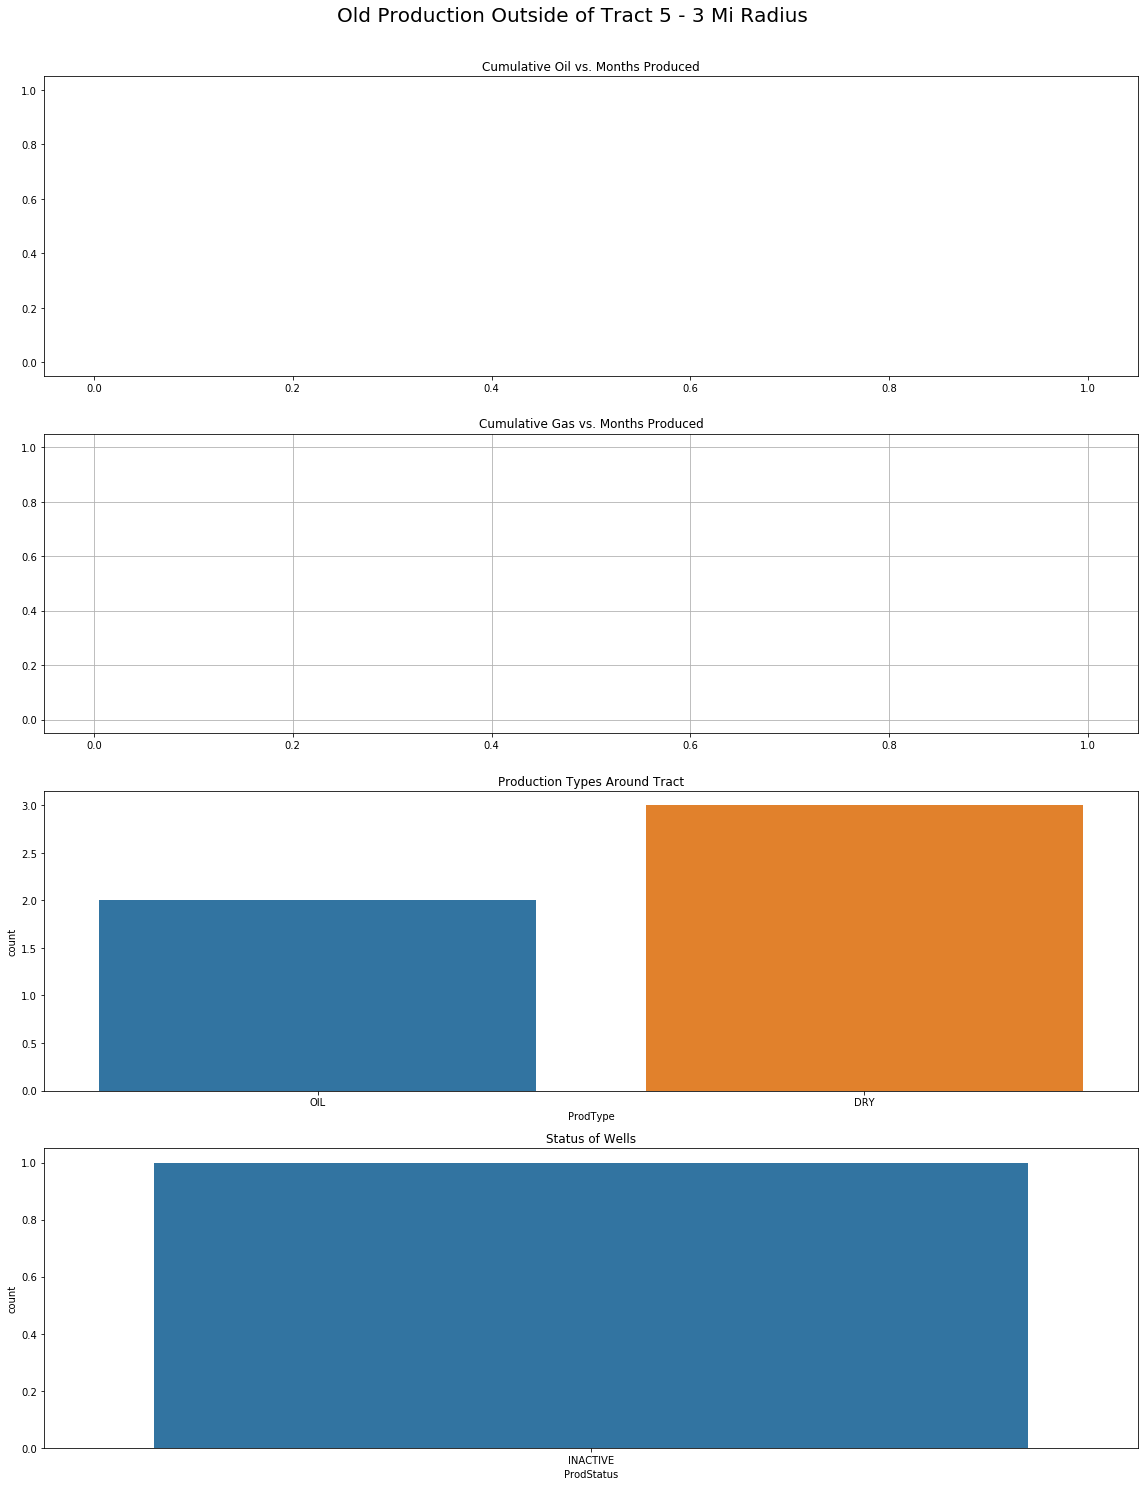

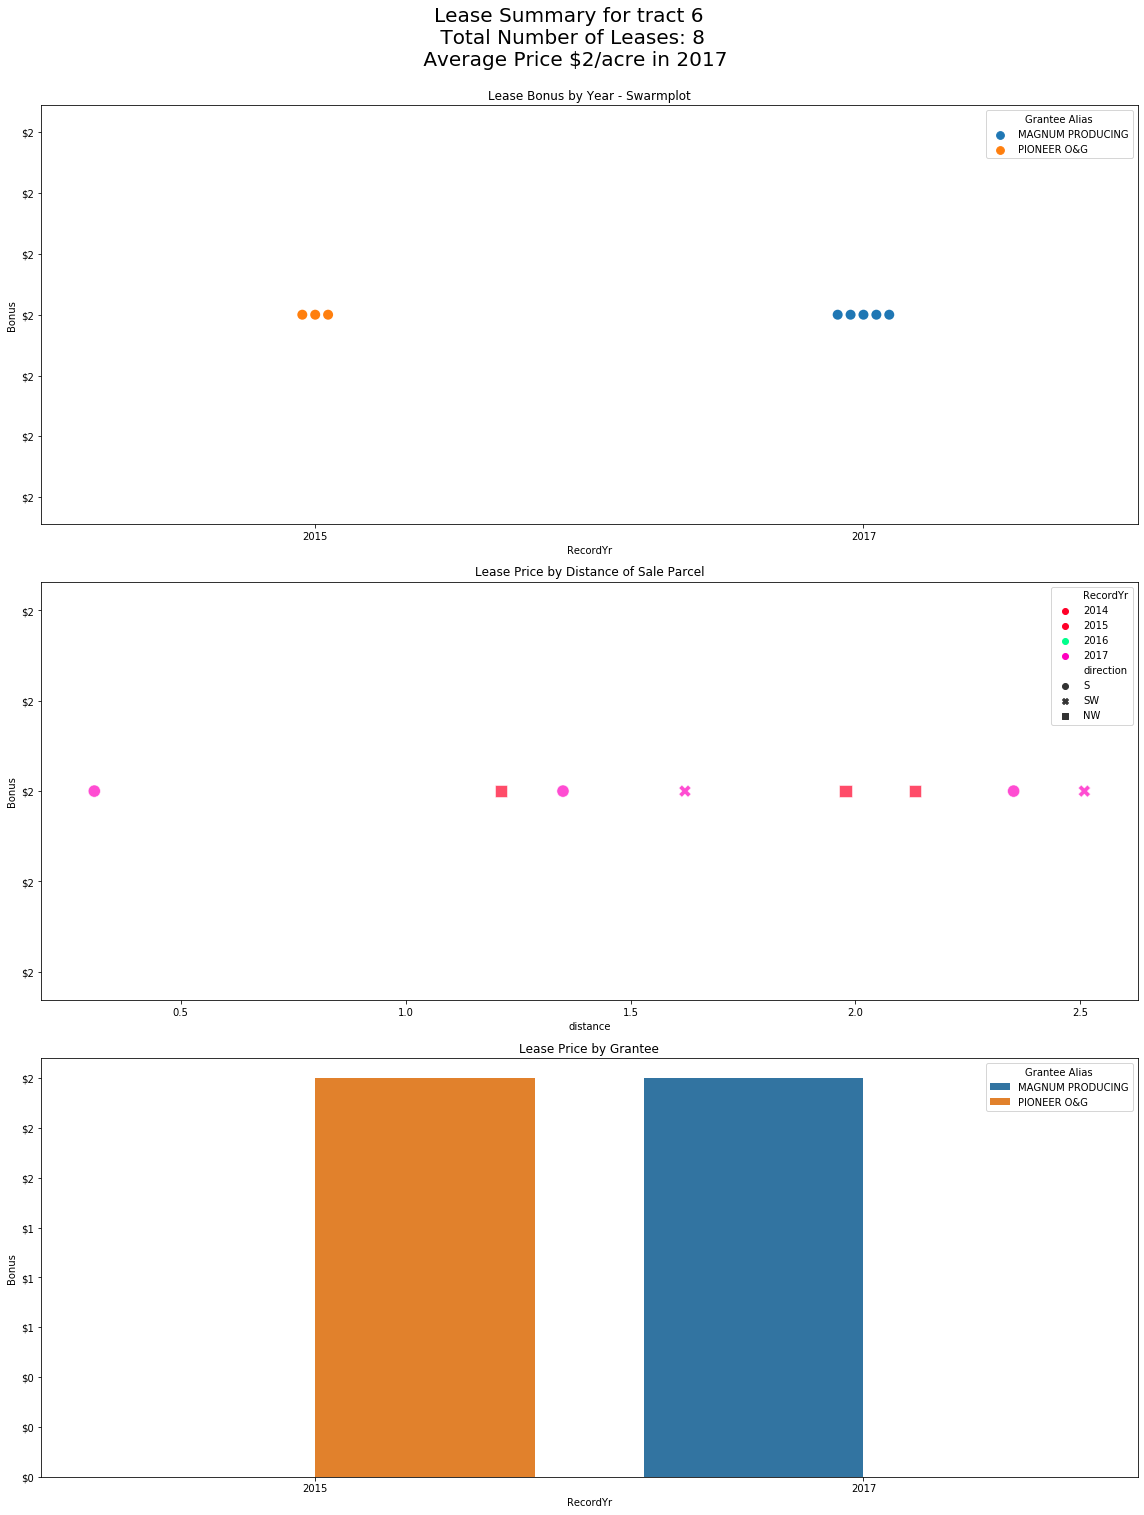

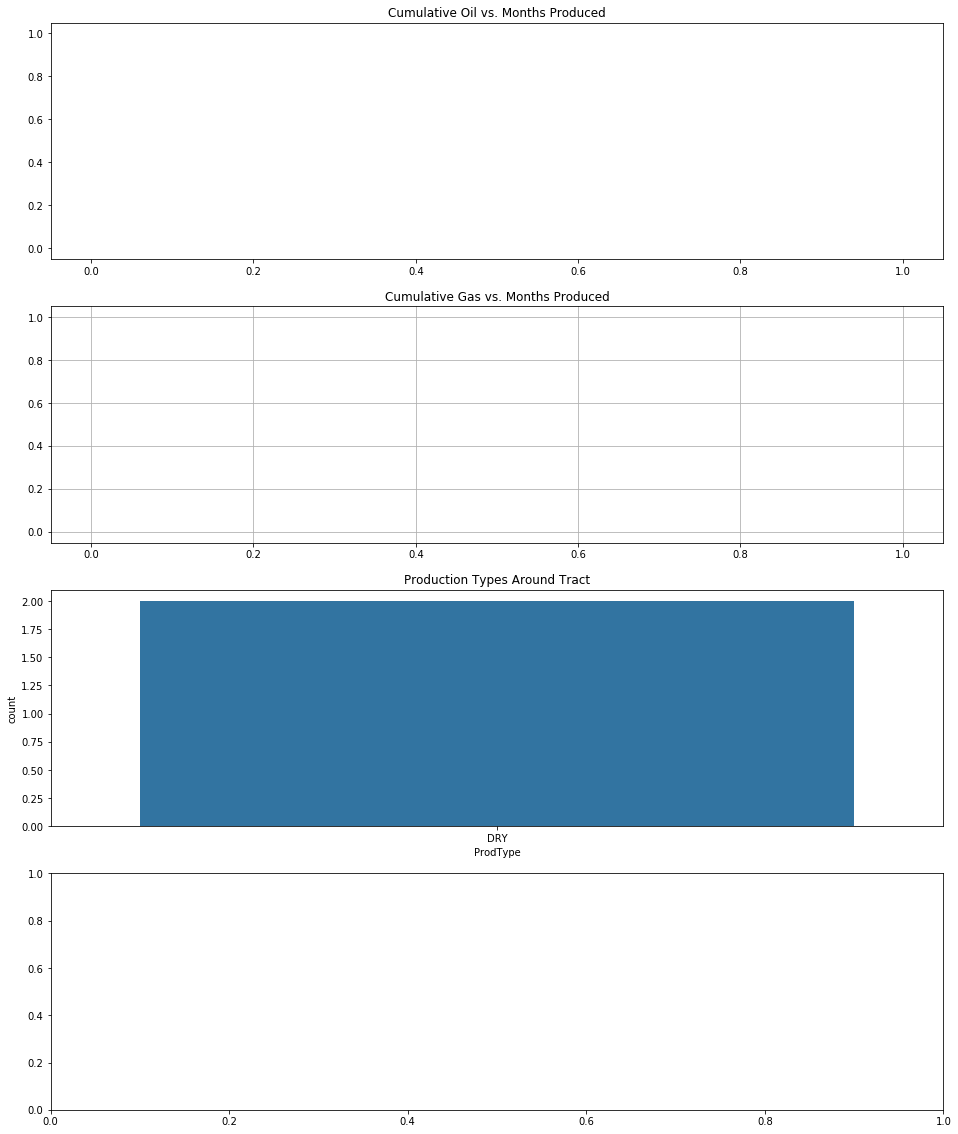

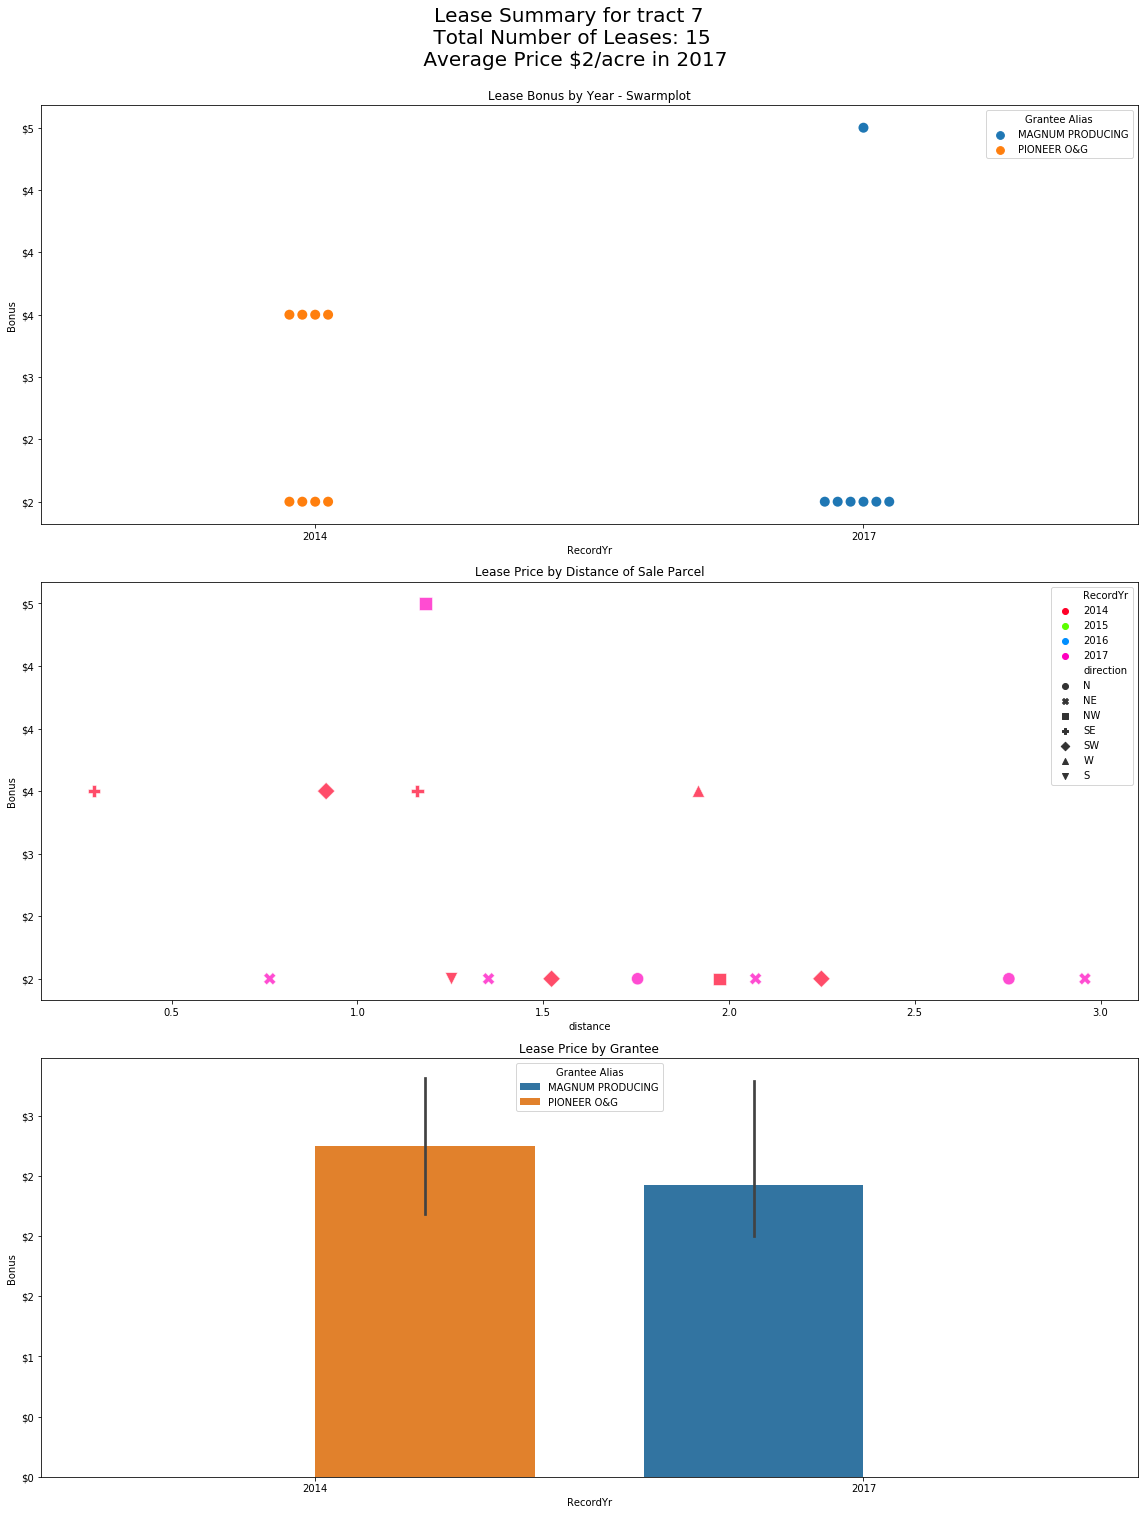

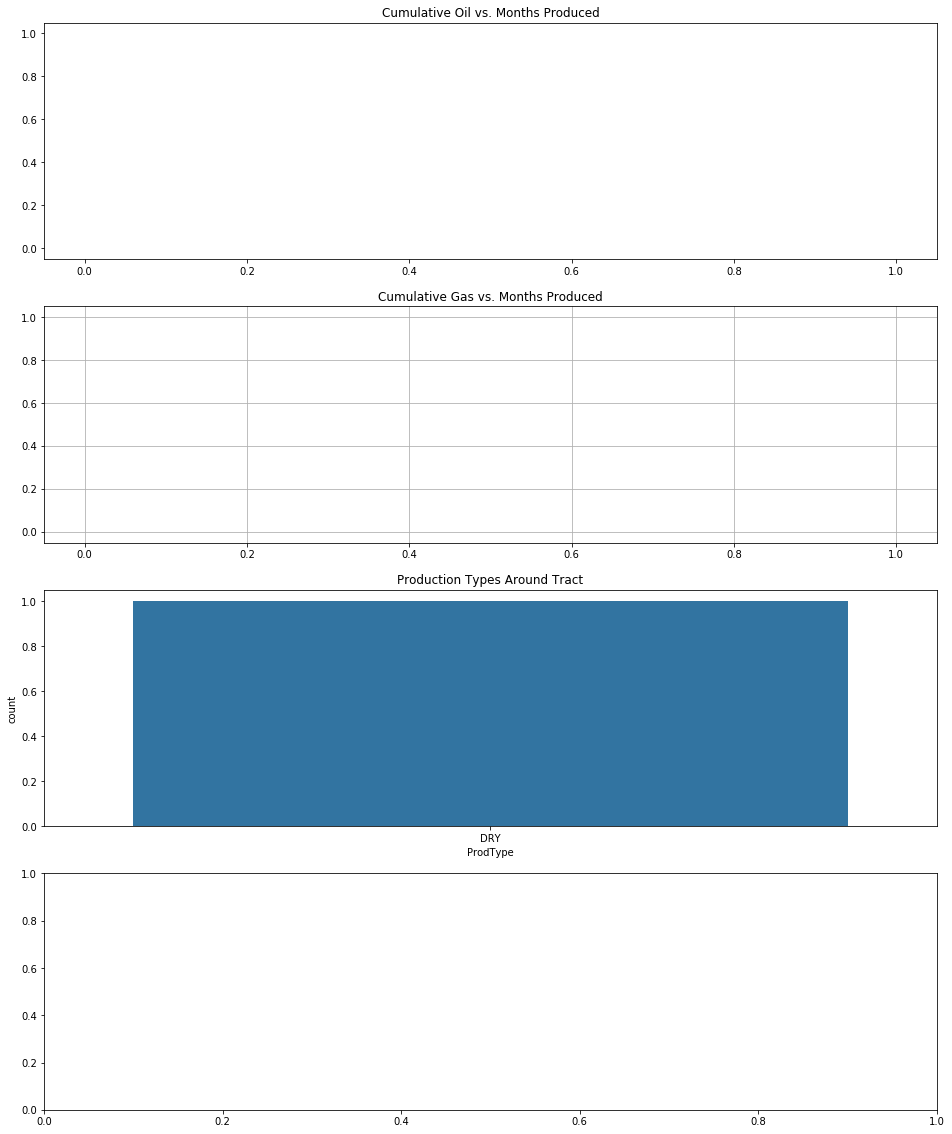

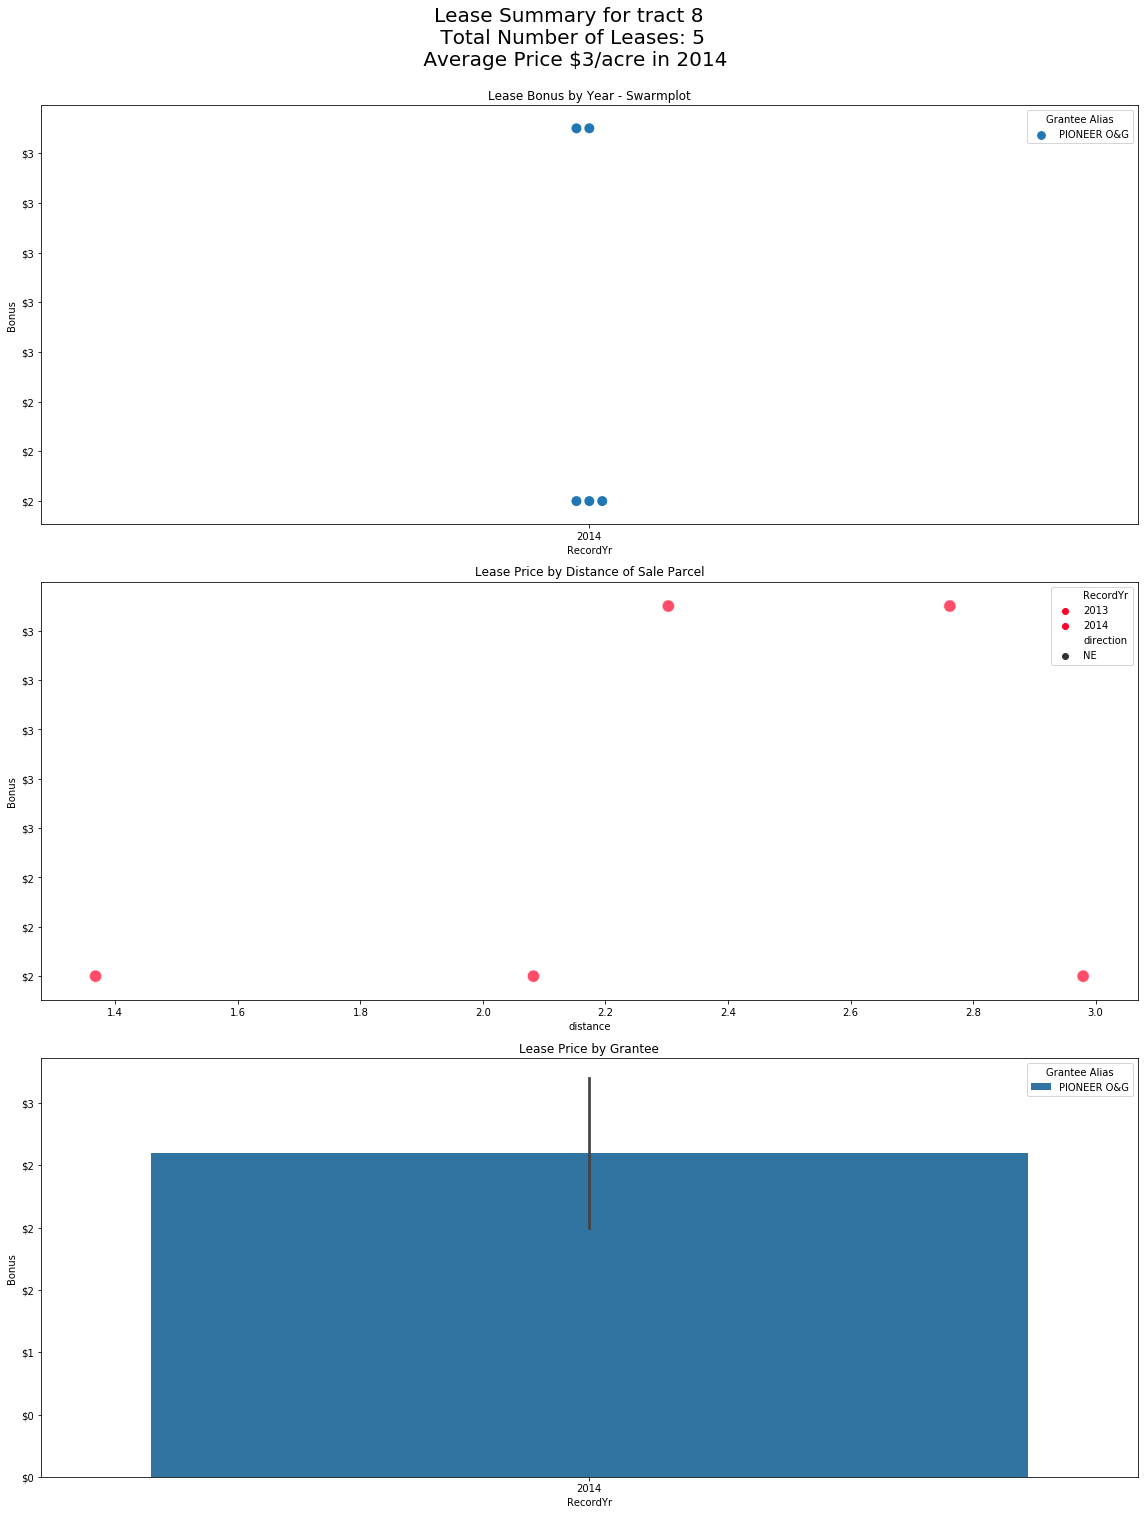

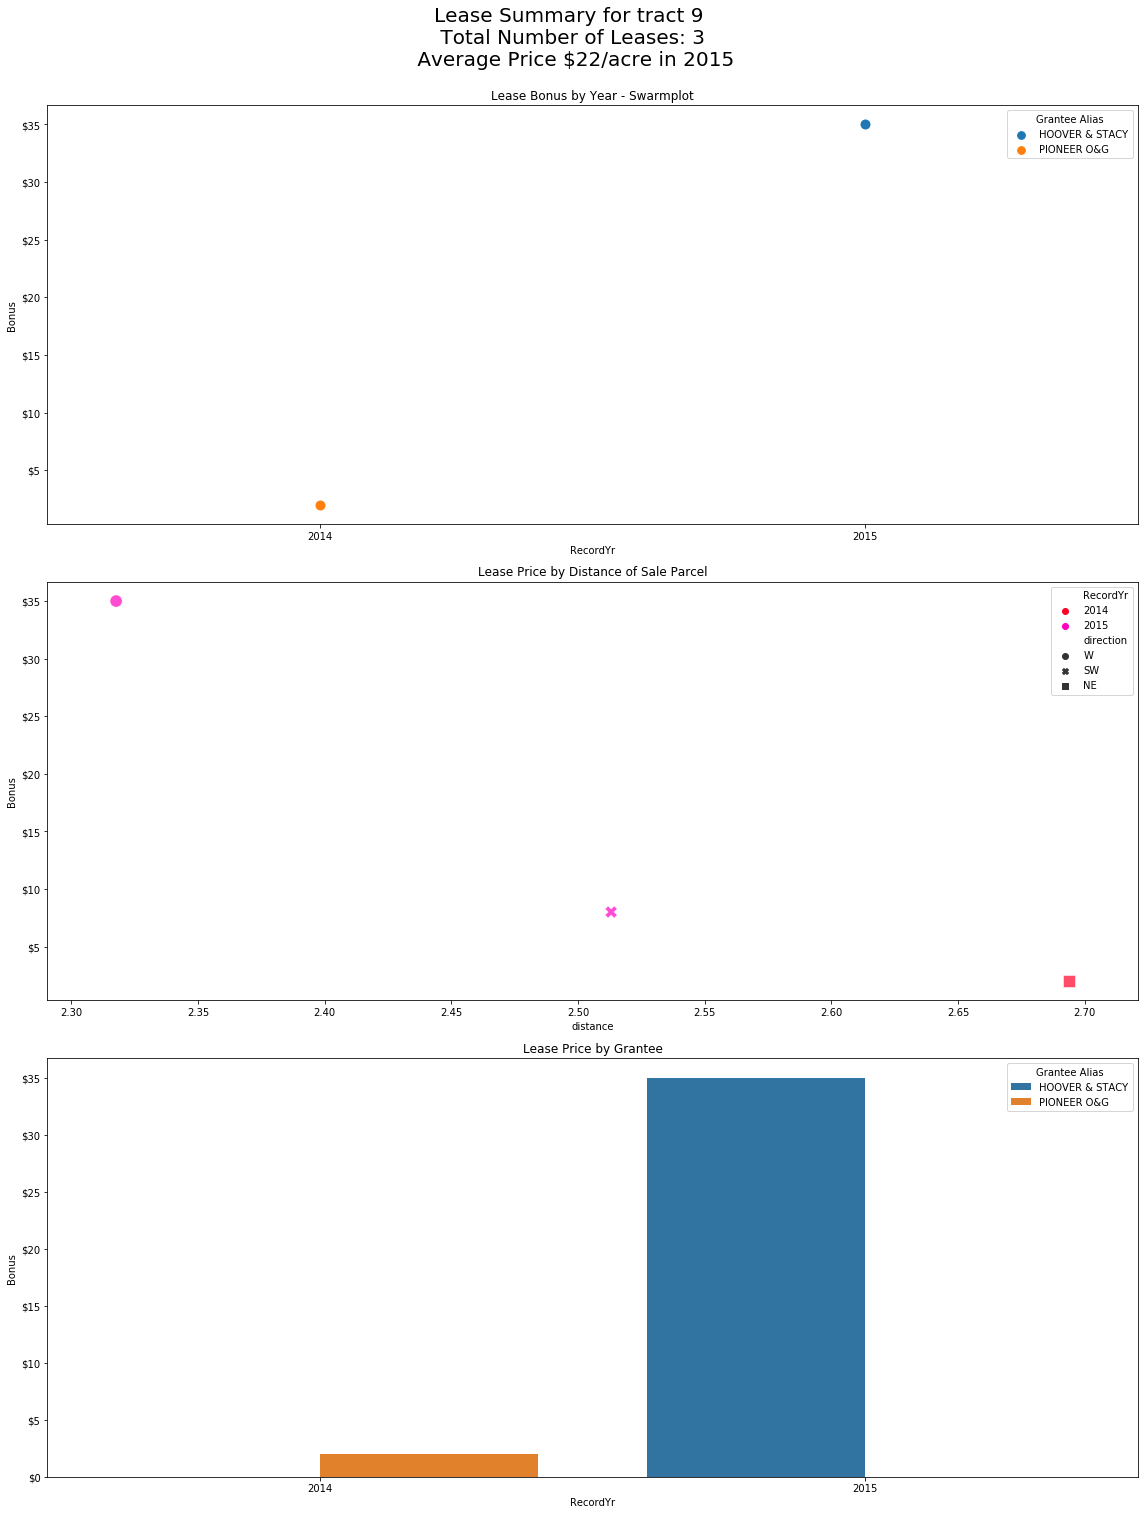

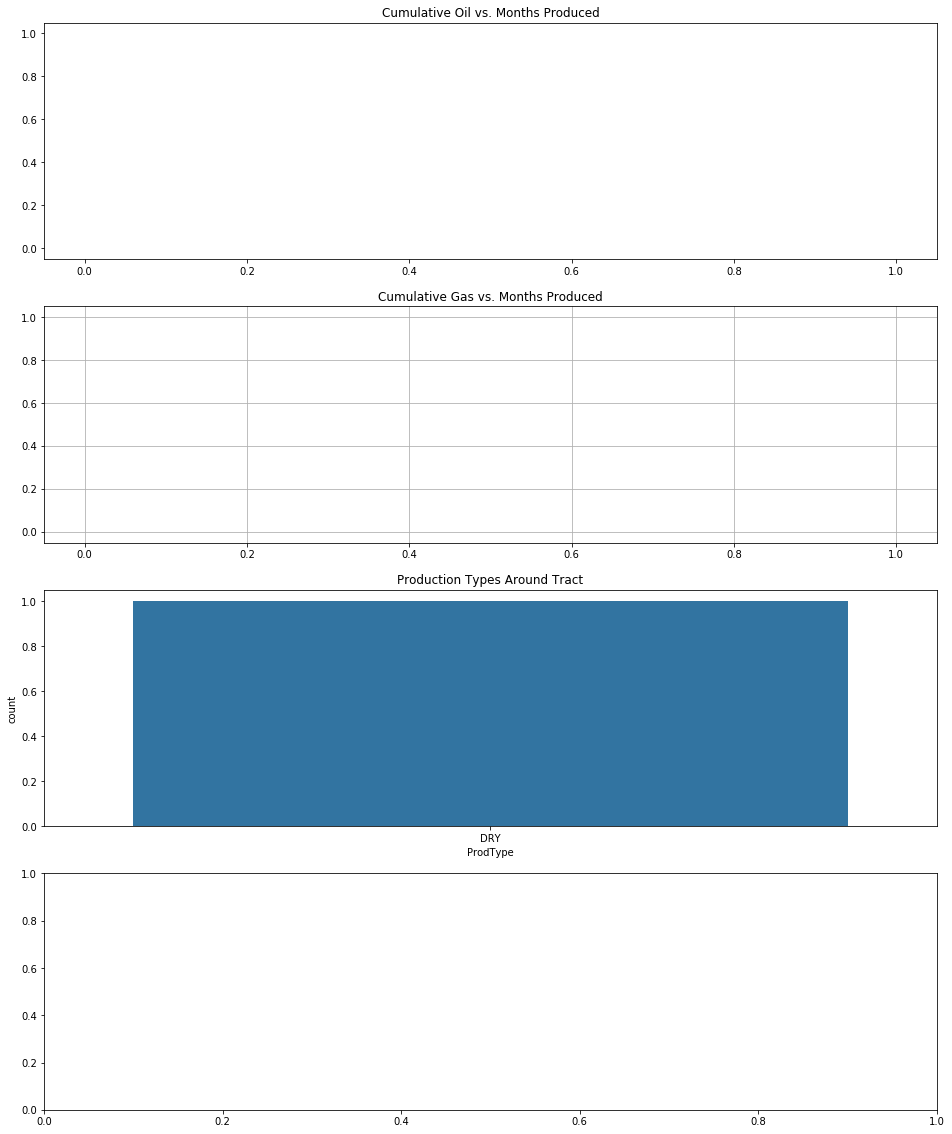

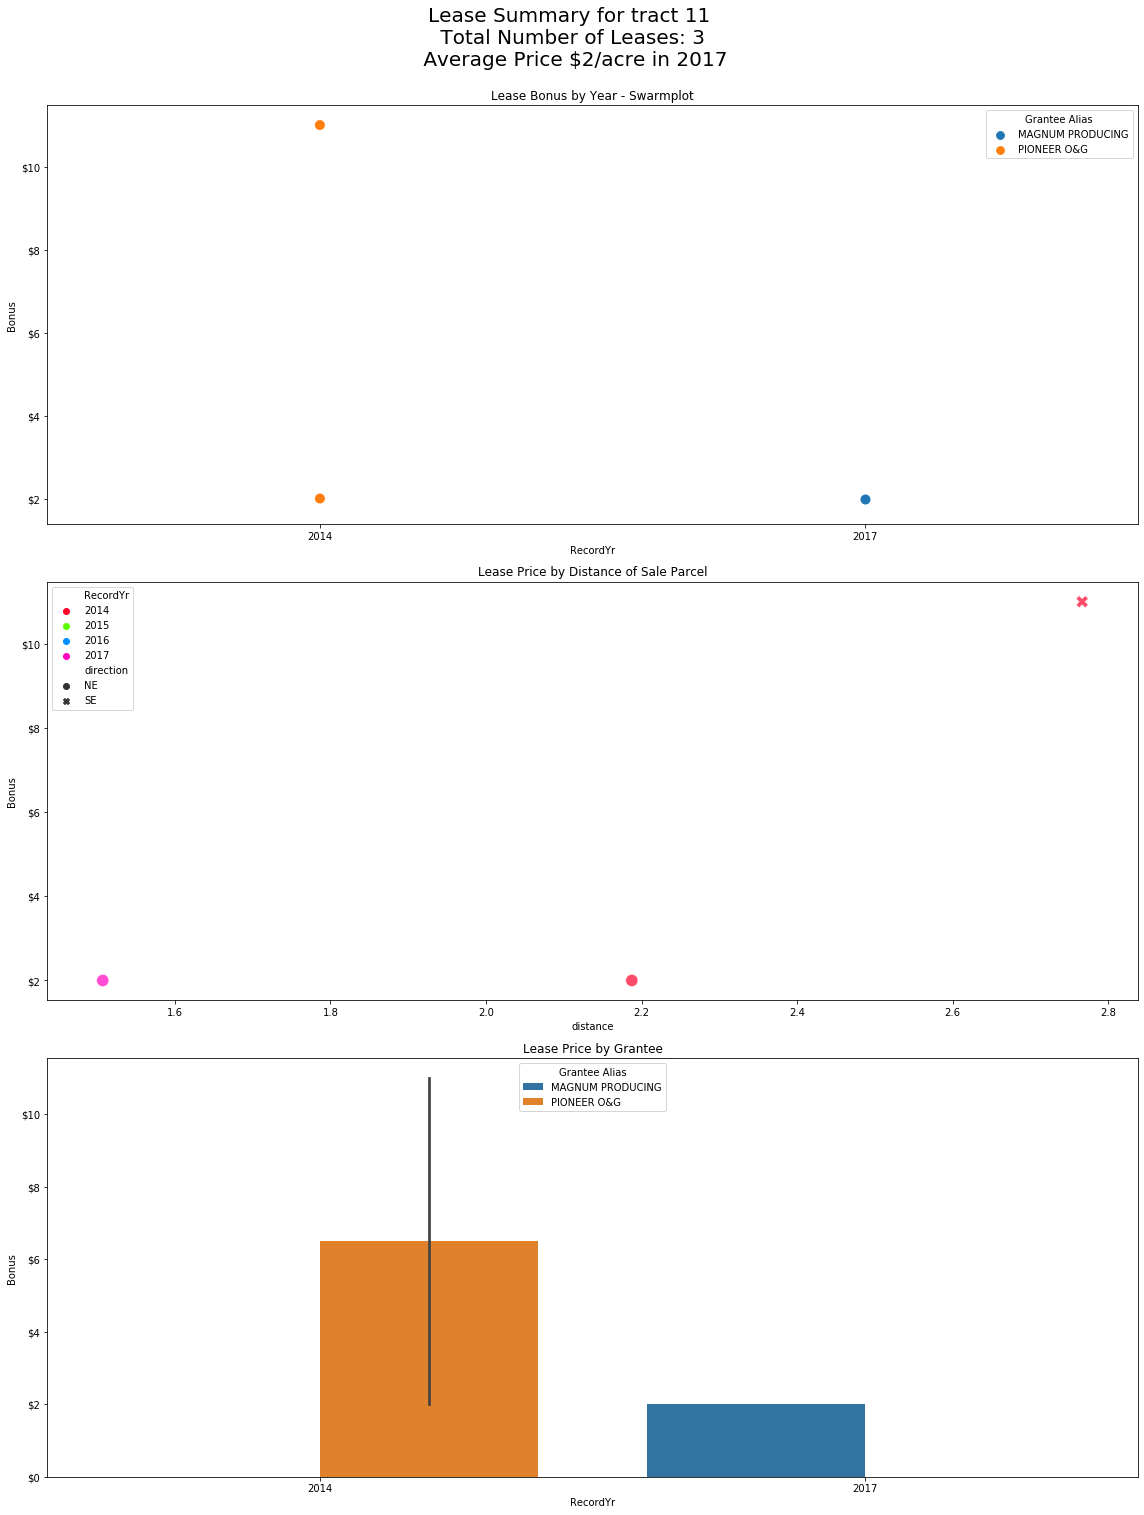

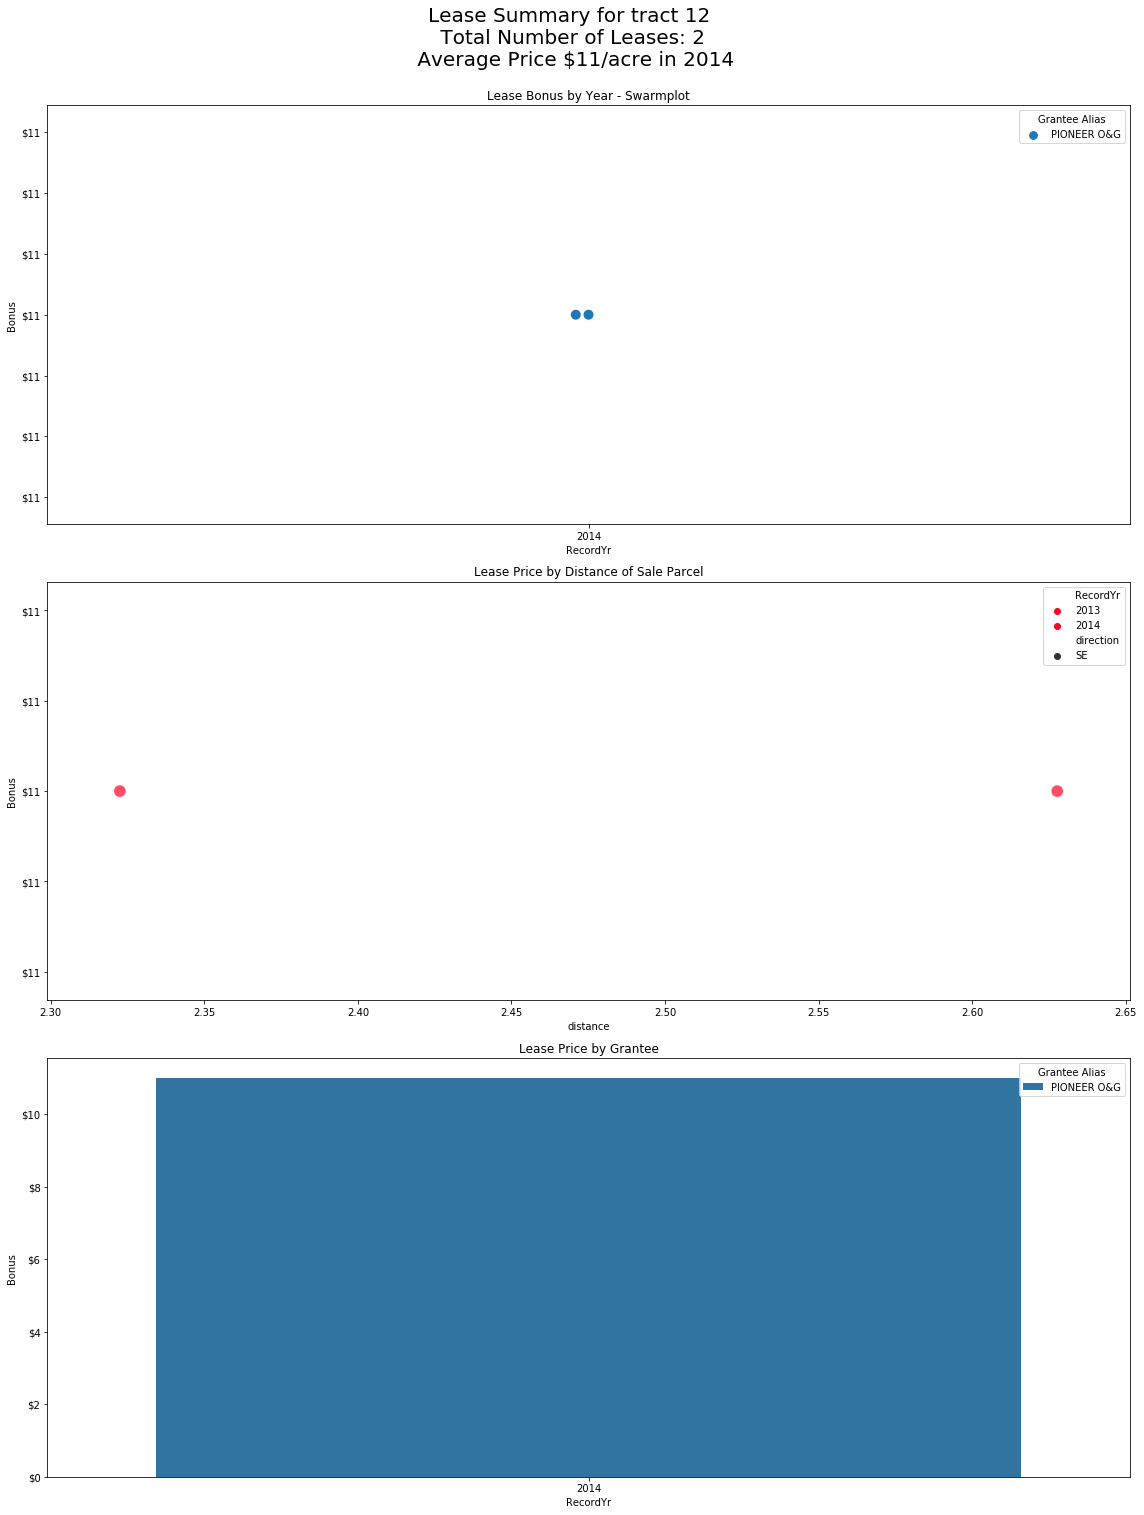

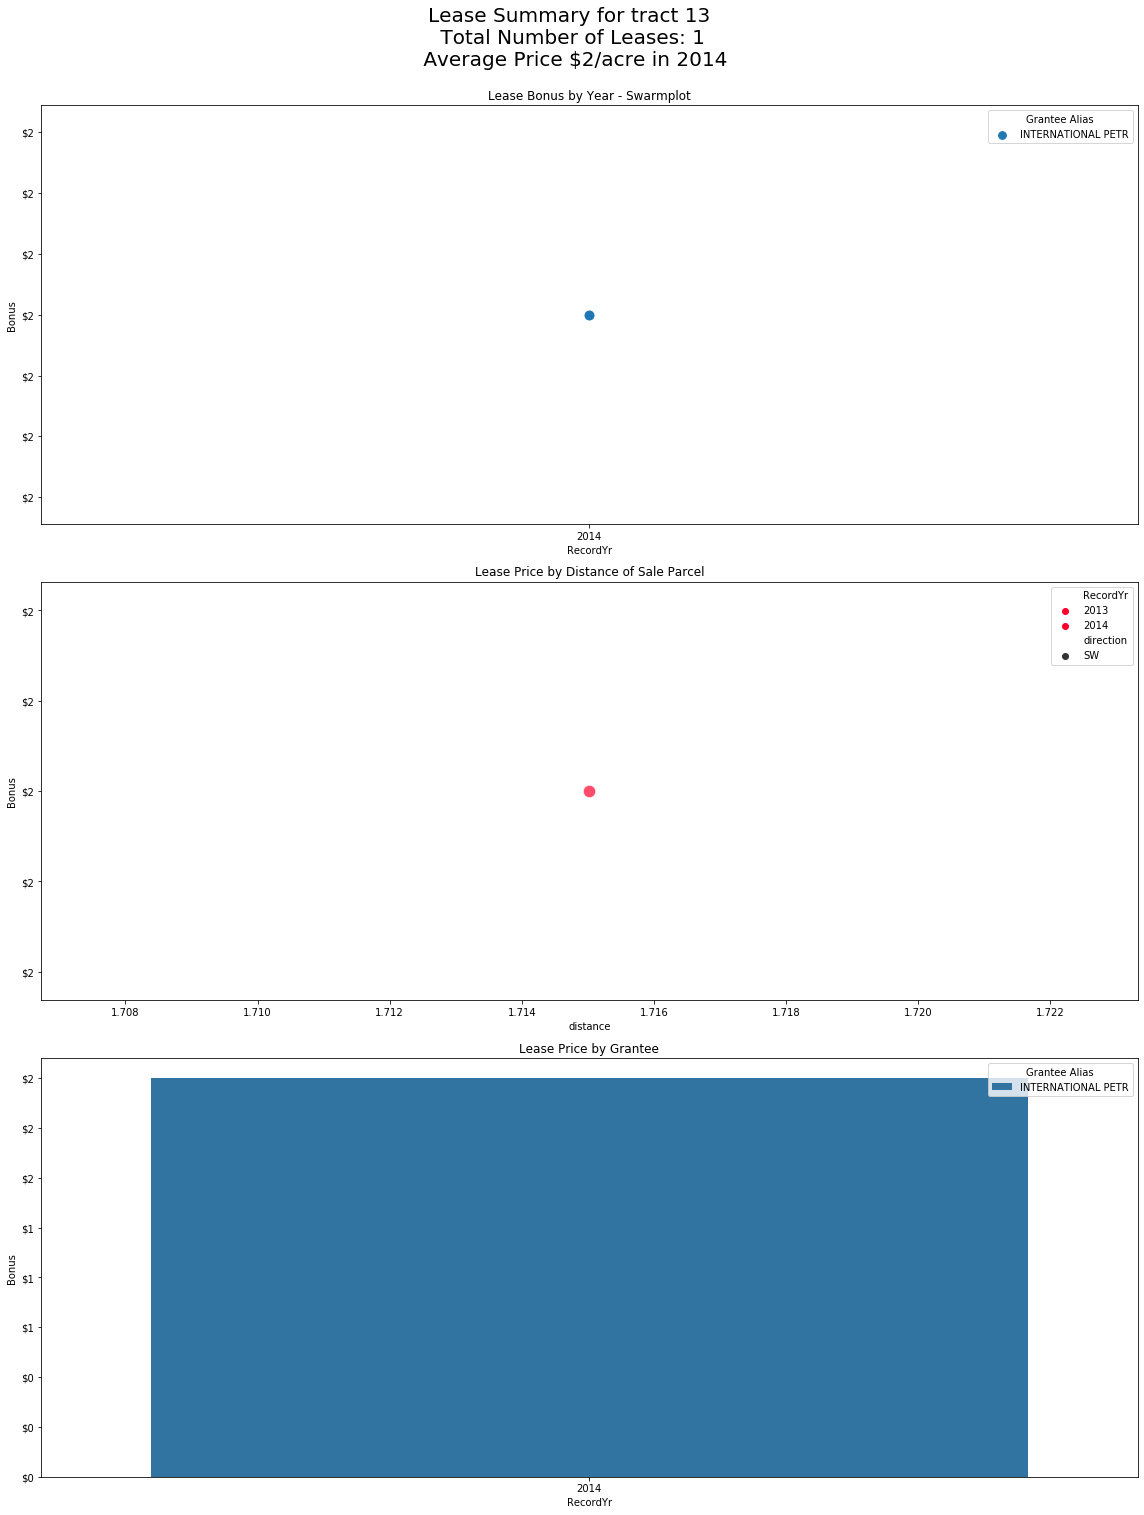

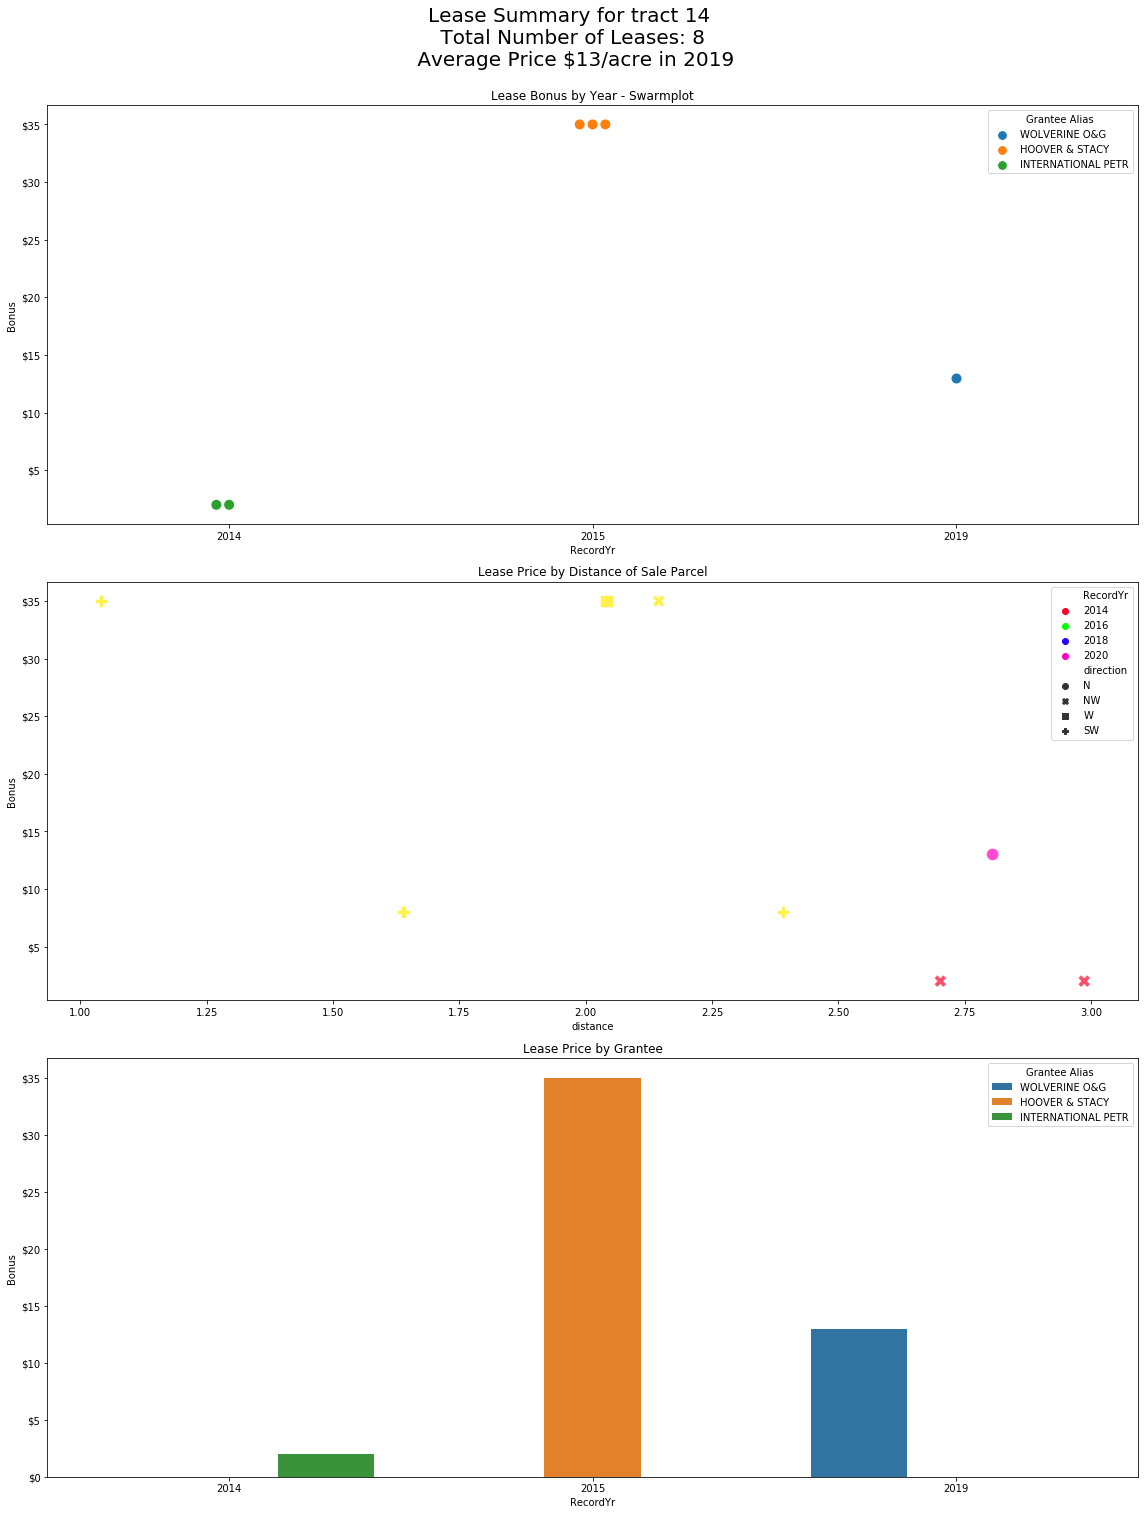

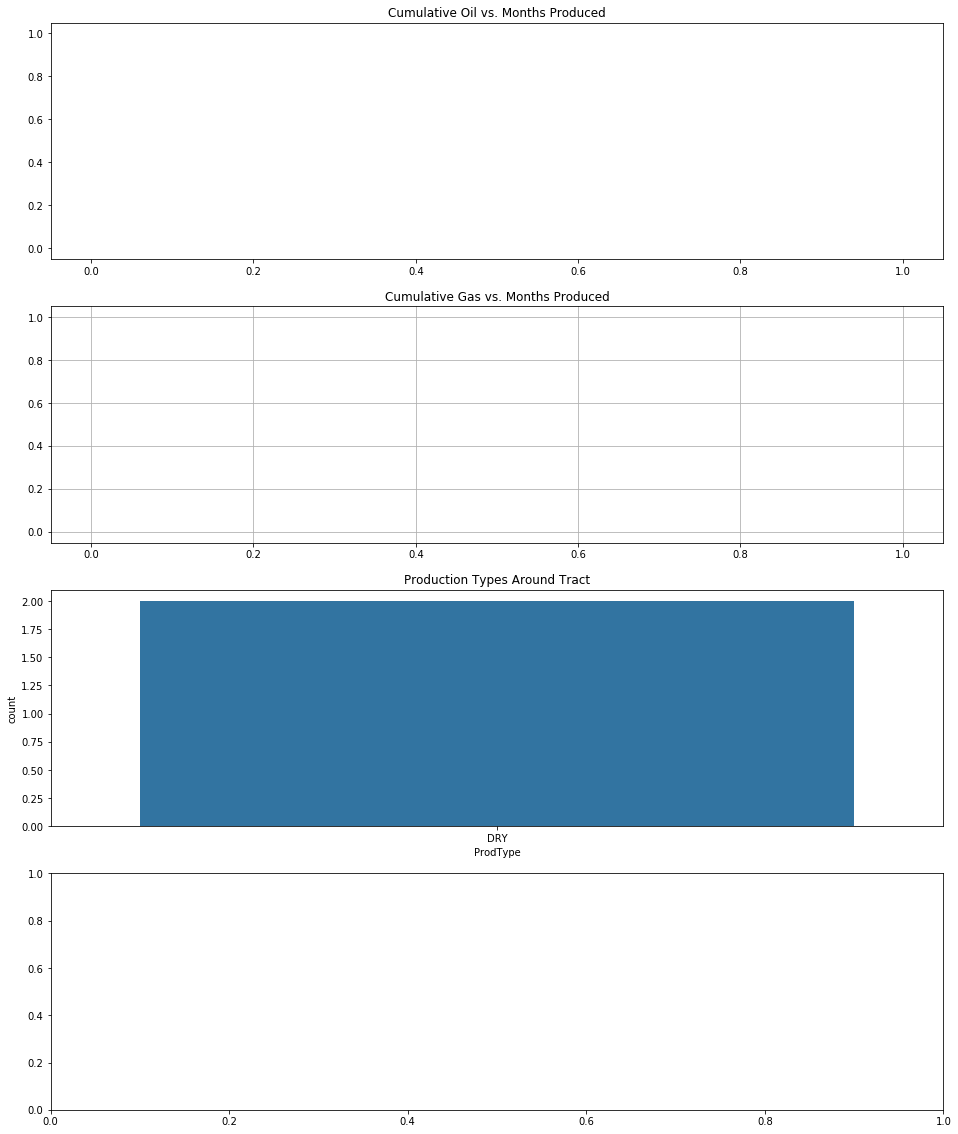

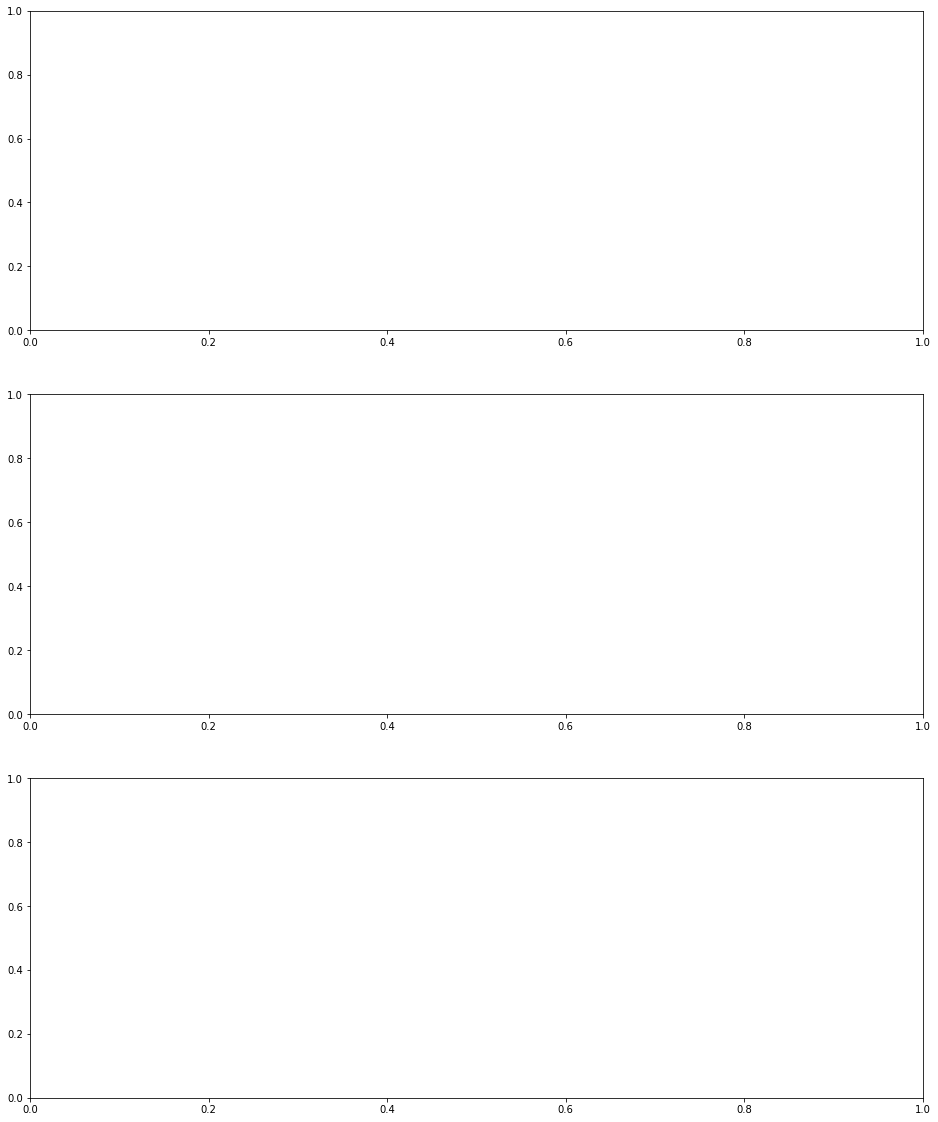

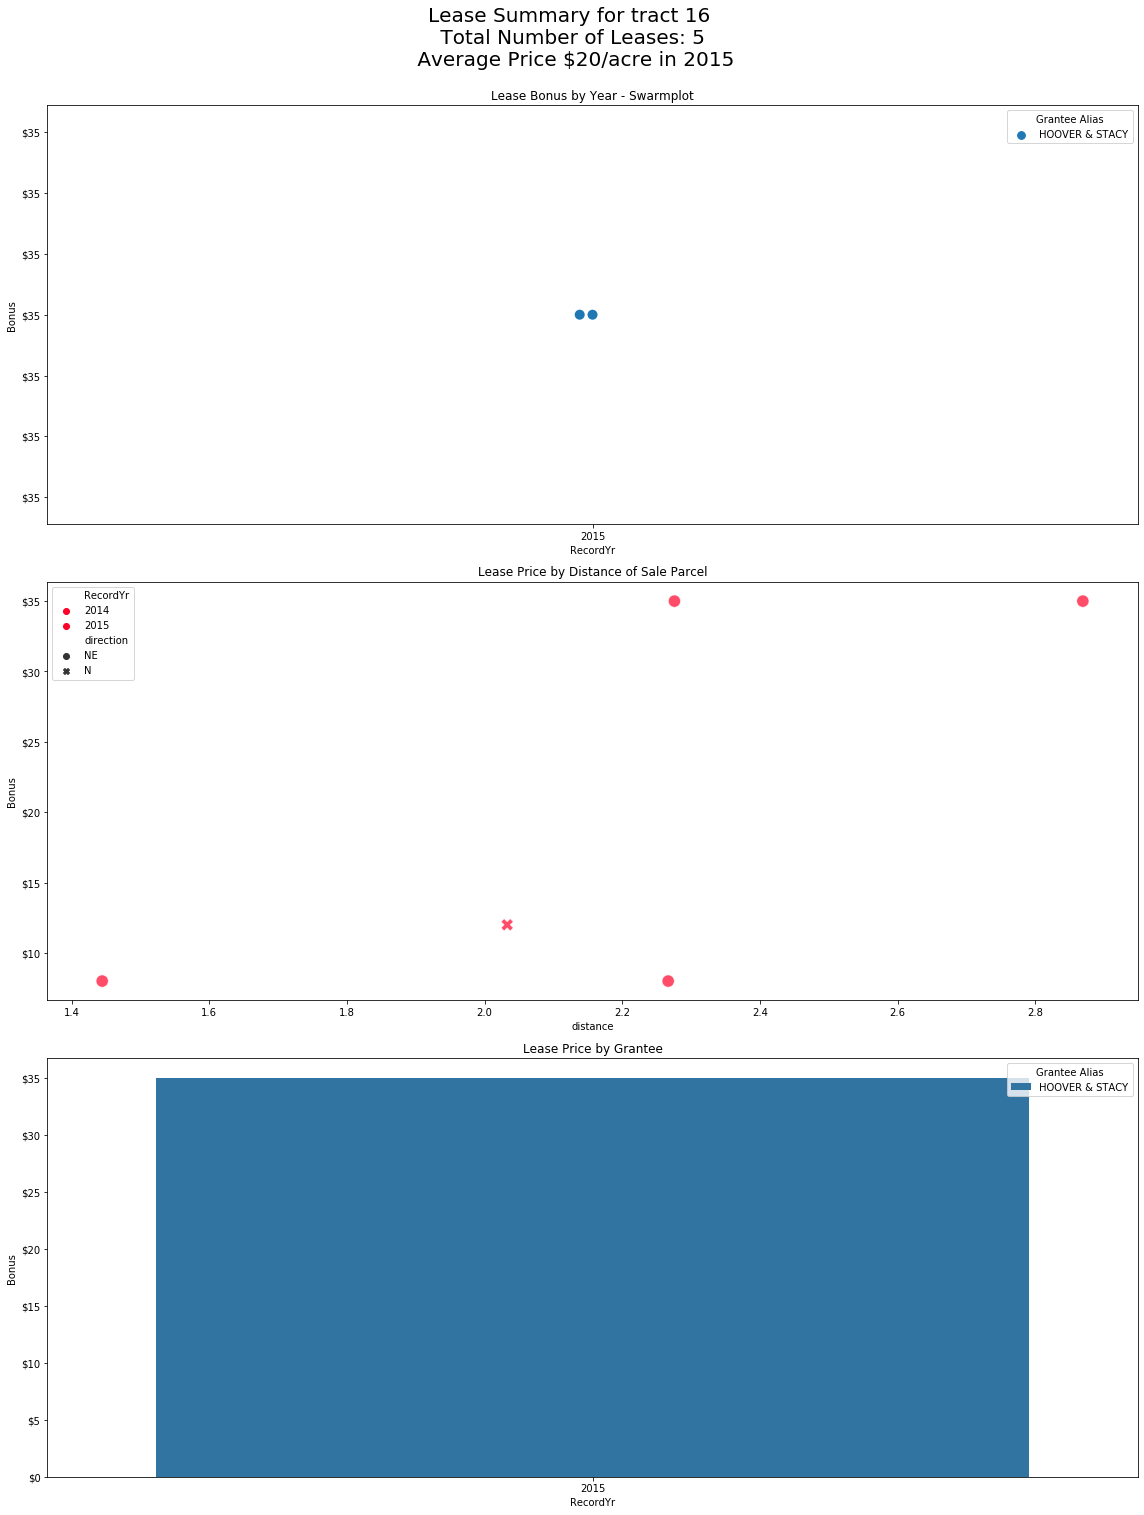

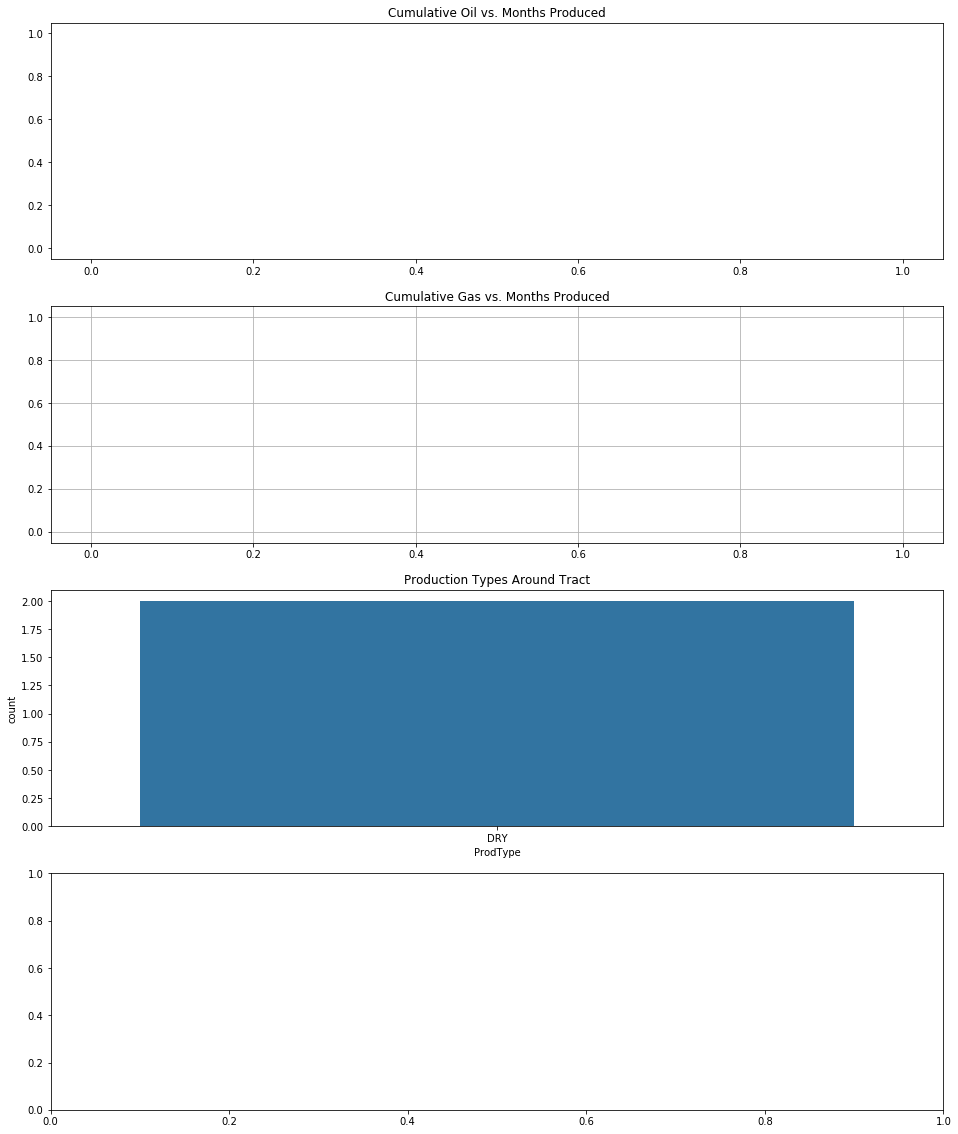

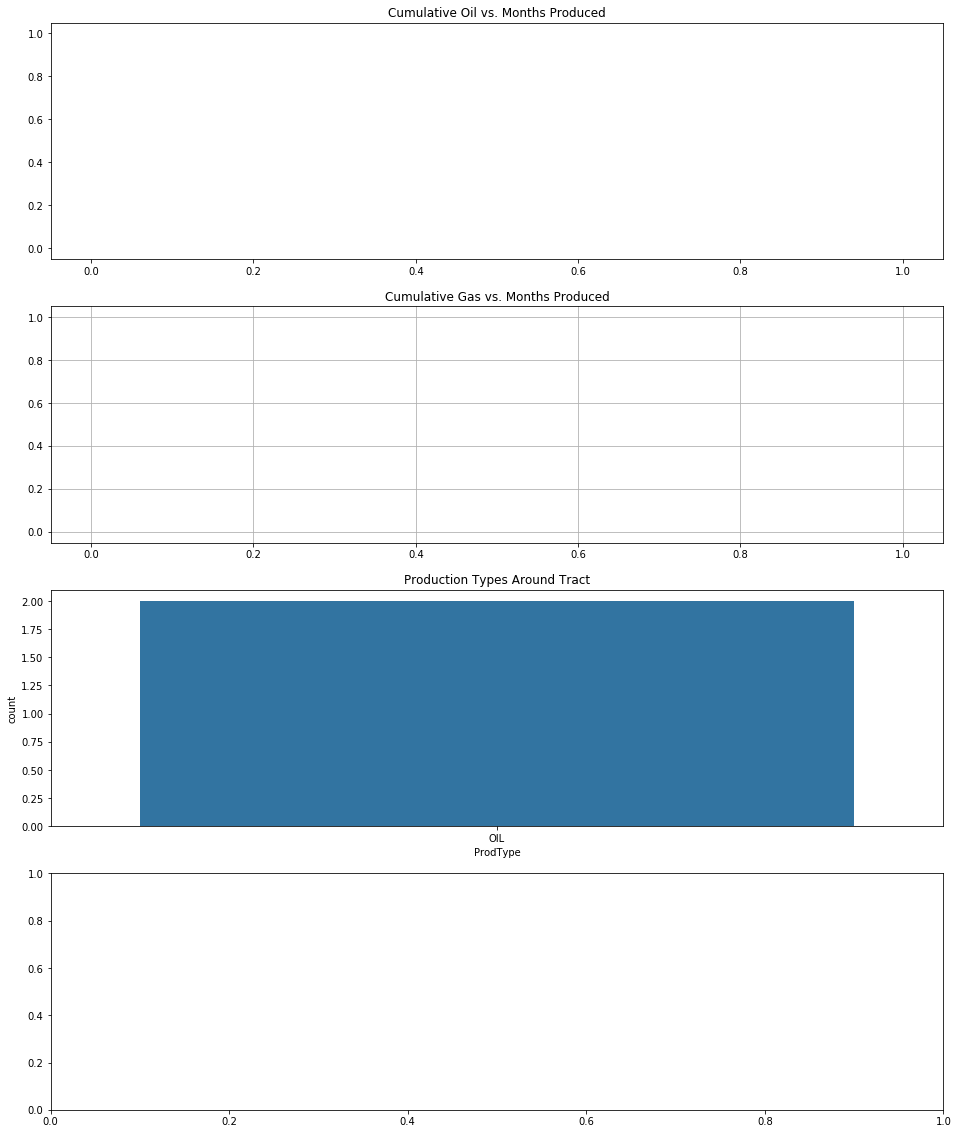

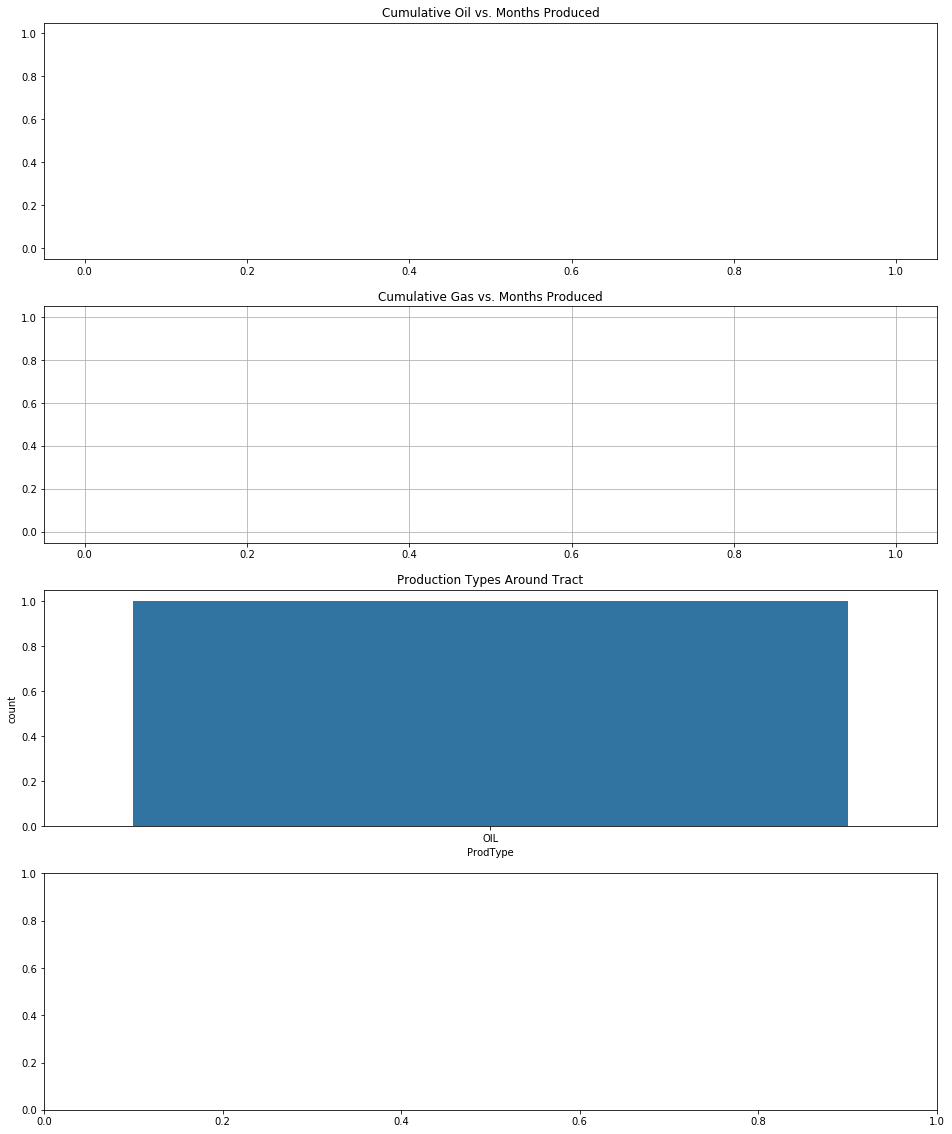

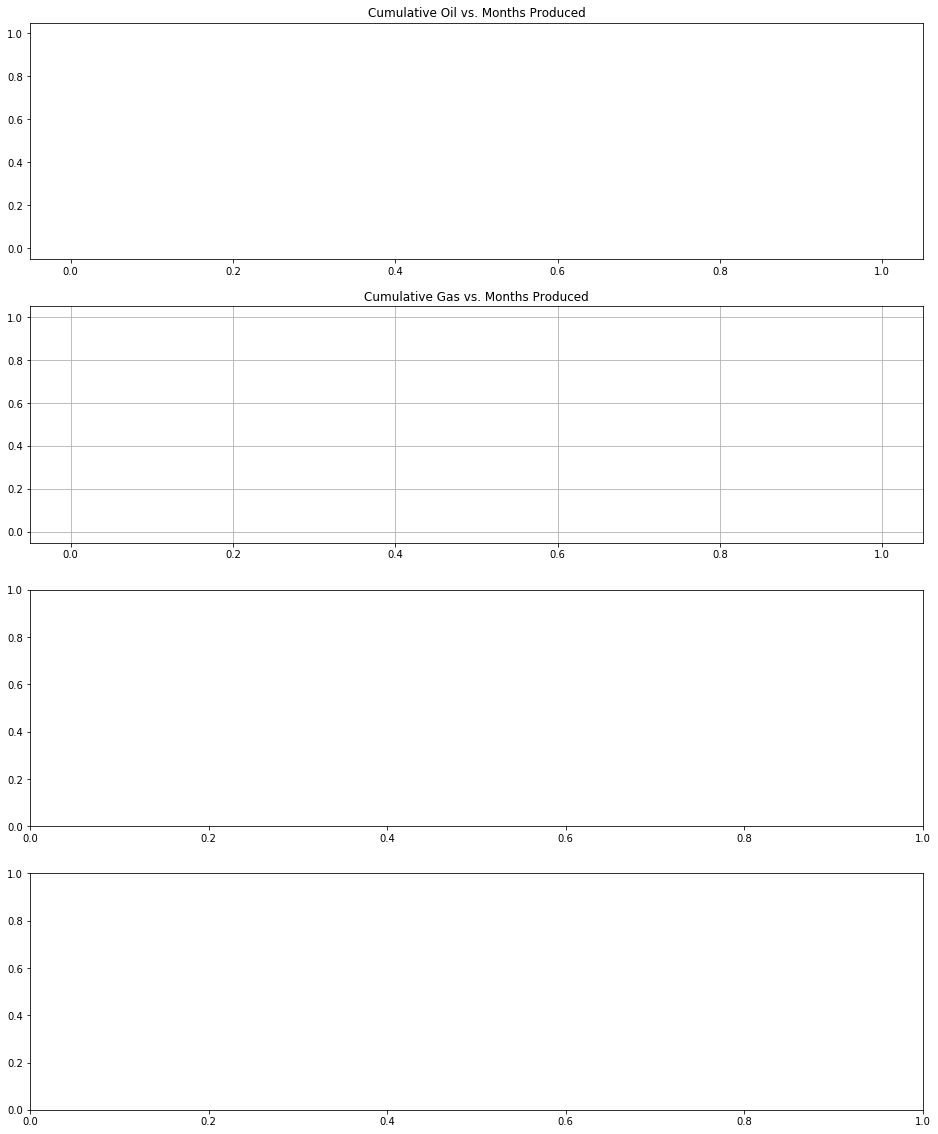

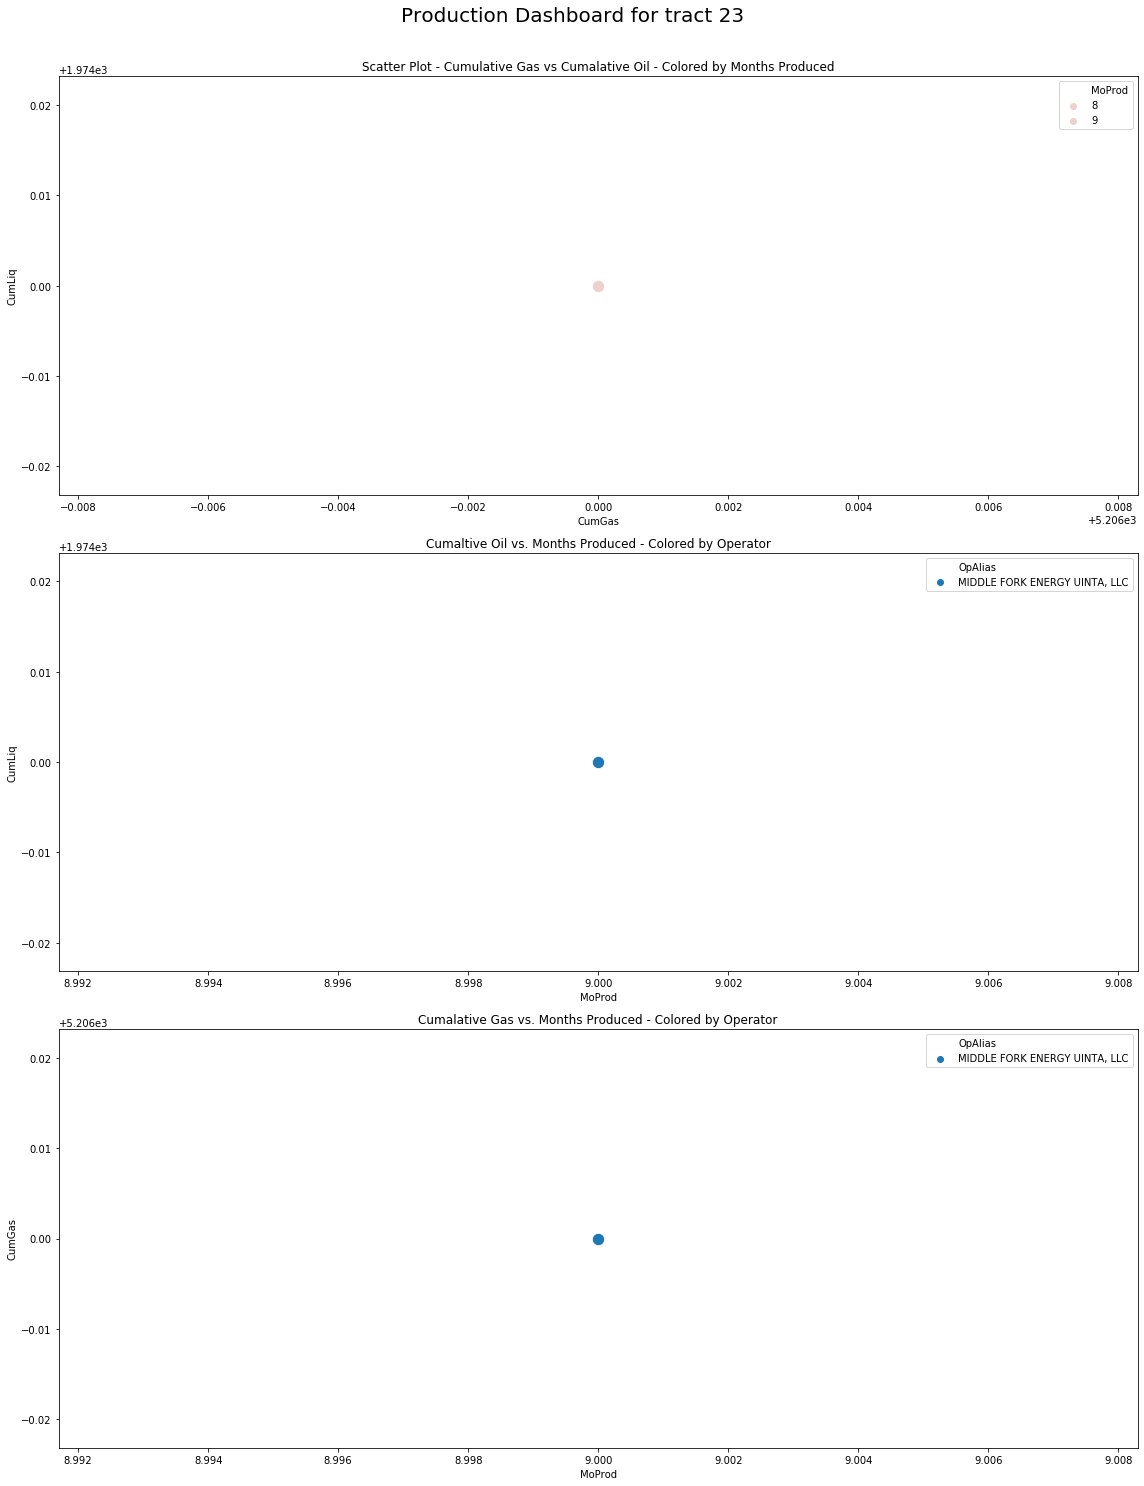

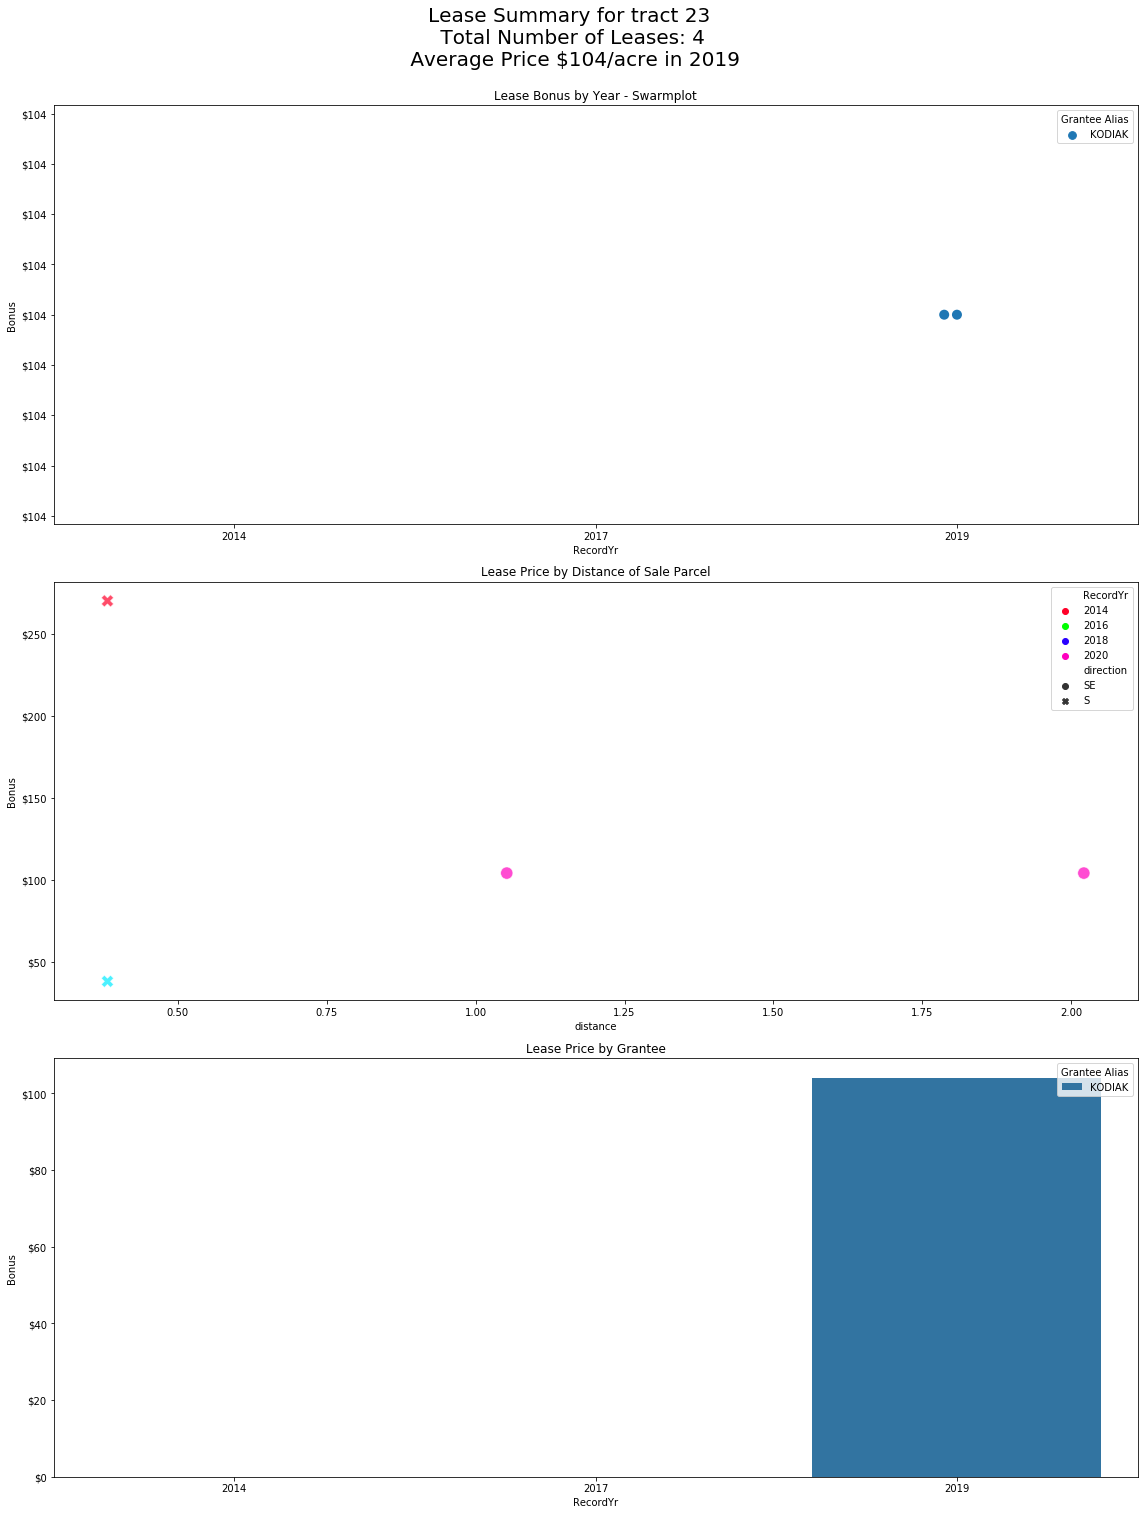

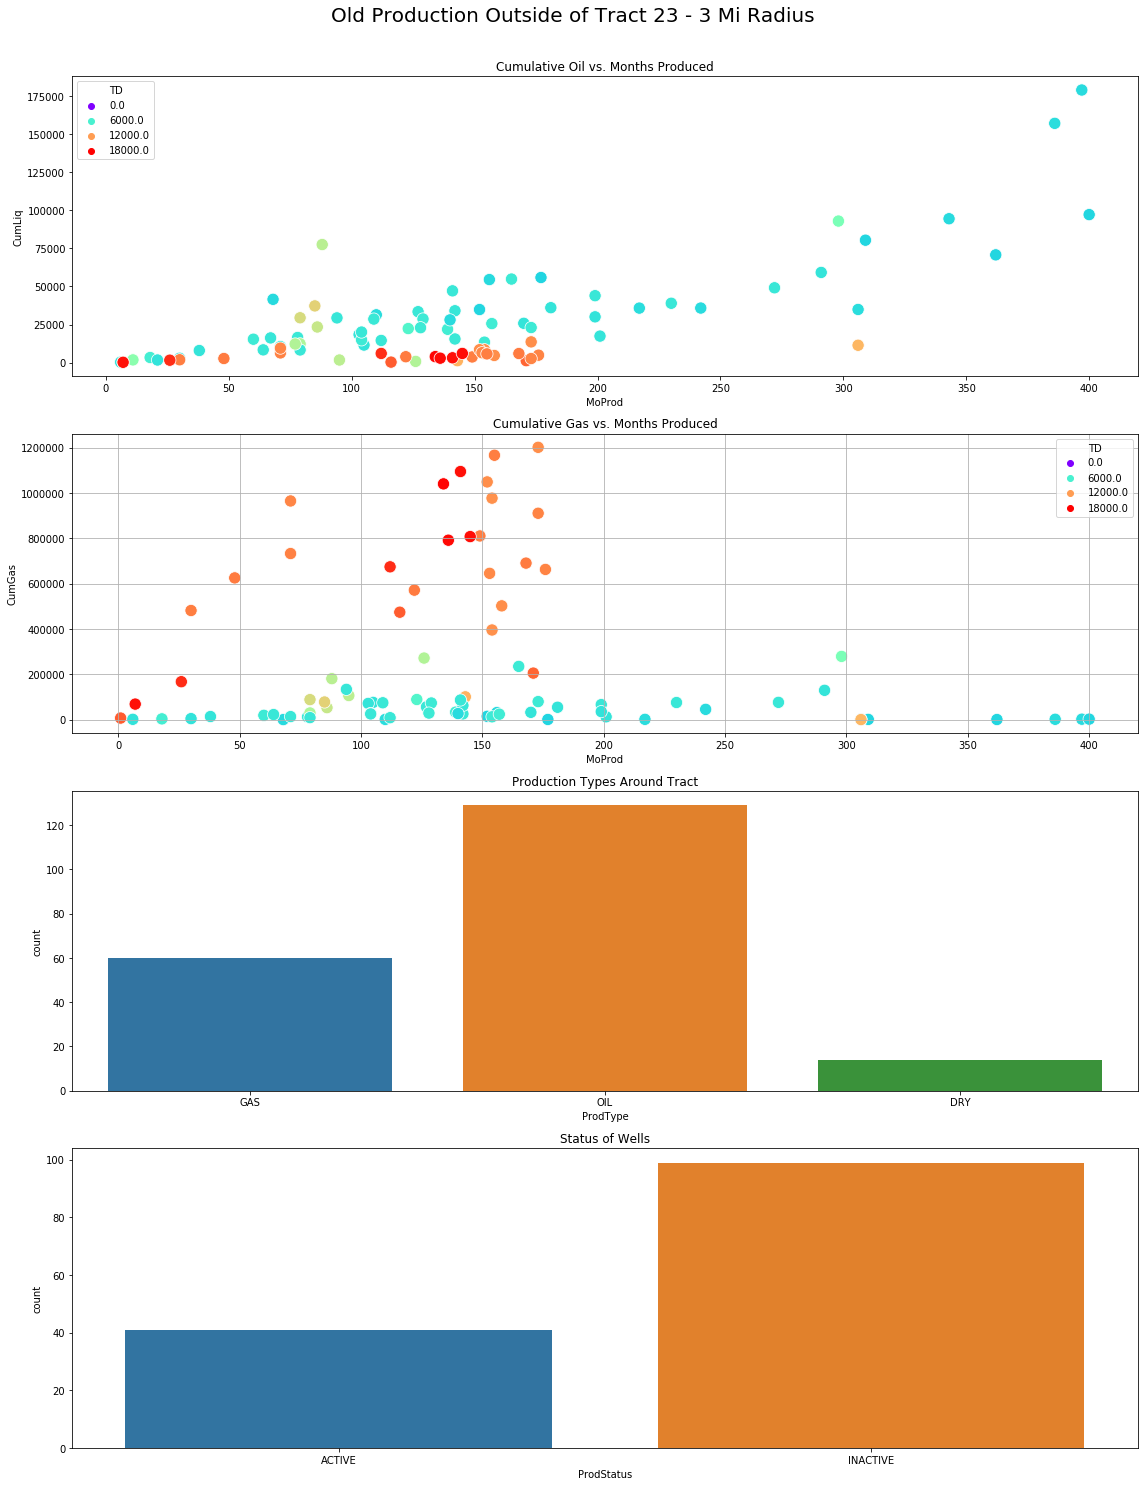

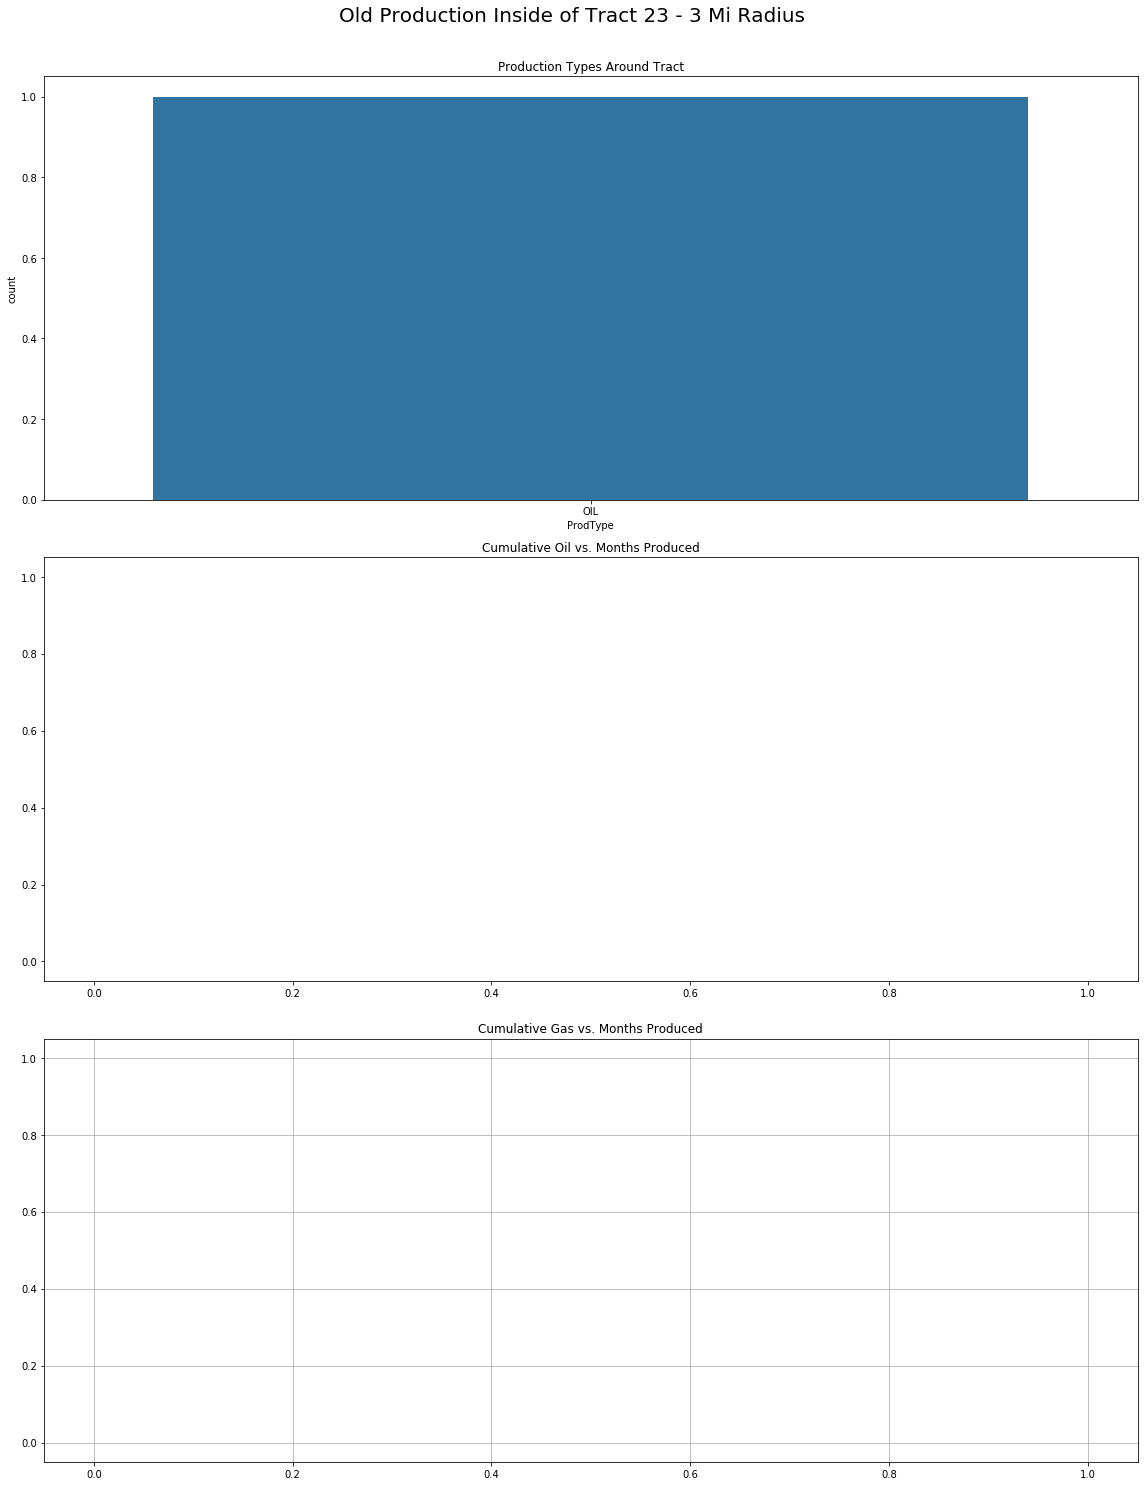

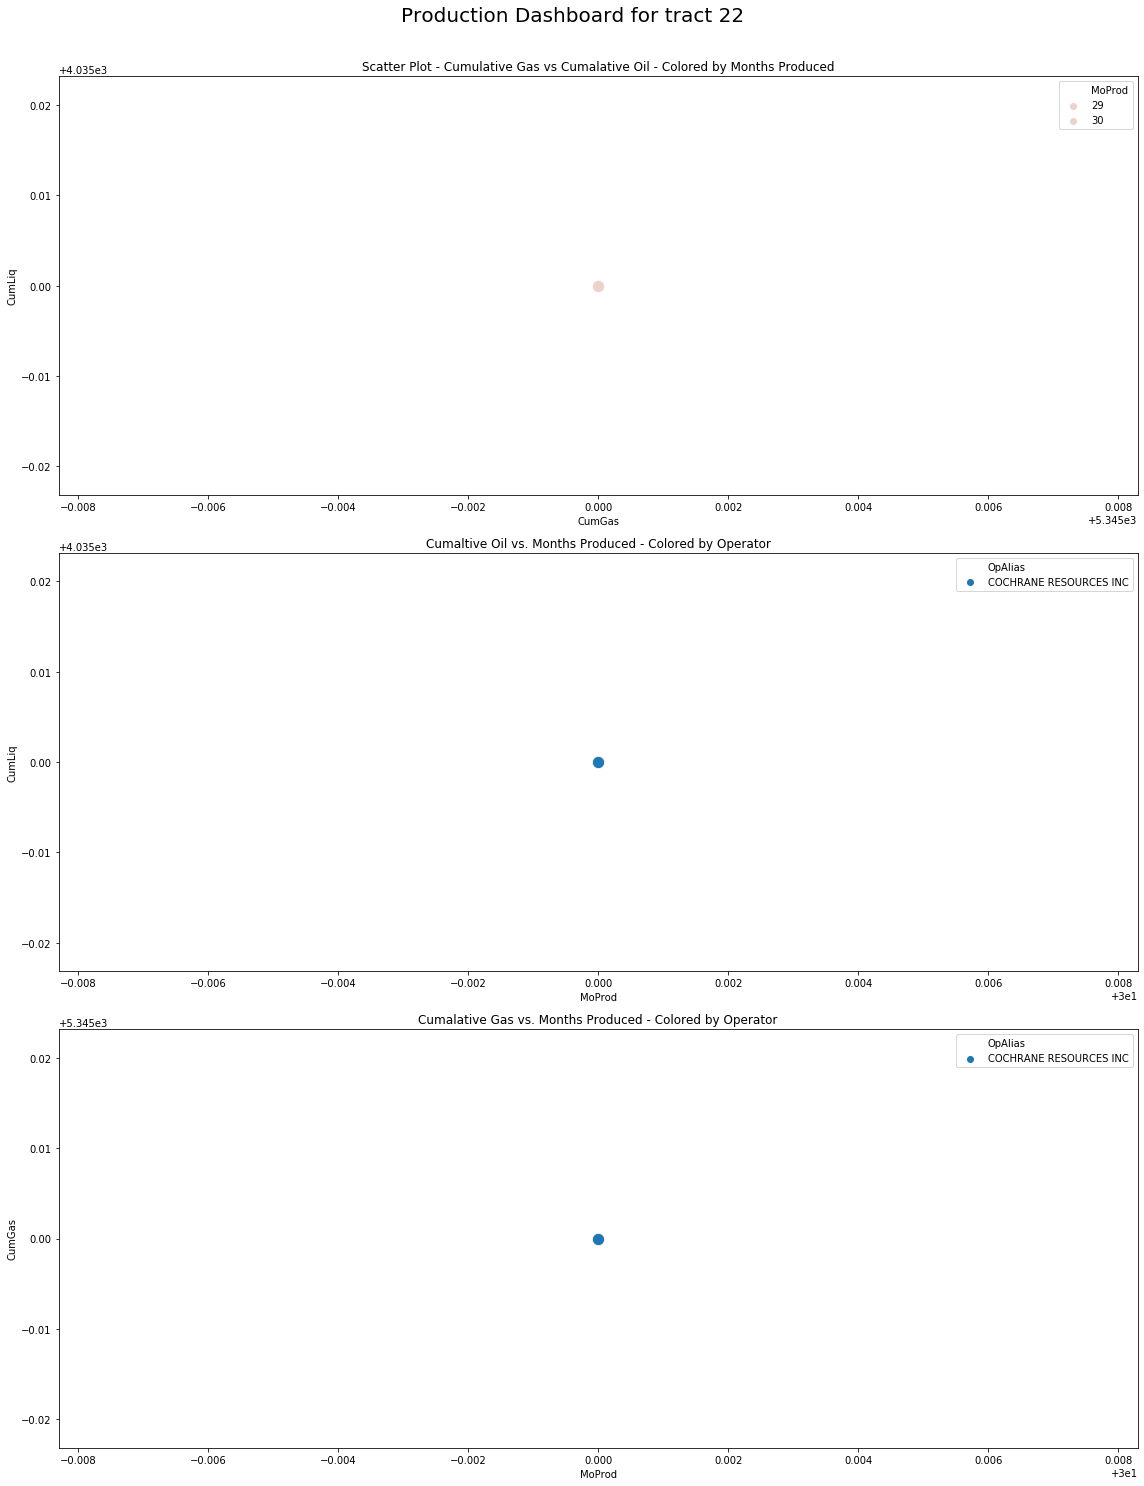

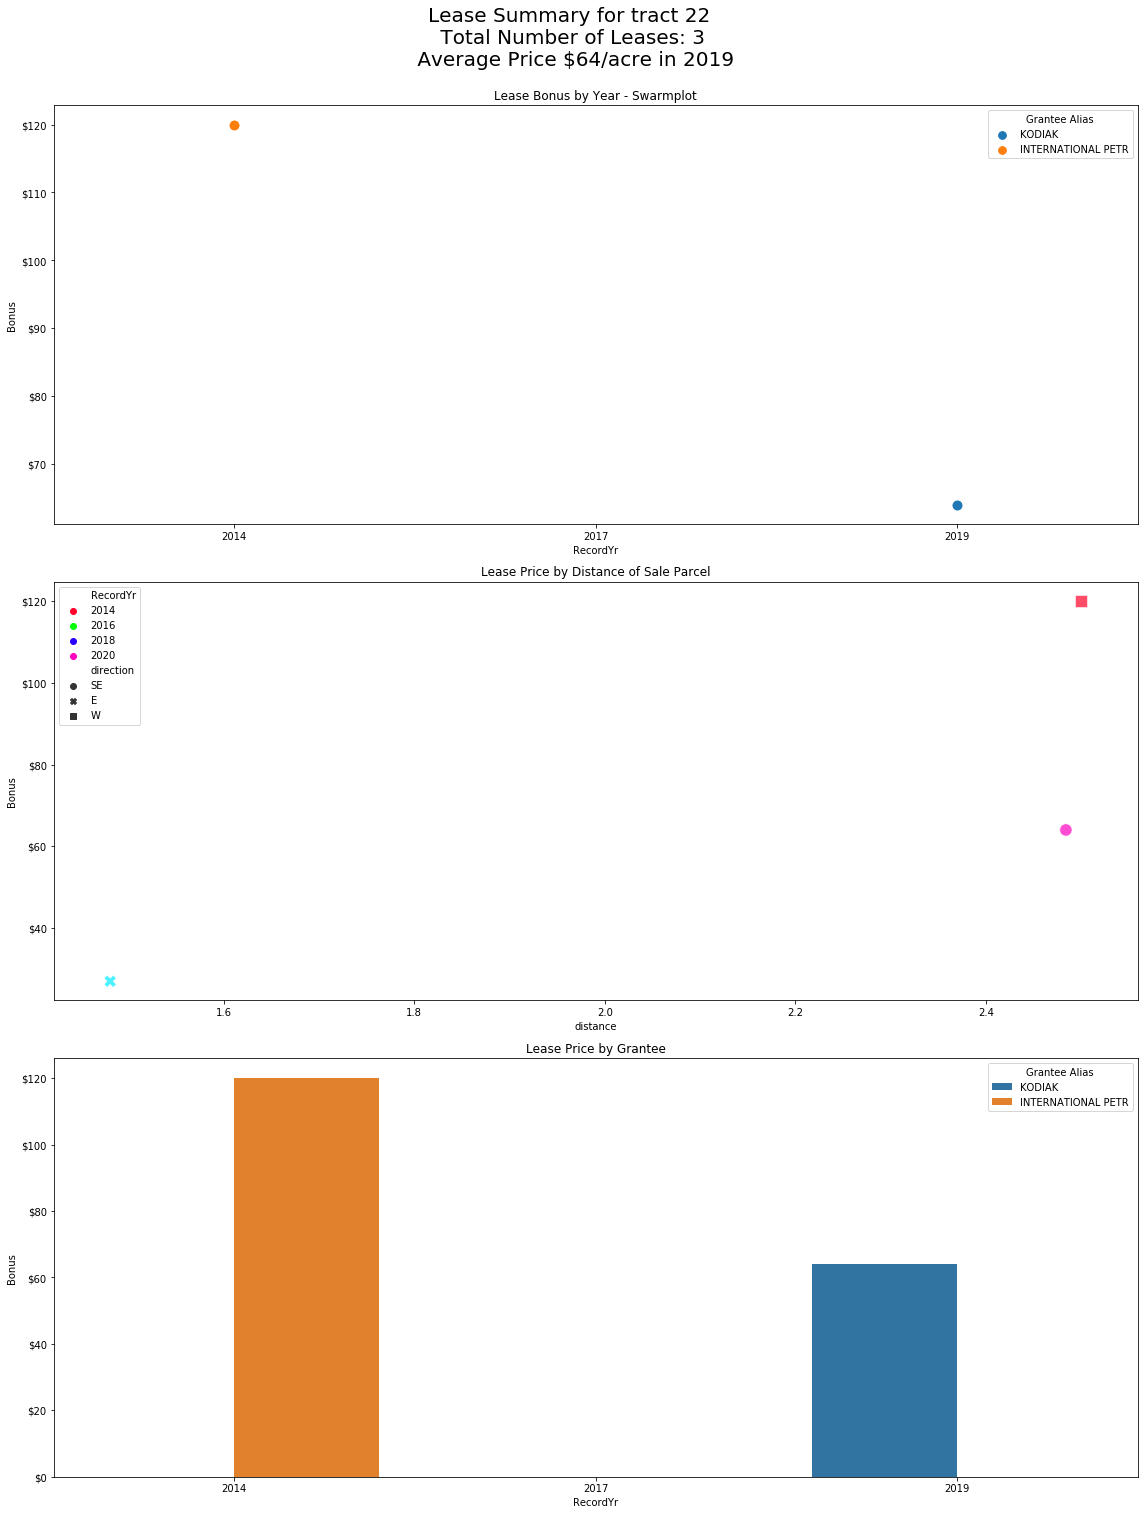

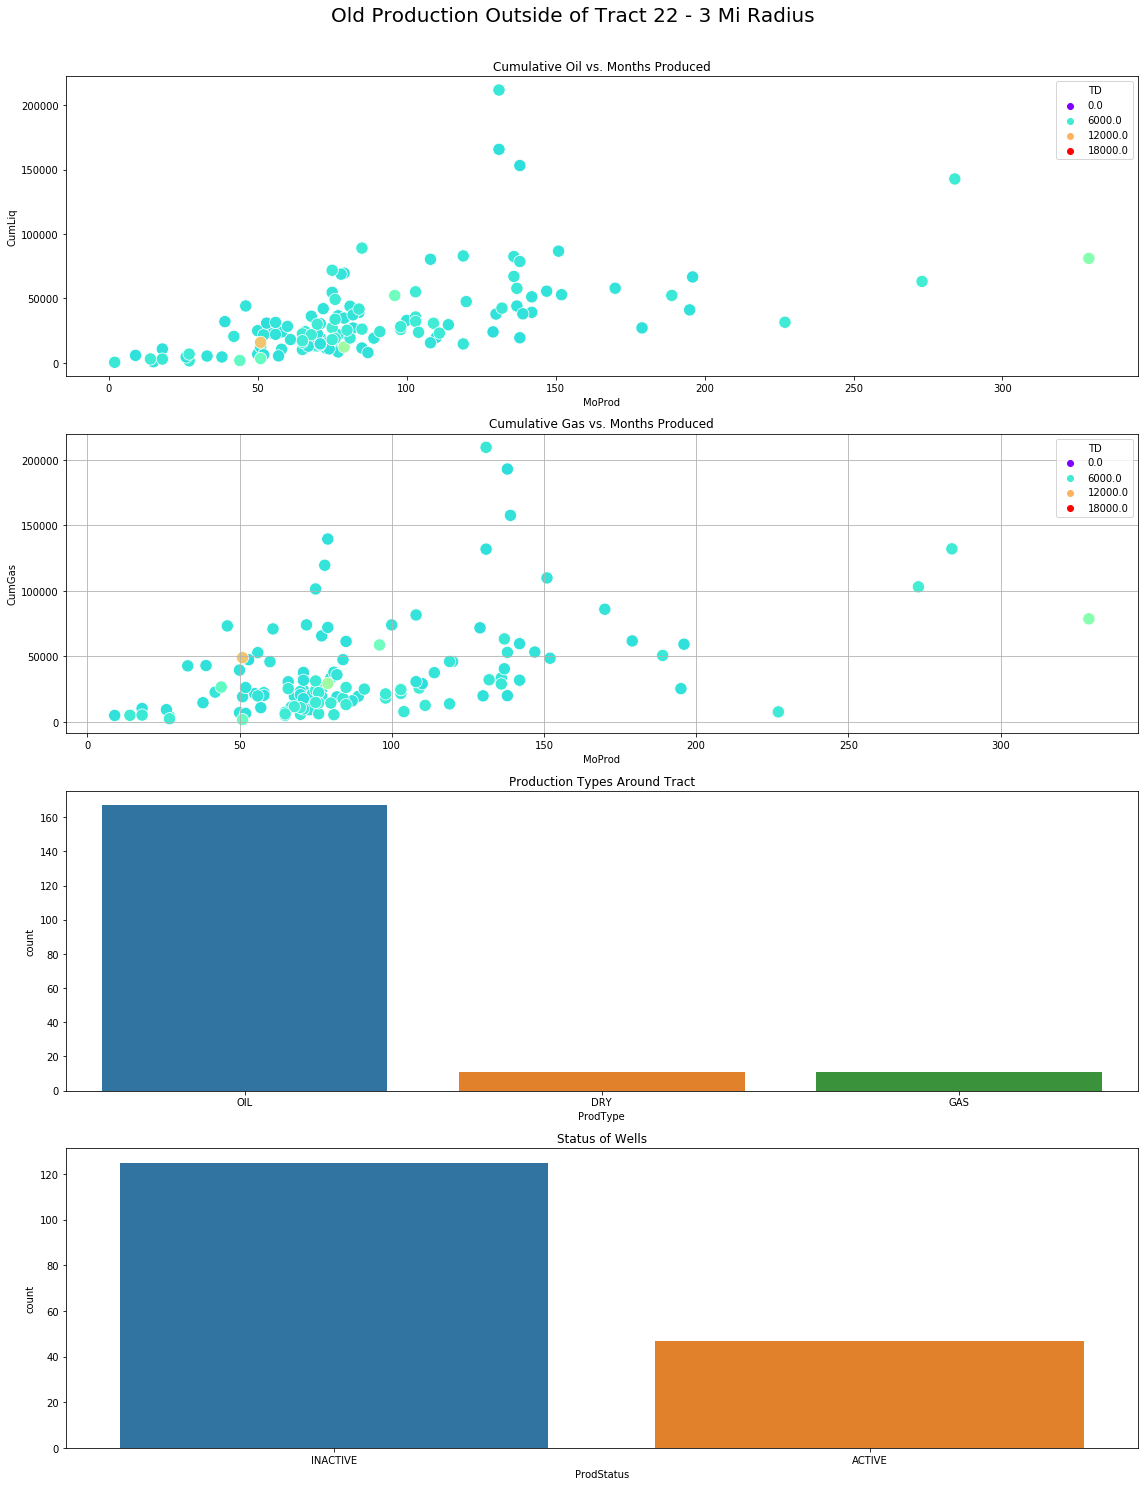

In [28]:
#creating empty array to append summaries to for each tract
summaryPermits = []
summaryProd = []
summaryLeases = []
summaryOldProd = []

#creating arrays to append visual plots for each tract
perdashboard = []
proddashboard = []
leasedashboard = []
oldproddashboard = []

#looping through each tract id and creating filtered geospatial data, activity summaries, and visualizaiton plots
for i in tractshp["tract_id"]:
    perm, prod, leases, oldprodtoeval = getActivityData(i) 
    
    try:
        summaryPermits.append(writePermitSummary(perm))
    except:
        summaryPermits.append("error occured")
        
    try:
        summaryProd.append(writeProdSummary(prod))
    except:
        summaryProd.append("error occured")
        
    try:
        summaryLeases.append(writeLeaseSummary(leases))
    except: 
        summaryLeases.append("error occured")

    try:
        summaryOldProd.append(writeOldProdSummary(oldprodtoeval, i))
    except: 
        summaryOldProd.append("error occured")
    
    try:
        #appending visualizaiton plots to list    
        perdashboard.append(createPermitDash(perm,i))
        proddashboard.append(createProdDash(prod, i))
        leasedashboard.append(createLeasesDash(leases, i))  
        oldproddashboard.append(createOldProdDash(oldprodtoeval, i))
    except:
        print('error occured in visualizaiton')


### Appending Results of mass loop of applying summary functions and visualization plots

In [29]:
#appending columns to tract list with summaries for each data type (old prod, leases, permits, new production)
tractshp["Permit Summary"] = summaryPermits

tractshp["Leases Summary"] = summaryLeases

tractshp["Old Production Summary"] = summaryOldProd

tractshp["Recent Prod Summary"] = summaryProd


In [30]:
tractshp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 12 columns):
lot_no                    23 non-null int64
tract_id                  23 non-null int64
short_code                23 non-null object
label                     23 non-null object
geometry                  23 non-null geometry
centroids                 23 non-null geometry
Acres                     23 non-null float64
buffers                   23 non-null object
Permit Summary            23 non-null object
Leases Summary            23 non-null object
Old Production Summary    23 non-null object
Recent Prod Summary       23 non-null object
dtypes: float64(1), geometry(2), int64(2), object(7)
memory usage: 2.2+ KB


### Writing Summary Results to File

In [31]:
#saving activity notes in an excel file in the results folder - dropping geopandas required geo cols
tractshp.drop(columns = "geometry centroids buffers".split(" ")).to_excel("Results/Activity Summary Notes.xlsx")

In [32]:
#zipping individual corresponding plots for each tract into one master list
MasterDash = list(zip(perdashboard, proddashboard, leasedashboard, oldproddashboard))

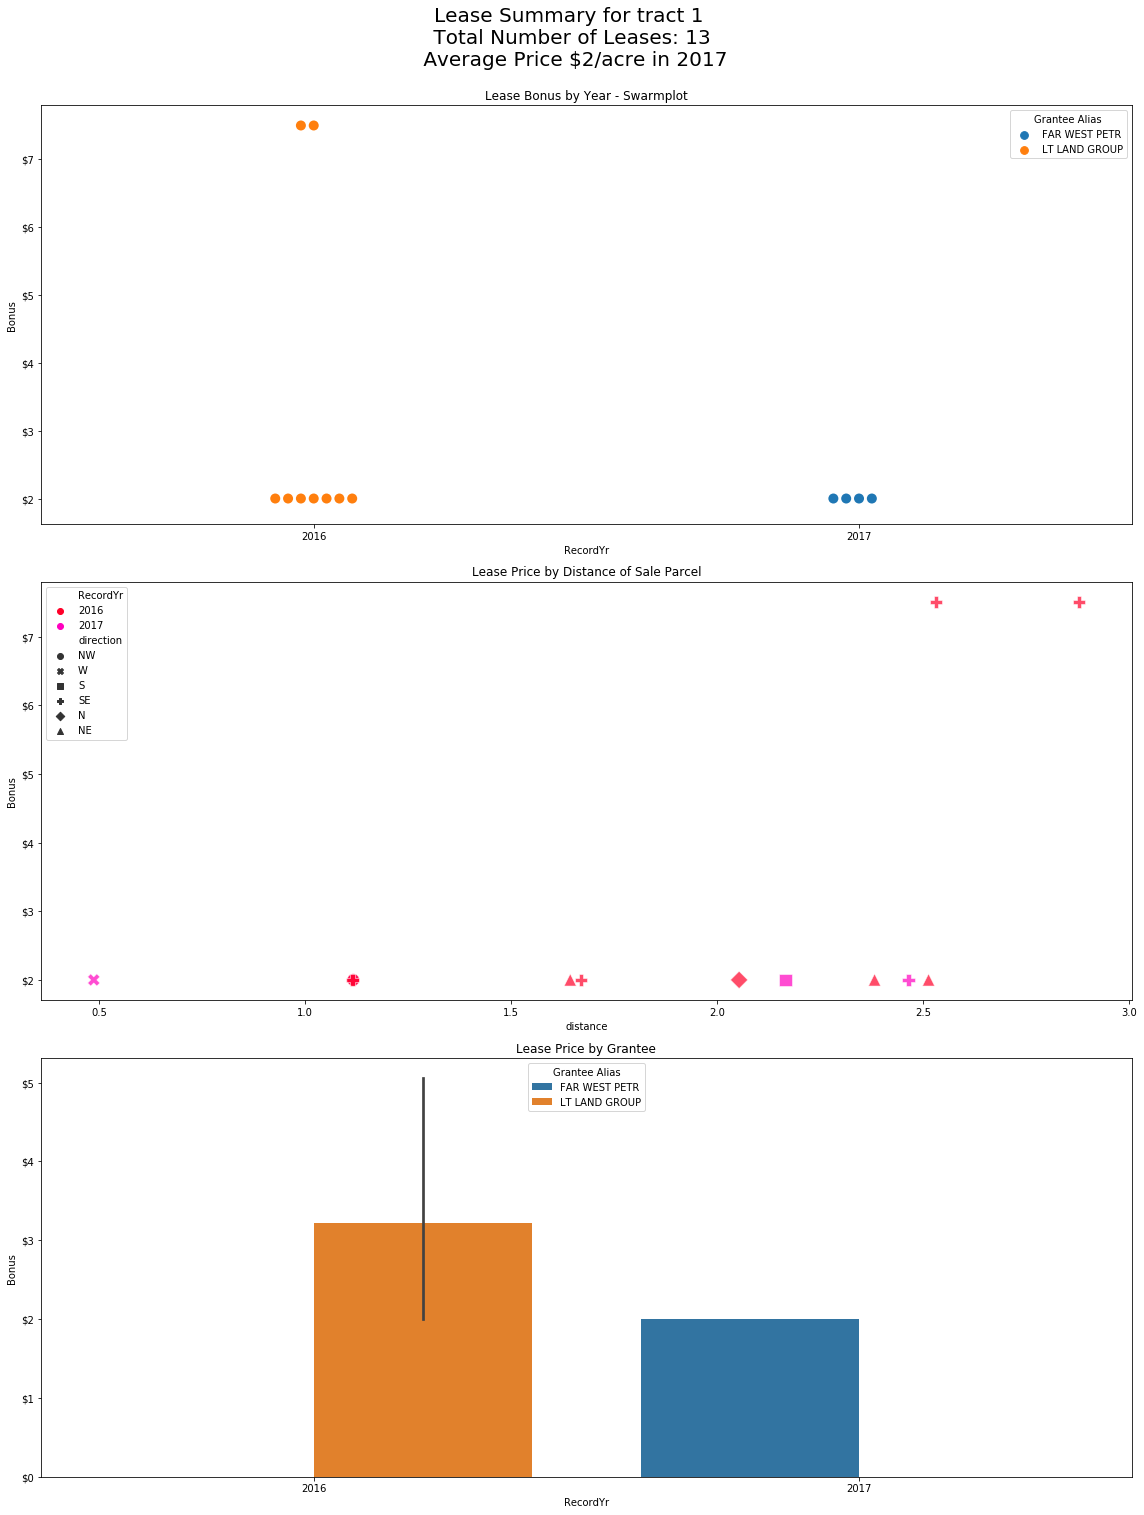

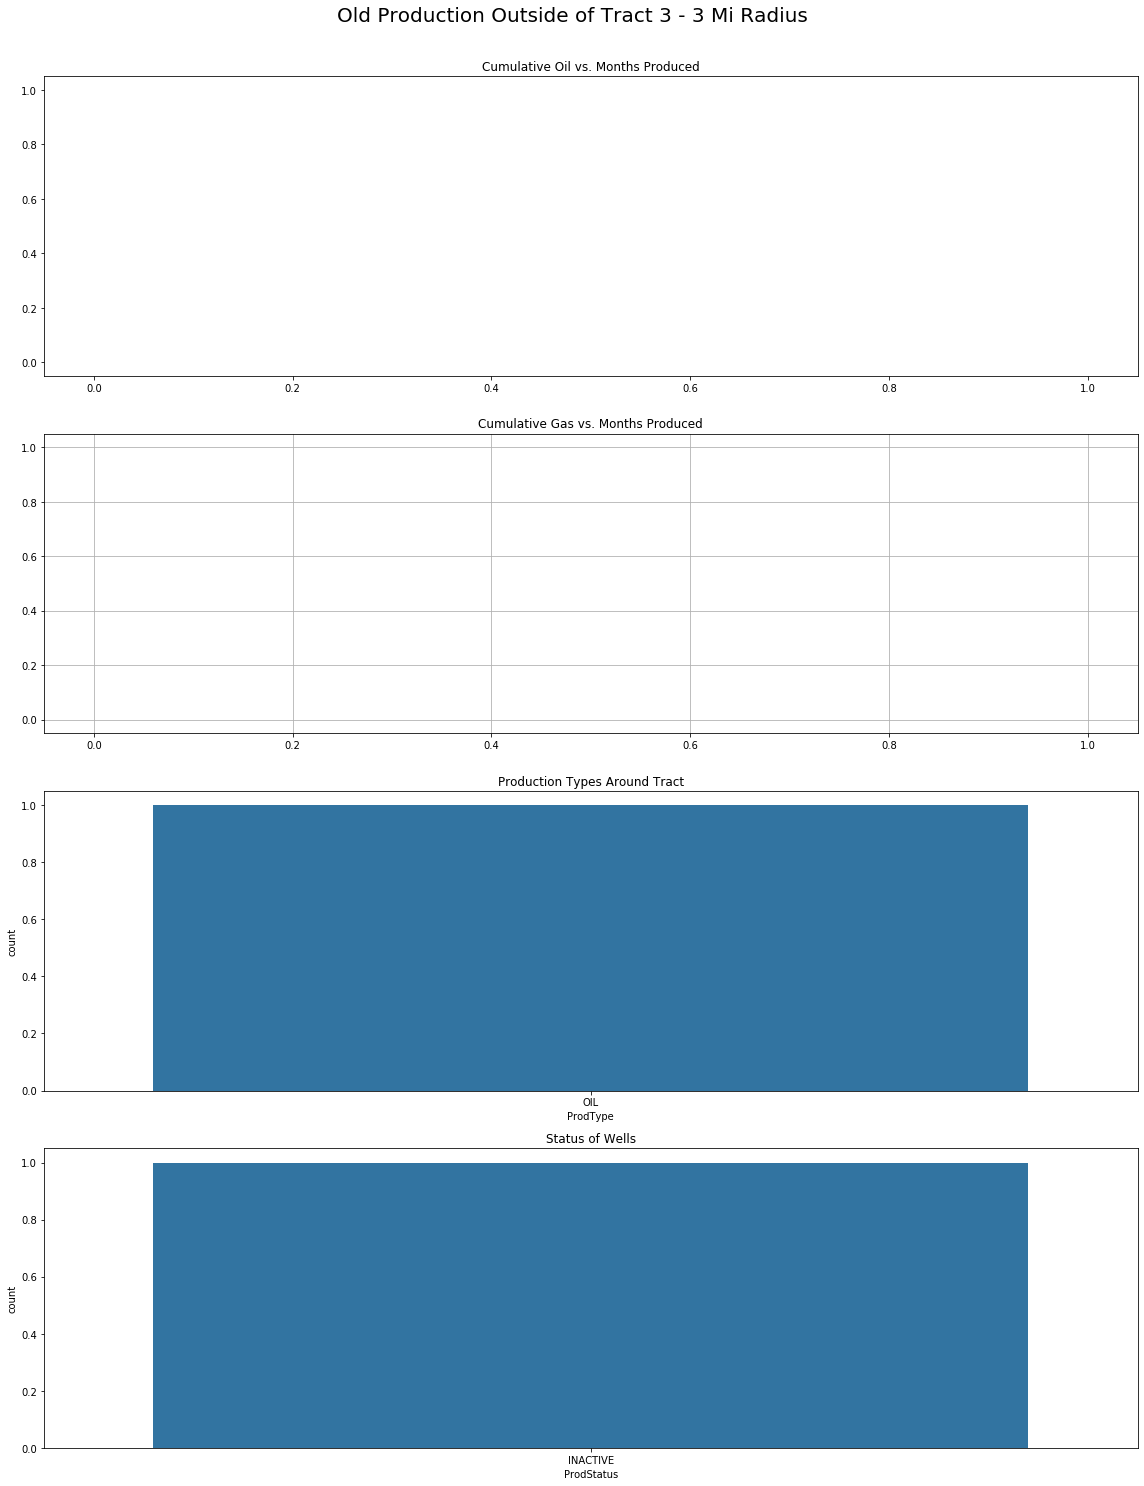

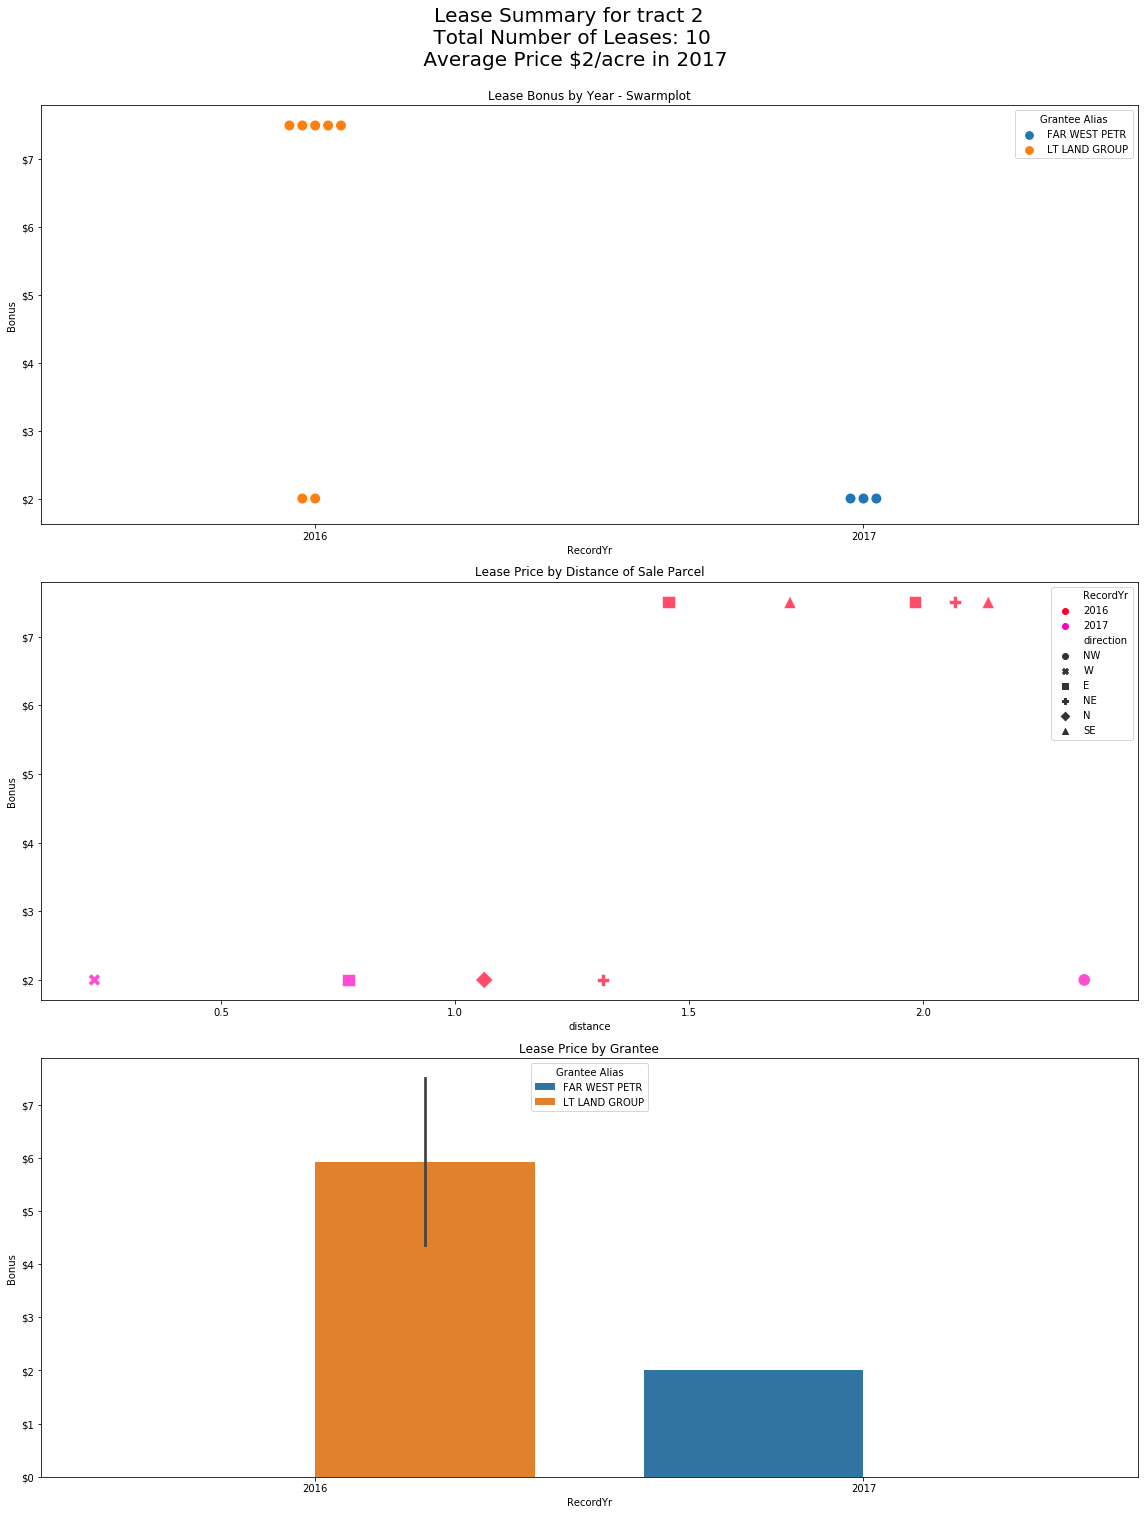

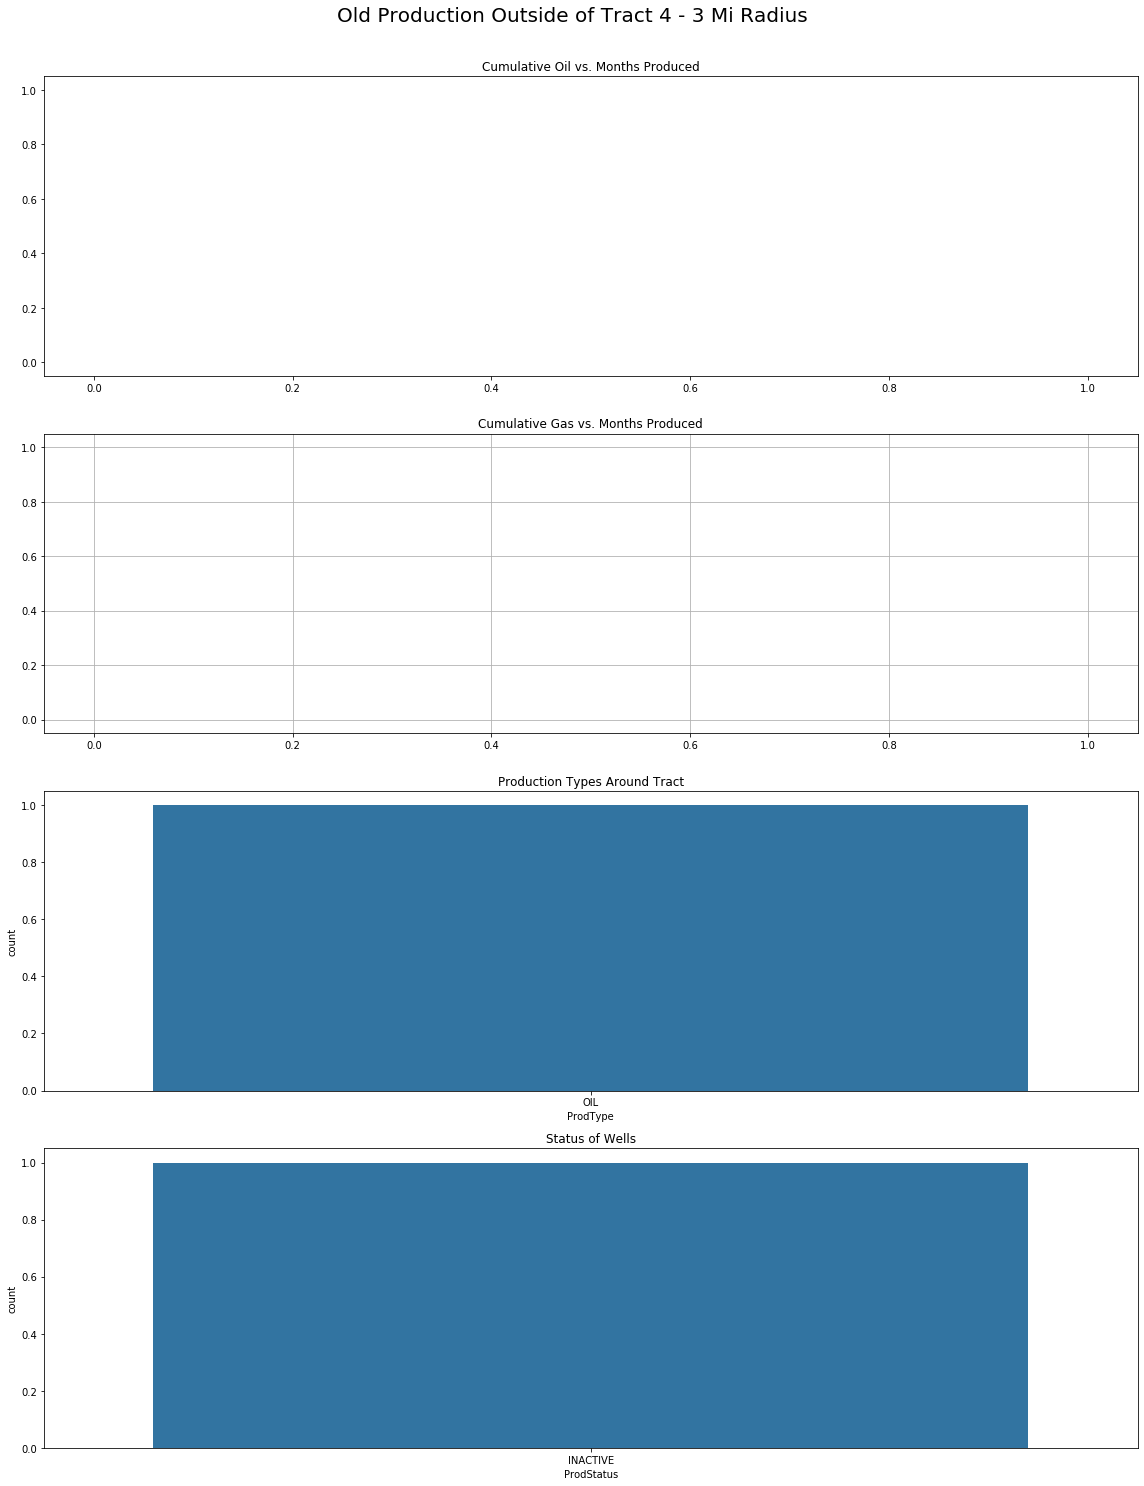

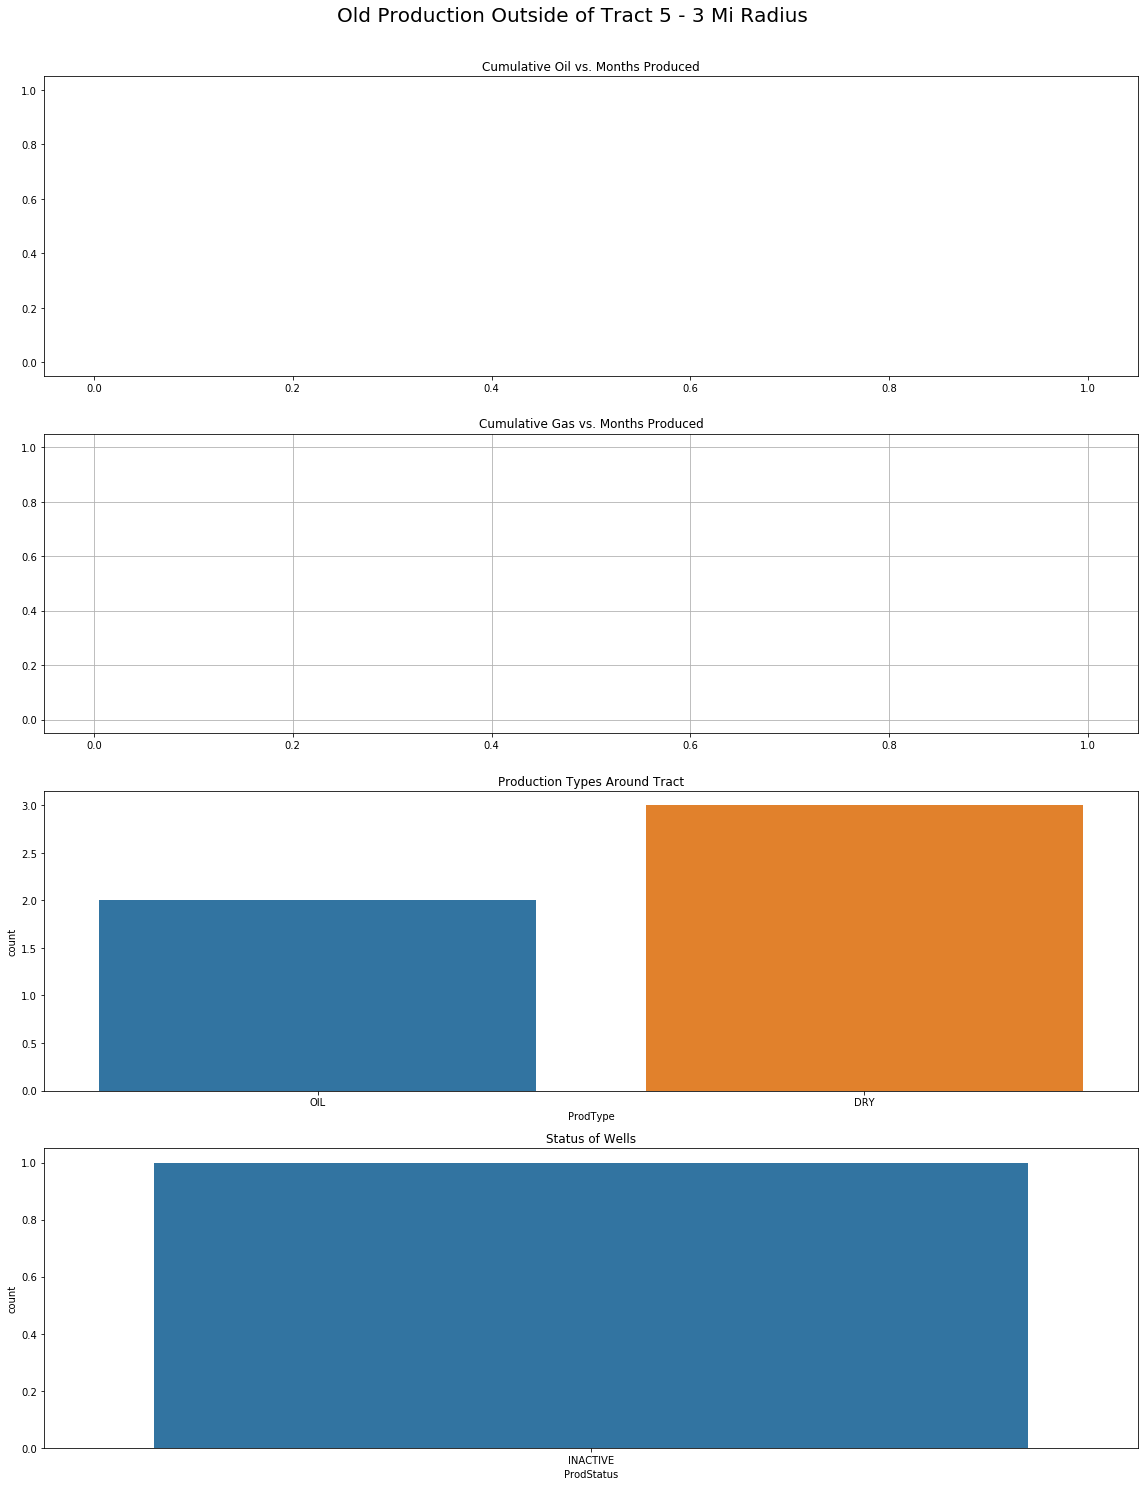

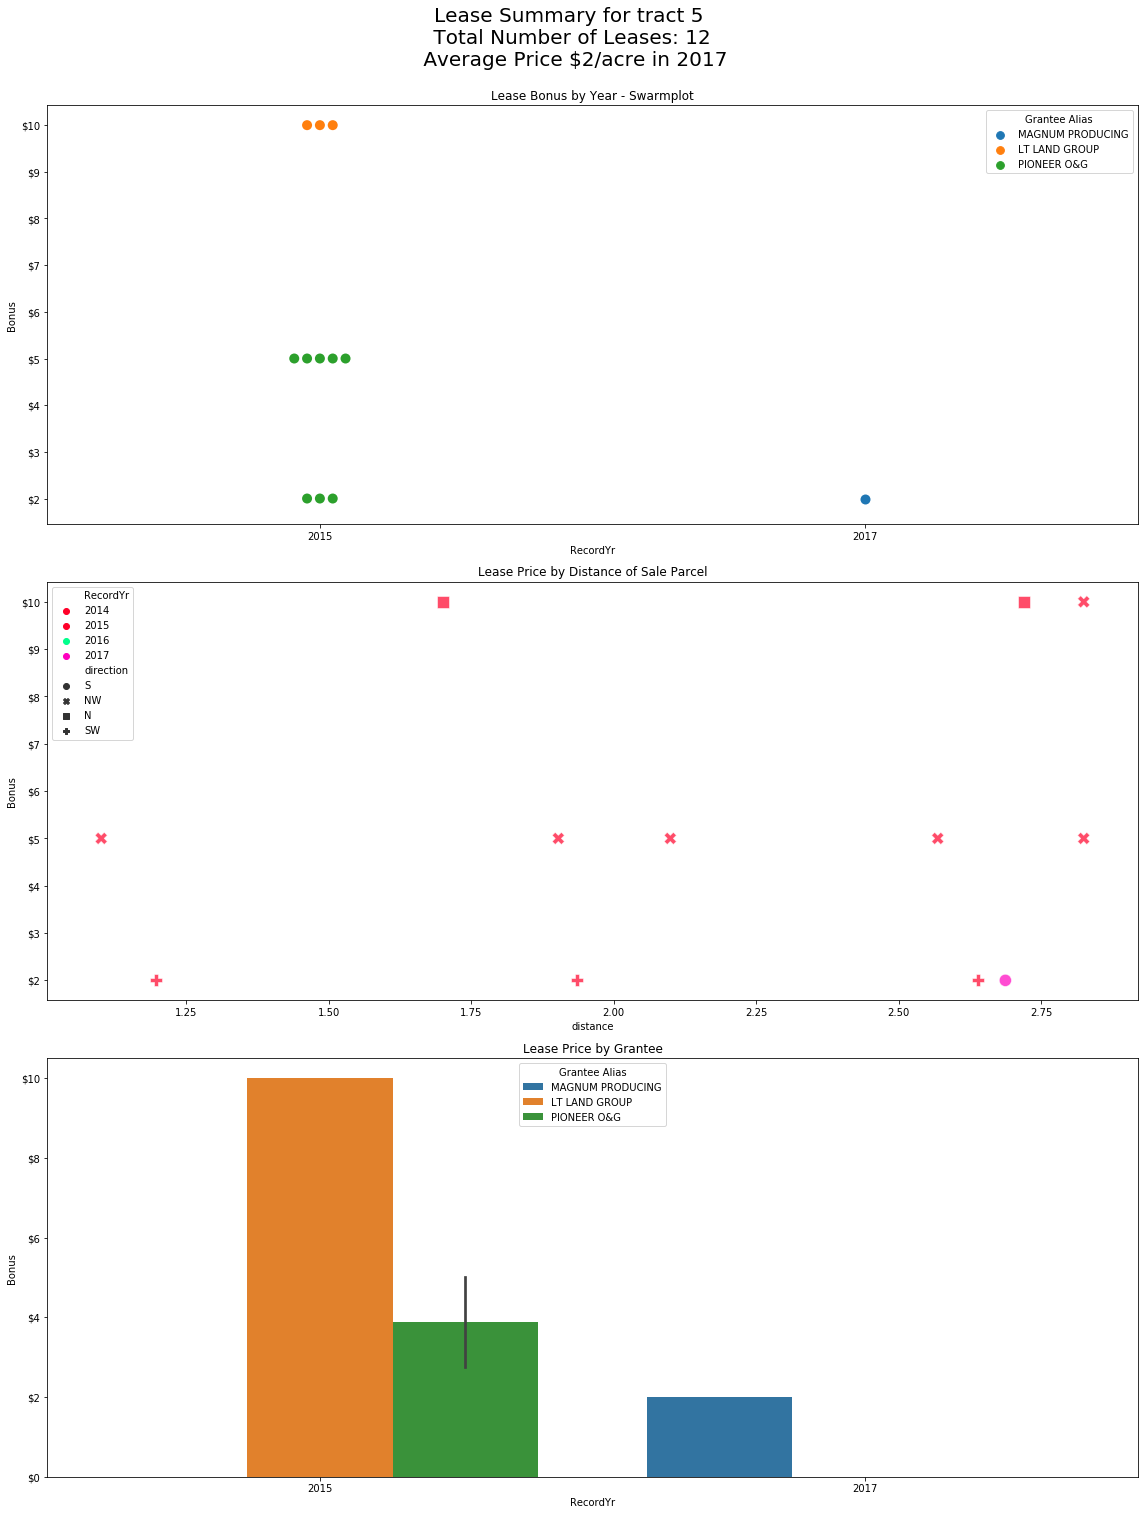

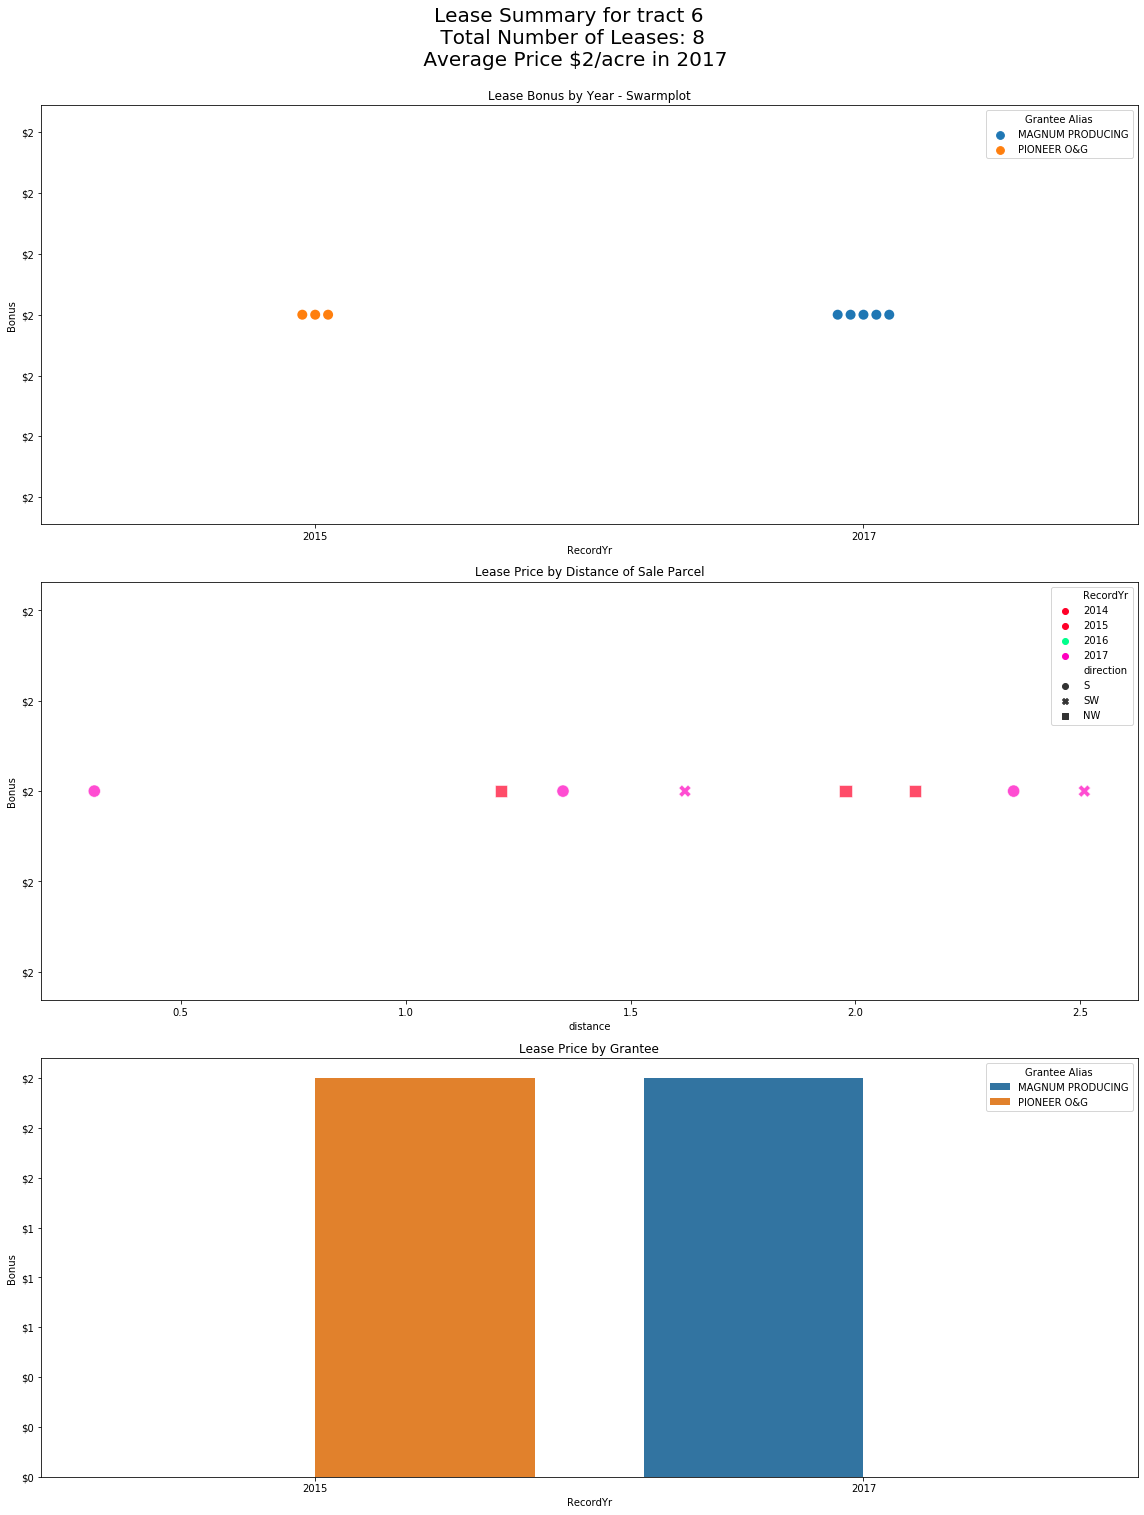

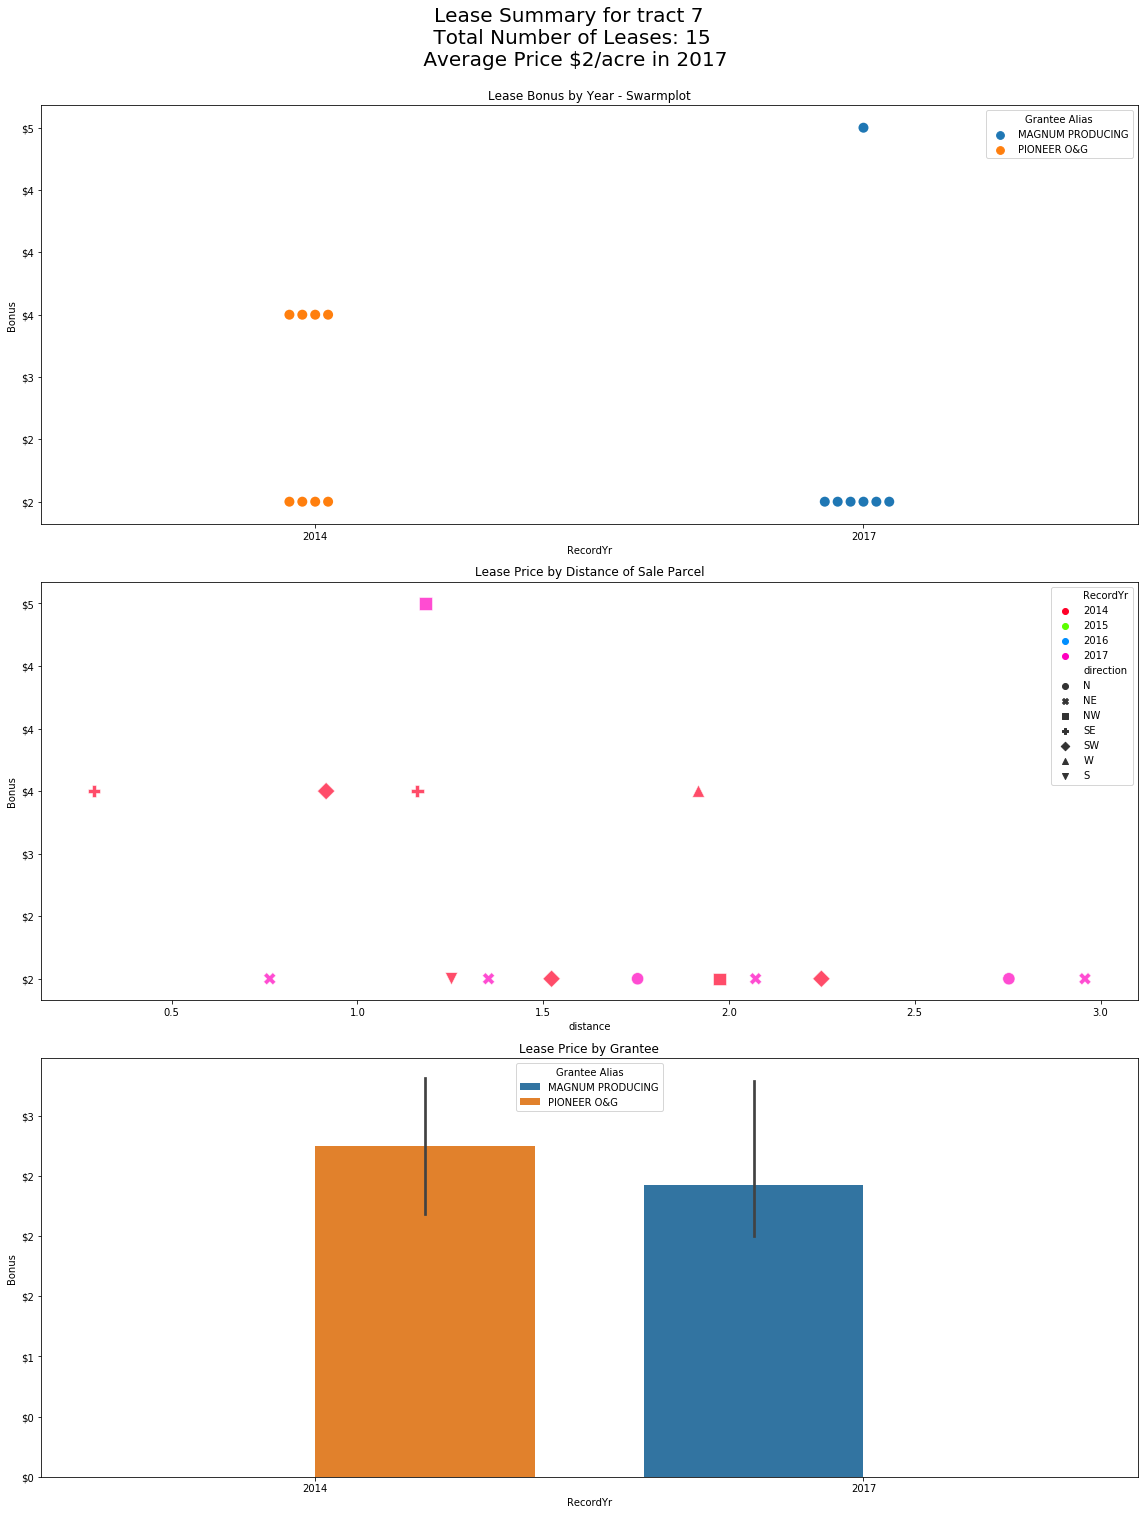

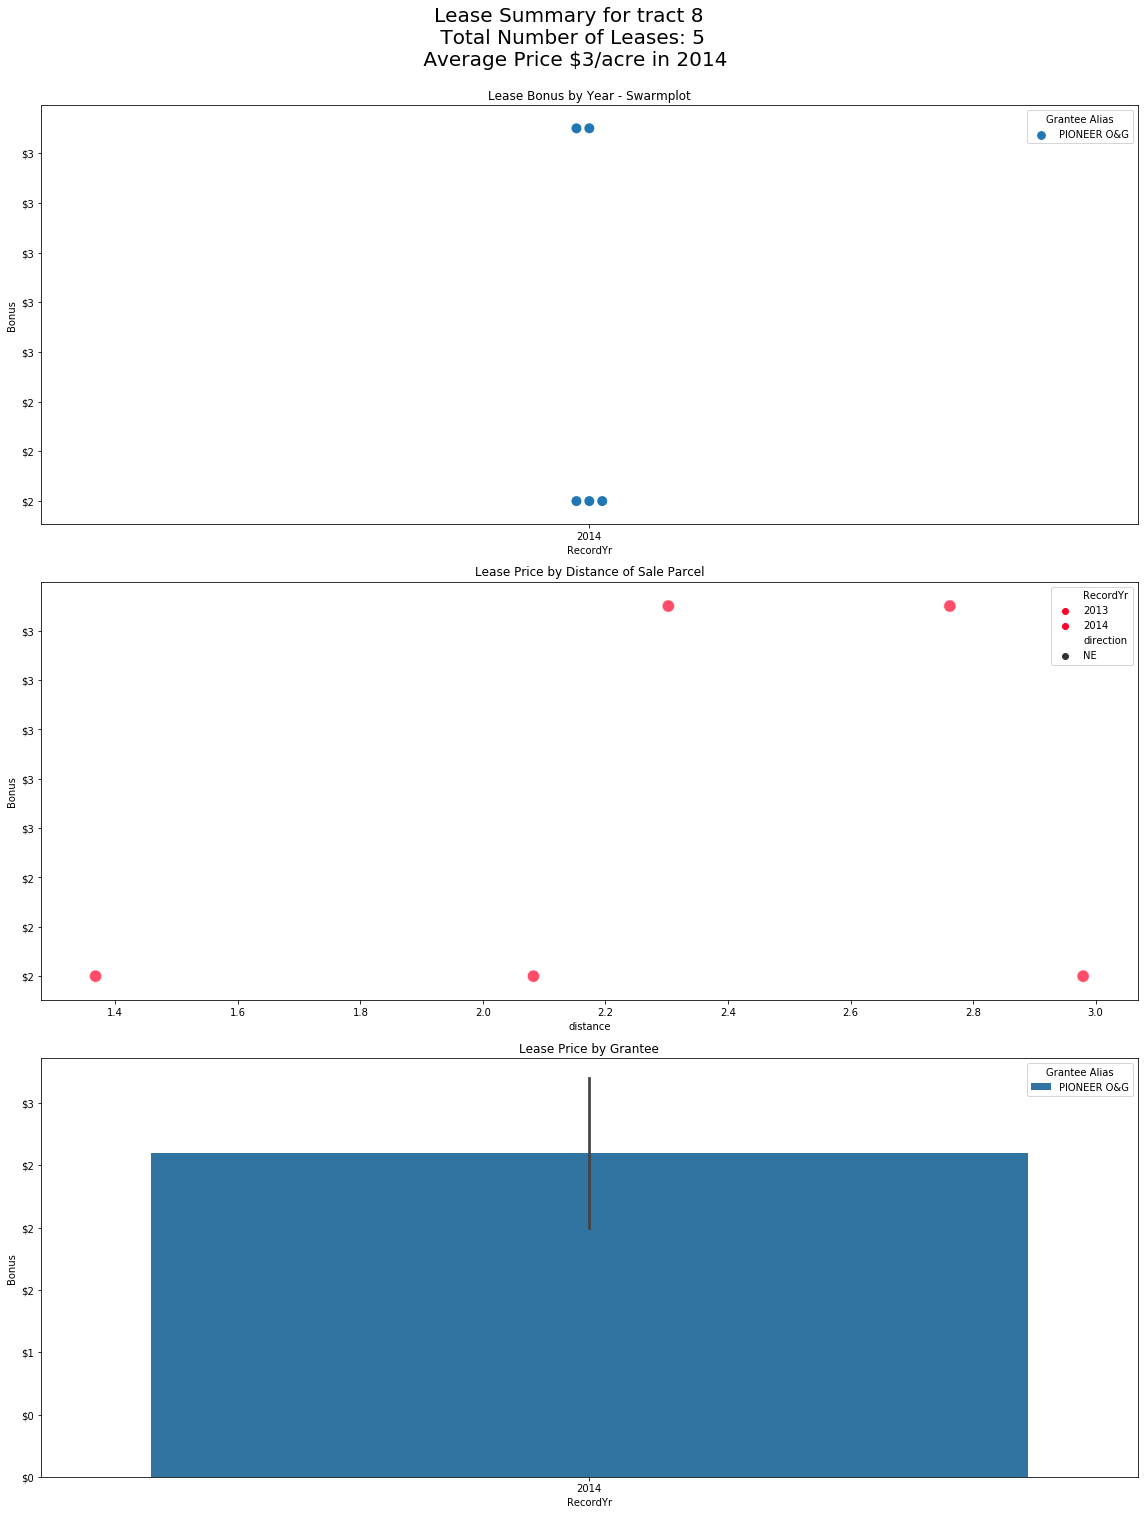

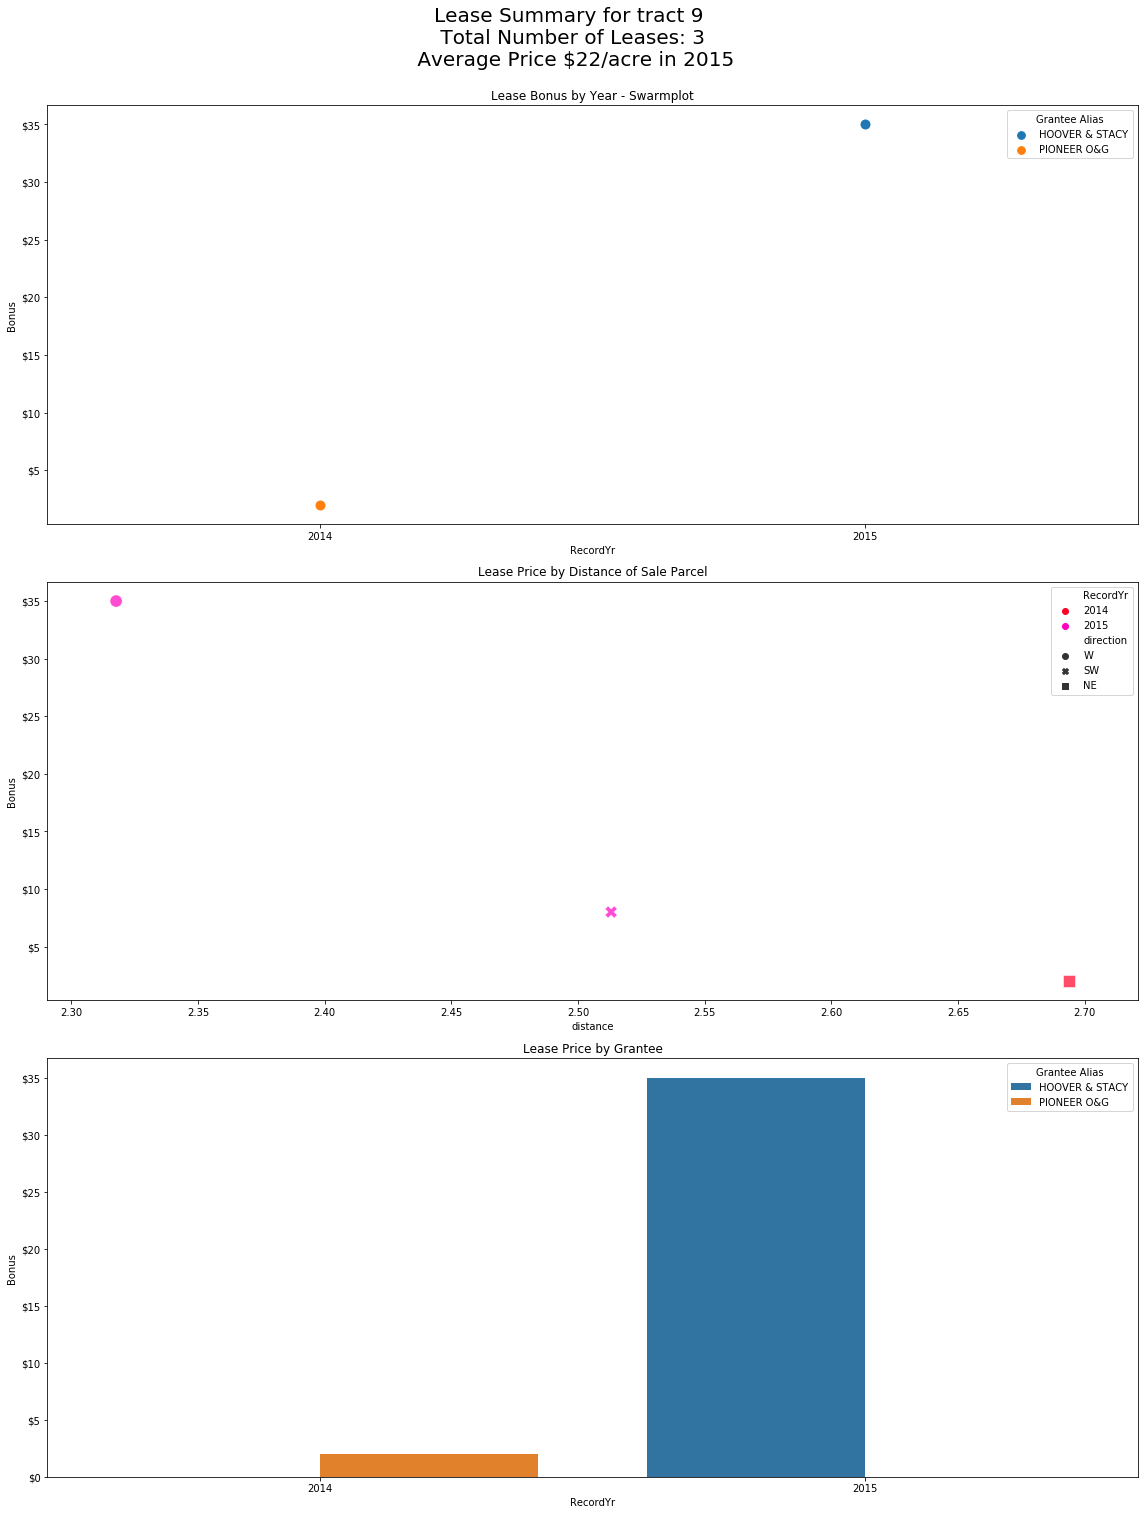

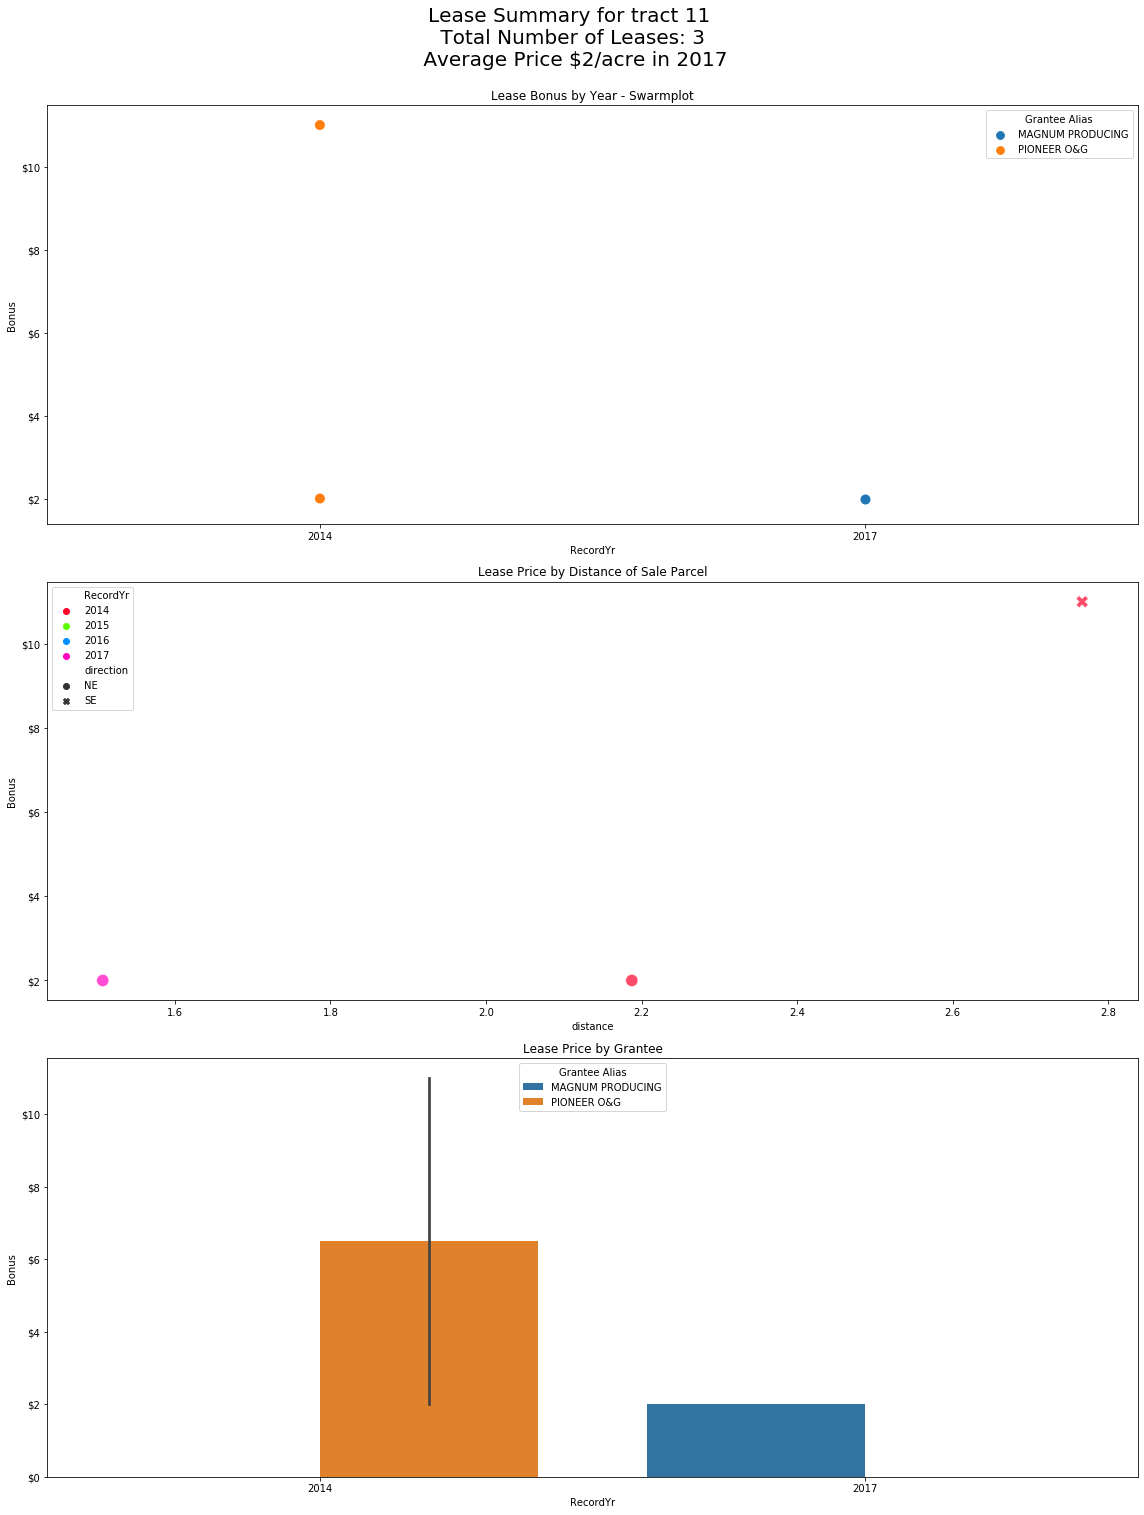

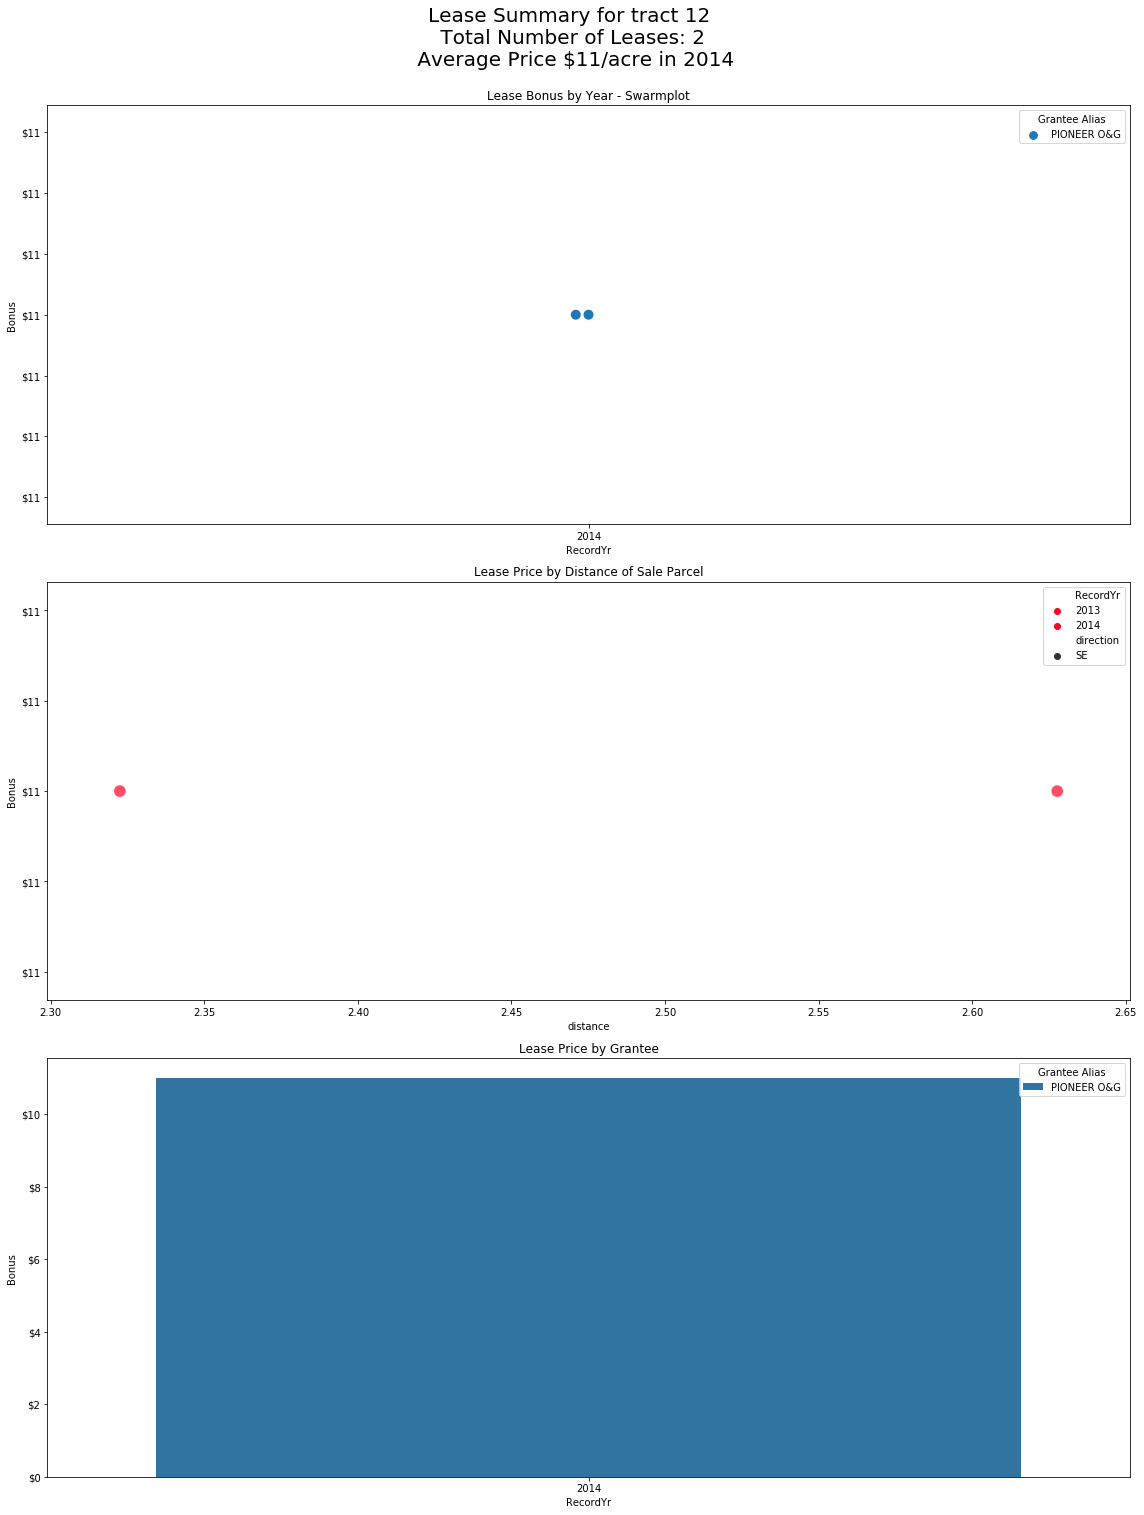

(<Figure size 1152x1440 with 4 Axes>, <Figure size 1152x1440 with 3 Axes>)

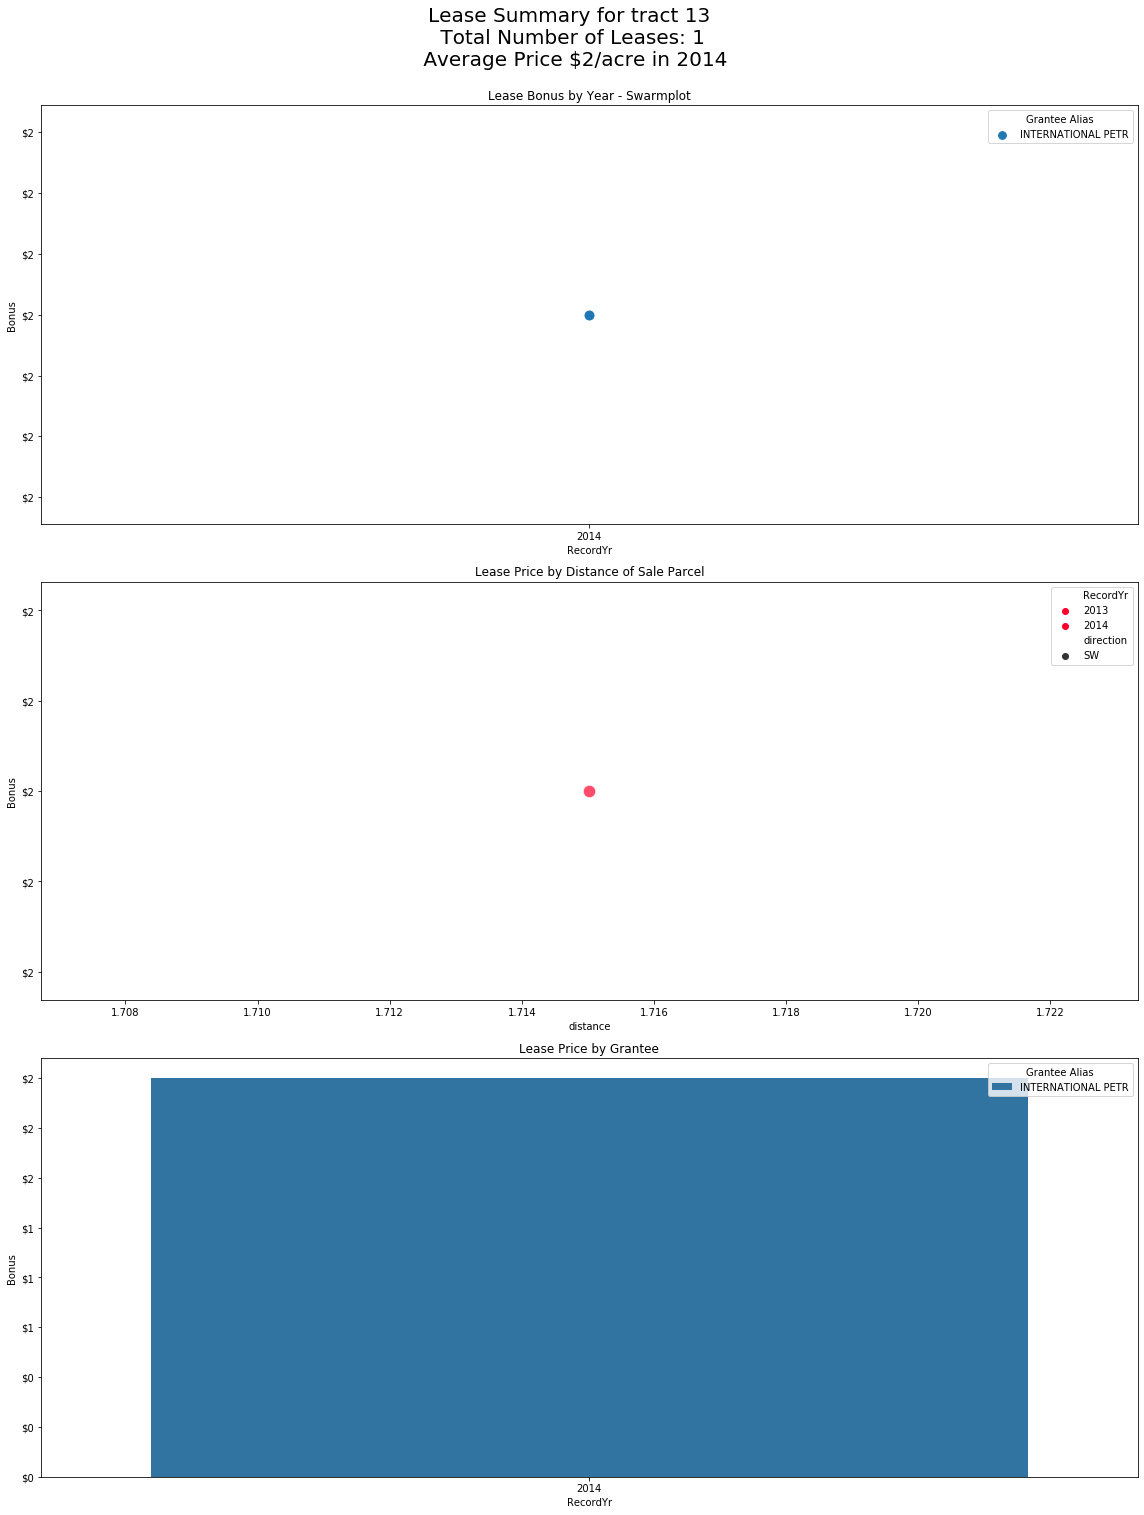

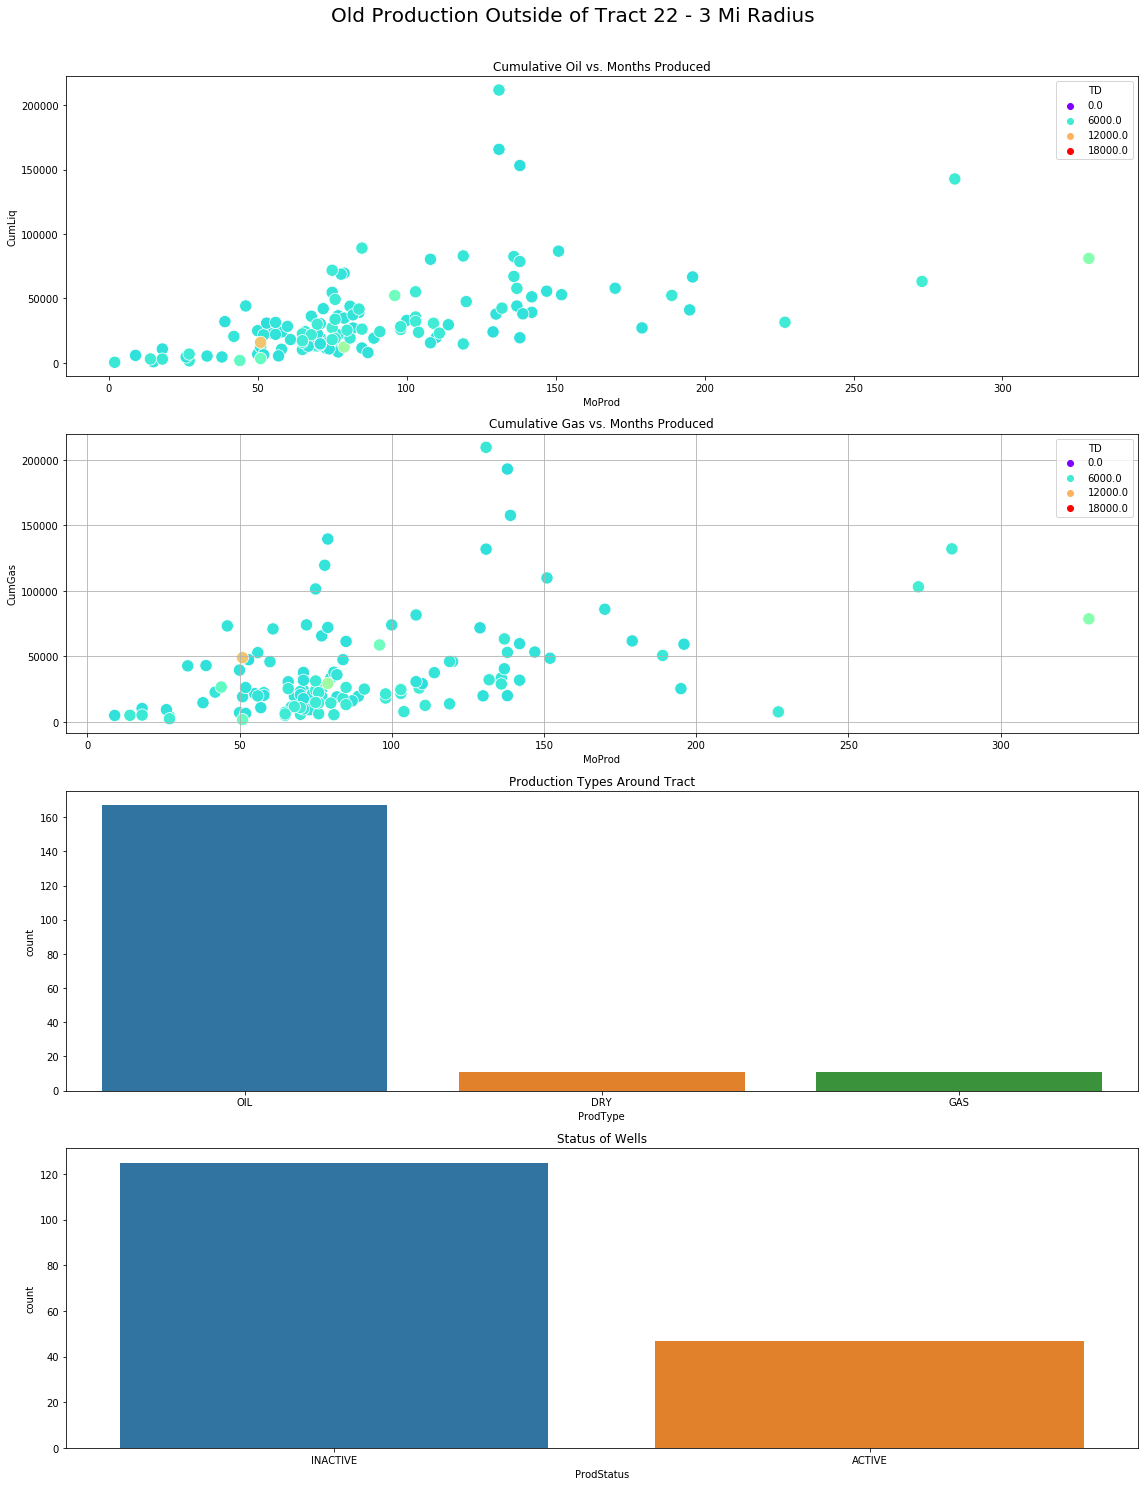

In [33]:
for item in MasterDash:
    for figures in item:
        figures

In [34]:
#saving visualizations in results subfolder called viz
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("Results/Permits Leases and Prod Visualizations.pdf")

#loooping through each set of figures for each tract, saving them to pdf
for items in MasterDash:
    for fig in items: 
        try:
            #bbox = tight is to make sure plot titles aren't cut off that have been shifted up
            pdf.savefig(fig, bbox_inches='tight')
        except:
            print("Error Occured - Most likely null figure")
        
pdf.close()


Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
Error Occured - Most likely null figure
